In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.feature_extraction.text import CountVectorizer


sns.set_style('whitegrid')
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

## EDA + Feature Engineering

In [2]:
df = pd.read_csv('train.csv')

In [3]:
df.head()

id                                       comment_text  toxic  \
0  0000997932d777bf  Explanation\nWhy the edits made under my usern...      0   
1  000103f0d9cfb60f  D'aww! He matches this background colour I'm s...      0   
2  000113f07ec002fd  Hey man, I'm really not trying to edit war. It...      0   
3  0001b41b1c6bb37e  "\nMore\nI can't make any real suggestions on ...      0   
4  0001d958c54c6e35  You, sir, are my hero. Any chance you remember...      0   

   severe_toxic  obscene  threat  insult  identity_hate  
0             0        0       0       0              0  
1             0        0       0       0              0  
2             0        0       0       0              0  
3             0        0       0       0              0  
4             0        0       0       0              0

### Non-null + Unbalanced dataset

In [4]:
#check for null and datatypes
df.info()
#no null, datatype alright

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 8 columns):
id               159571 non-null object
comment_text     159571 non-null object
toxic            159571 non-null int64
severe_toxic     159571 non-null int64
obscene          159571 non-null int64
threat           159571 non-null int64
insult           159571 non-null int64
identity_hate    159571 non-null int64
dtypes: int64(6), object(2)
memory usage: 9.7+ MB


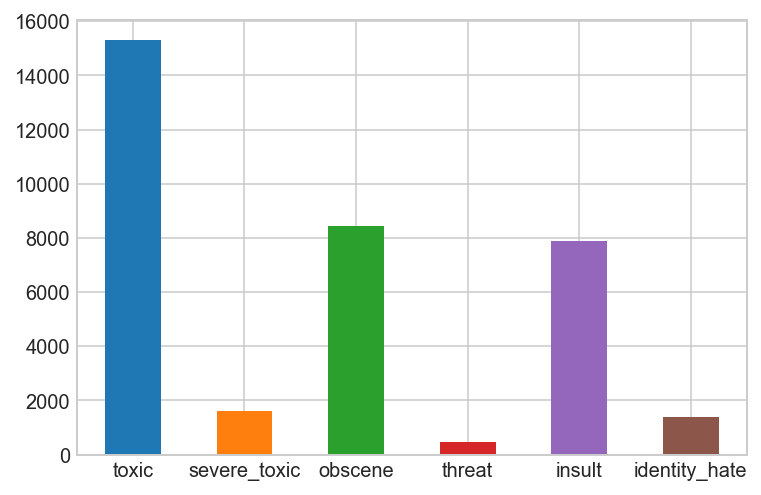

In [5]:
labels = ['toxic','severe_toxic','obscene','threat','insult','identity_hate']
df[labels].sum().plot(kind='bar', rot=0)

In [6]:
df[df[labels].sum(axis=1) > 0][labels].sum()

toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

In [7]:
df[labels].sum()/len(df)*100

toxic            9.584448
severe_toxic     0.999555
obscene          5.294822
threat           0.299553
insult           4.936361
identity_hate    0.880486
dtype: float64

In [8]:
df['neg'] = df[labels].sum(axis=1)
df['neg'] = df['neg'].map(lambda x: 1 if x > 0 else 0)

In [9]:
#find number of toxic type in dataset
print ('         No. of rows')
print (df[labels].sum())
print ('')
print ('Percentage % of total datapoints')
print (df[labels].sum()/len(df)*100)
#datapoints severely underrepresented
print ('')
print ('Percentage % of negative datapoints')
print (df[labels].sum()/len(df[df['neg']==1])*100)

         No. of rows
toxic            15294
severe_toxic      1595
obscene           8449
threat             478
insult            7877
identity_hate     1405
dtype: int64

Percentage % of total datapoints
toxic            9.584448
severe_toxic     0.999555
obscene          5.294822
threat           0.299553
insult           4.936361
identity_hate    0.880486
dtype: float64

Percentage % of negative datapoints
toxic            94.261941
severe_toxic      9.830508
obscene          52.073960
threat            2.946071
insult           48.548536
identity_hate     8.659476
dtype: float64


In [10]:
#train-test split
from sklearn.model_selection import train_test_split
X = df['comment_text']
y = df[labels]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
train = pd.concat([X_train,y_train], axis=1)
test = pd.concat([X_test,y_test], axis=1)

In [11]:
#sample comments from each label
for label in labels:
    print (label)
    print (train[train[label]==1]['comment_text'].sample(3, random_state=40).values)
    print ('')
#spams, spelling check, removal or weird characters. use unique words/total words to bring out characteristics of spam toxic comments

toxic
["Who's ur Uncle, Dick?"
 'Achievement - YOU ARE A BlTCH \n\nGet off my talkpage you gay arse.'
 'Diana is a fucking bitch nigger piece of shit']

severe_toxic
["fuck you and grow up and get a real life and quit living out your pathetic fucking dream of being the boss of people on FUCKING WIKIPEDIA!  you're fucking pathetic...rip off the name tag, take off the paper hat, tell them that you don't wanna flip burgers any more, and GET THE FUCK OFF THIS SITE YOU CHILD!"
 'die \n\nplease why dont u do us all a favioe and kill yourslef'
 'Hey nigger \n\nGo fuck yourself and stop revering my reverts.']

obscene
['FUCKING BITCHES THAT ARE READING THIS. JASENM222 SUCKS FAT DICK.FUCKING BITCHES THAT ARE READING THIS. JASENM222 SUCKS FAT DICK.FUCKING BITCHES THAT ARE READING THIS. JASENM222 SUCKS FAT DICK.FUCKING BITCHES THAT ARE READING THIS. JASENM222 SUCKS FAT DICK.FUCKING BITCHES THAT ARE READING THIS. JASENM222 SUCKS FAT DICK.FUCKING BITCHES THAT ARE READING THIS. JASENM222 SUCKS FAT D

### Cleaning text

In [12]:
##function to clean text
def text_clean(df, text_col):
    import re
    df[text_col] = df[text_col].apply(lambda x: re.sub(',', '', x)) #replace commas without space to prevent additional spaces in sentences
    df[text_col] = df[text_col].apply(lambda x: re.sub("'", '', x)) #replace ' next to get words like dont, wont, etc.
    df[text_col] = df[text_col].apply(lambda x: re.sub('[^ a-zA-Z0-9!]', ' ', x).lower()) #replace weird char without ! (!+  seems to appear quite abit in toxic comments) + lower case
    df[text_col] = df[text_col].apply(lambda x: " ".join(x.split())) #remove additional spaces
text_clean(train, 'comment_text')

In [13]:
#sample comments from each label
for label in labels:
    print (label)
    print (train[train[label]==1]['comment_text'].sample(1, random_state=40).values)
    print ('')

toxic
['whos ur uncle dick']

severe_toxic
['fuck you and grow up and get a real life and quit living out your pathetic fucking dream of being the boss of people on fucking wikipedia! youre fucking pathetic rip off the name tag take off the paper hat tell them that you dont wanna flip burgers any more and get the fuck off this site you child!']

obscene
['fucking bitches that are reading this jasenm222 sucks fat dick fucking bitches that are reading this jasenm222 sucks fat dick fucking bitches that are reading this jasenm222 sucks fat dick fucking bitches that are reading this jasenm222 sucks fat dick fucking bitches that are reading this jasenm222 sucks fat dick fucking bitches that are reading this jasenm222 sucks fat dick fucking bitches that are reading this jasenm222 sucks fat dick fucking bitches that are reading this jasenm222 sucks fat dick fucking bitches that are reading this jasenm222 sucks fat dick fucking bitches that are reading this jasenm222 sucks fat dick fucking bitc

### Text features - length & spam

In [14]:
#get word length
train['text_len'] = train.comment_text.apply(lambda x: len(x.split()))

In [15]:
#1 word text contains more non-relevant weblinks and weird character information. to considering filtering.
train[train['text_len']<2]

comment_text  toxic  severe_toxic  obscene  threat  insult  \
5899            copyright      0             0        0       0       0   
119602          etymology      0             0        0       0       0   
79405             sources      0             0        0       0       0   
152298          surprise!      0             0        0       0       0   
2629               thanks      0             0        0       0       0   
109985             unbloc      0             0        0       0       0   
6746    talkcontributions      0             0        0       0       0   
22099   talkcontributions      0             0        0       0       0   

        identity_hate  text_len  
5899                0         1  
119602              0         1  
79405               0         1  
152298              0         1  
2629                0         1  
109985              0         1  
6746                0         1  
22099               0         1

C:\Users\Samson\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Samson\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Samson\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "
C:\Users\Samson\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\matplotlib\axes\_axes.py:6462: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' k

Text(0.5,0,'')

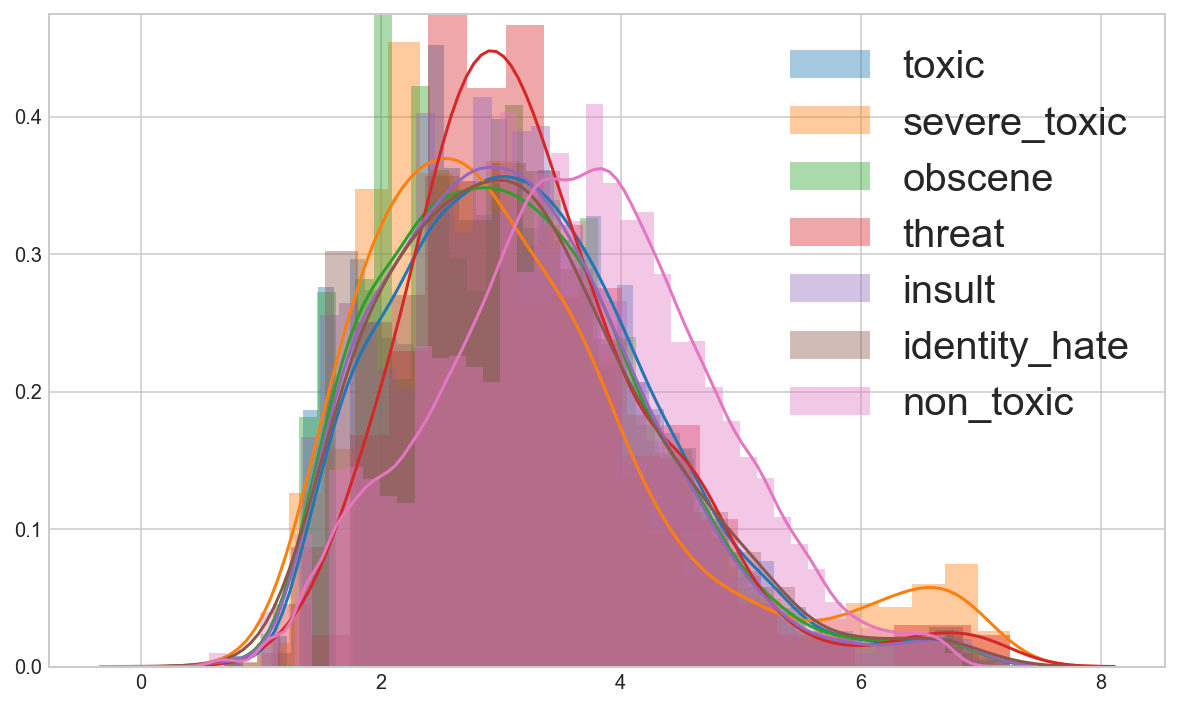

In [16]:
#explore length of words and characters for toxicity
plt.figure(figsize=(10,6))
#plot distribution for each variable
sns.distplot(np.log(train[train['toxic']==1]['text_len']), label='toxic')
sns.distplot(np.log(train[train['severe_toxic']==1]['text_len']), label='severe_toxic')
sns.distplot(np.log(train[train['obscene']==1]['text_len']), label='obscene')
sns.distplot(np.log(train[train['threat']==1]['text_len']), label='threat')
sns.distplot(np.log(train[train['insult']==1]['text_len']), label='insult')
sns.distplot(np.log(train[train['identity_hate']==1]['text_len']), label='identity_hate')
sns.distplot(np.log(train[train[labels].sum(axis=1) == 0]['text_len']), label='non_toxic') #non-toxic comments

#include legend
plt.legend()
plt.legend(prop={'size': 20})
plt.xlabel('', fontsize=18)
#some observations
#1.non_toxic comments have greater no. of words than all other toxic comments due to data nature (wikipedia edits need explanation)
#2.threat has a slightly higher frequency of median words
#3.severe_toxic has lower median and a weird kink after e^6 due to spam

In [17]:
train[(train['severe_toxic']==1)&(train['text_len']>np.exp(6))]['comment_text'].values
#looks like the weird kink is caused by spam/repetitive toxic words, except for [13]
#to find way to incorporate spam/repetition as a feature (perhaps tf-idf and word count will sufficiently represent)

array(['go fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourselfgo fuck yourself

In [18]:
### Use unique words / total words to find spam toxic.
##function to get text len, unique words and unique words/total words to find toxic spam comments
def text_attr(df, text_col):
    df['text_len'] = df[text_col].apply(lambda x: len(x.split()))
    df['unique_text'] = df[text_col].map(lambda x: len(set(x.split()))) #no. of unique words in text
    df['spam_inv_ratio'] = df['unique_text']/df['text_len'] #smaller ratio increase probability of spam
text_attr(train, 'comment_text')

In [19]:
ratio = 0.3
print (len(train[train['spam_inv_ratio']<ratio]))
train[train['spam_inv_ratio']<ratio].sum()[labels]/len(train[train['spam_inv_ratio']<ratio])
# when spam inverse ratio < 0.3, more than 50% of dataset belongs to some form of toxicity

426


toxic             0.664319
severe_toxic      0.269953
obscene           0.429577
threat           0.0352113
insult            0.361502
identity_hate    0.0868545
dtype: object

### Looking at top words

In [20]:
#check top words appearing in comments
def top_20_words(df, text_col, ngram_range=(1,1)):
    from sklearn.feature_extraction.text import CountVectorizer
    def get_freq_words(sparse_counts, columns):
        # X_all is a sparse matrix, so sum() returns a 'matrix' datatype ...
        #   which we then convert into a 1-D ndarray for sorting
        word_counts = np.asarray(X_all.sum(axis=0)).reshape(-1)
        # argsort() returns smallest first, so we reverse the result
        largest_count_indices = word_counts.argsort()[::-1]
        # pretty-print the results! Remember to always ask whether they make sense ...
        freq_words = pd.Series(word_counts[largest_count_indices], 
                               index=columns[largest_count_indices])
        return freq_words
    cvt = CountVectorizer(strip_accents='unicode', stop_words='english', ngram_range=ngram_range, min_df=1, max_df=0.9)
#     X_all = cvt.fit_transform(df[text_col]) #without tfidf
    X_all = TfidfTransformer().fit_transform(cvt.fit_transform(df[text_col])) #with tfidf
    columns = np.array(cvt.get_feature_names())
    print ('No. of ngrams:', len(cvt.get_feature_names()))
    freq_words = get_freq_words(X_all, columns)
    fig, ax = plt.subplots(figsize=(11,6))
    g = sns.barplot(freq_words[:20].index, freq_words[:20])
    g.set_xticklabels(g.get_xticklabels(), rotation=45)
    plt.show();

No. of ngrams: 165924


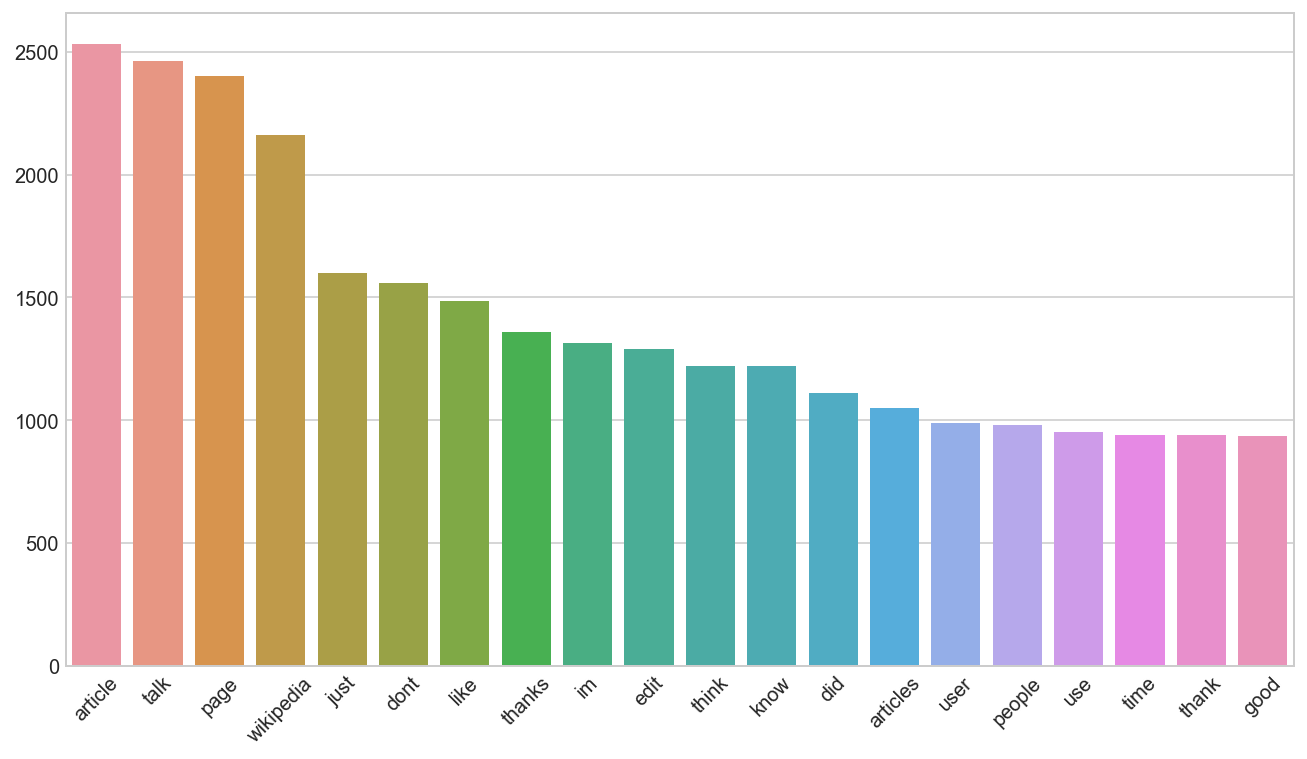

In [21]:
top_20_words(train, 'comment_text')
#overview top words are related to editing of wikipedia pages

toxic
No. of ngrams: 29424


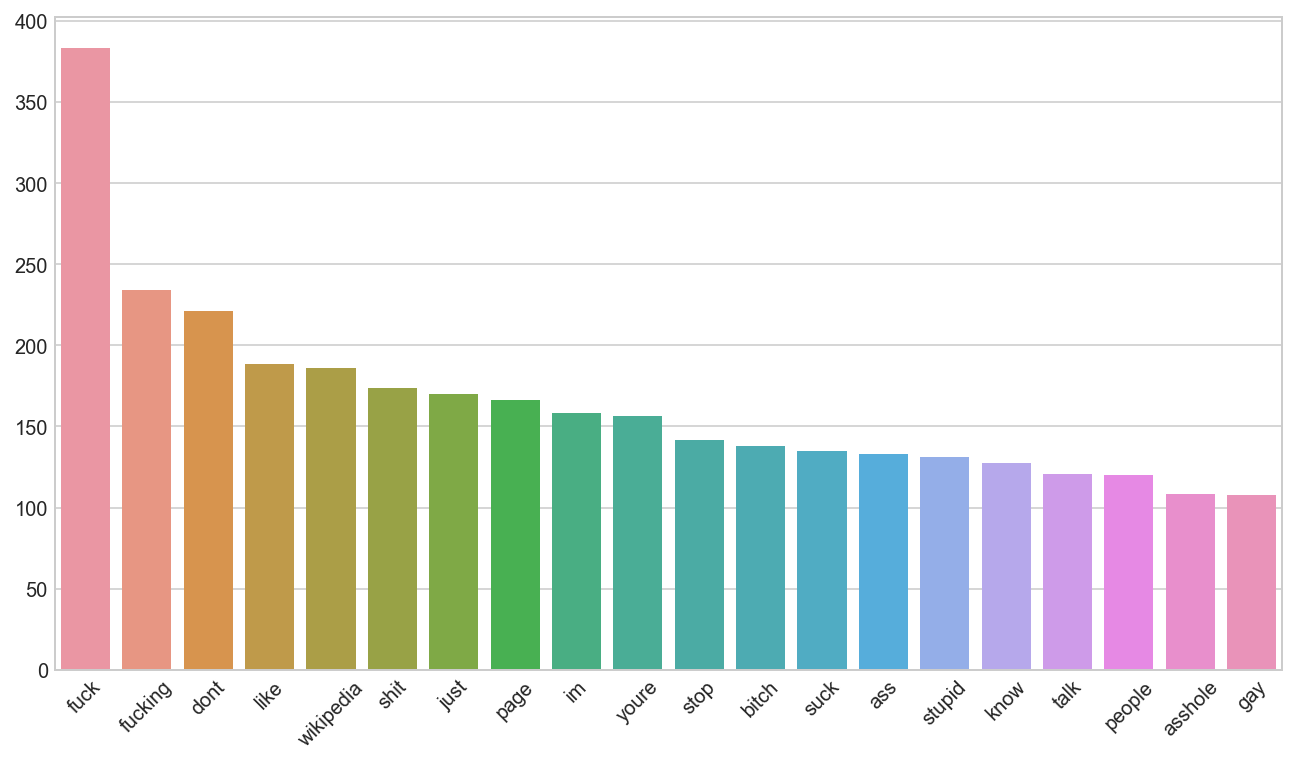

severe_toxic
No. of ngrams: 5185


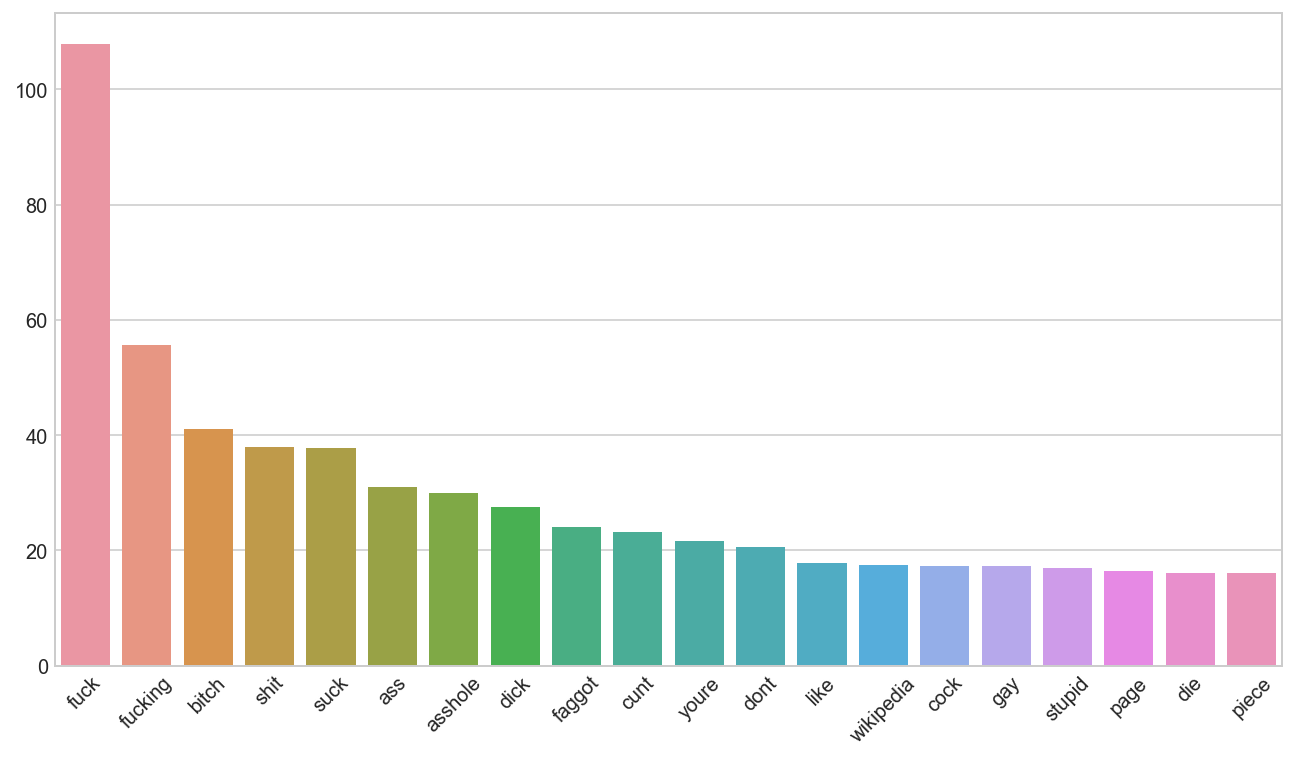

obscene
No. of ngrams: 19065


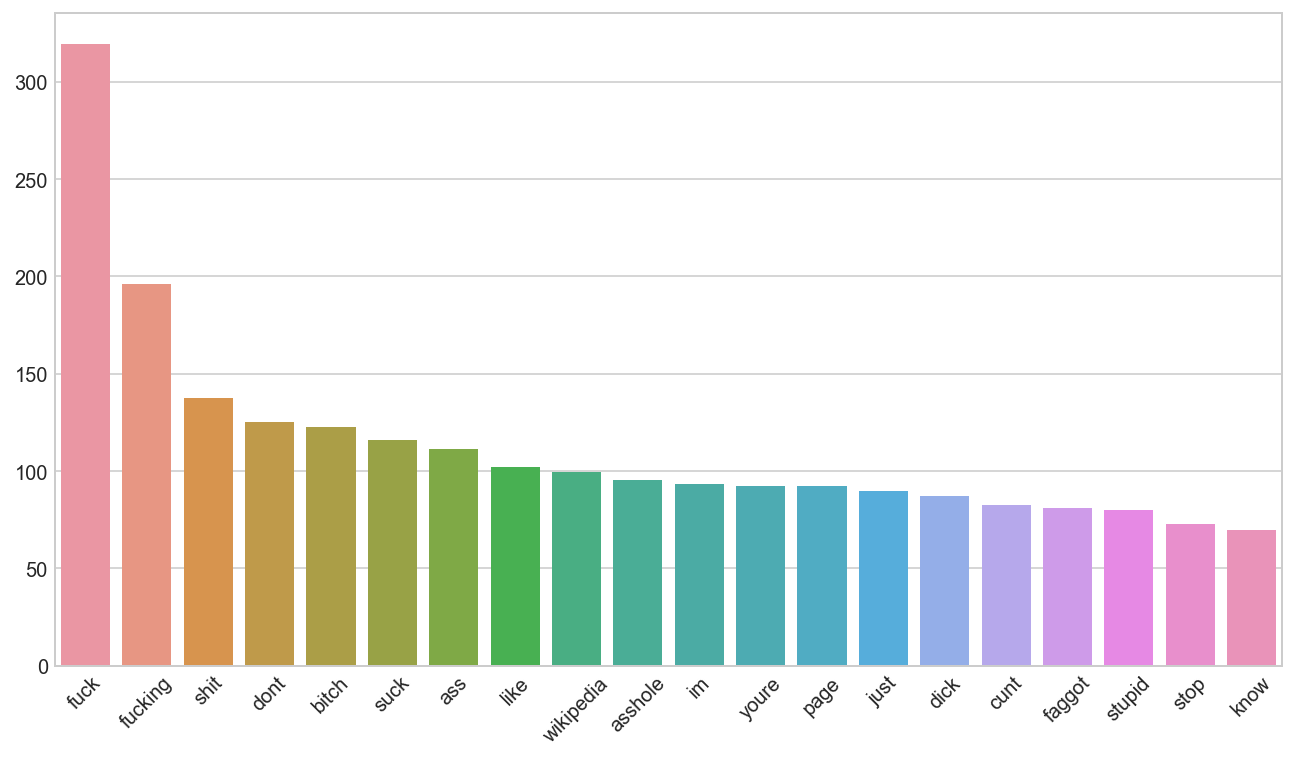

threat
No. of ngrams: 2606


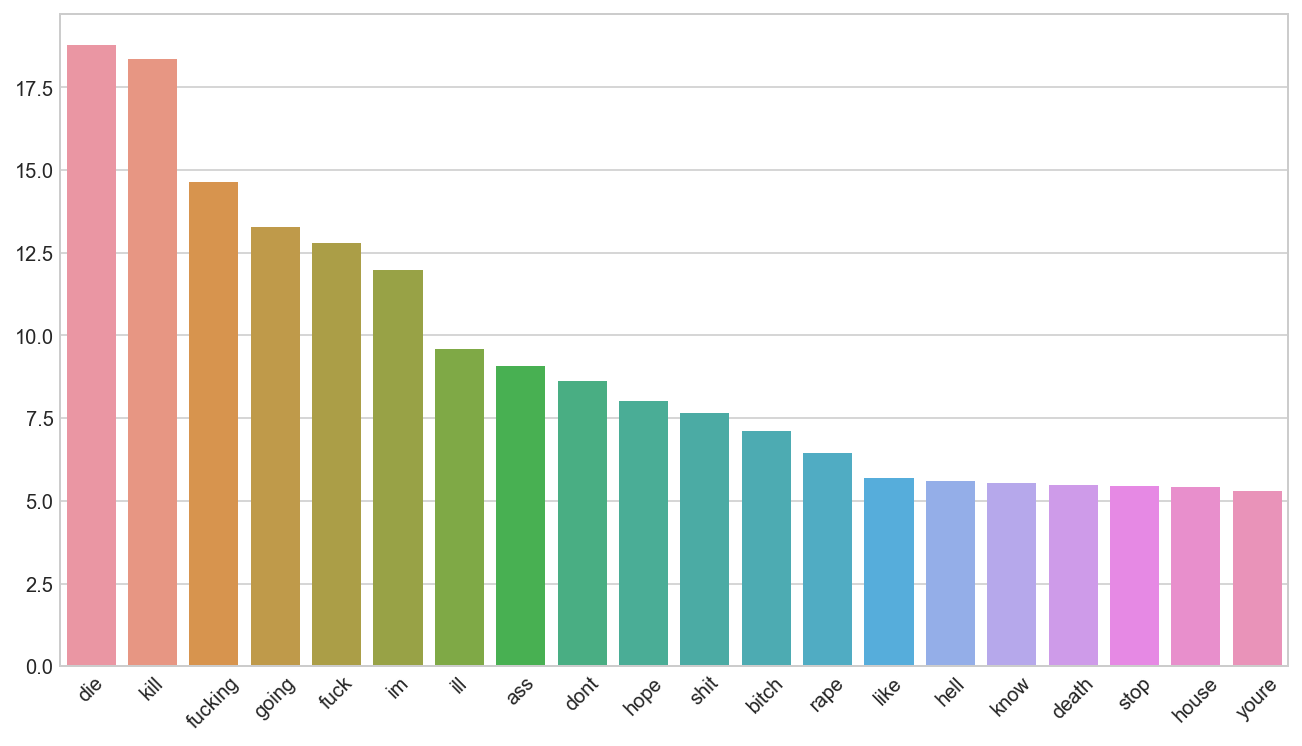

insult
No. of ngrams: 17864


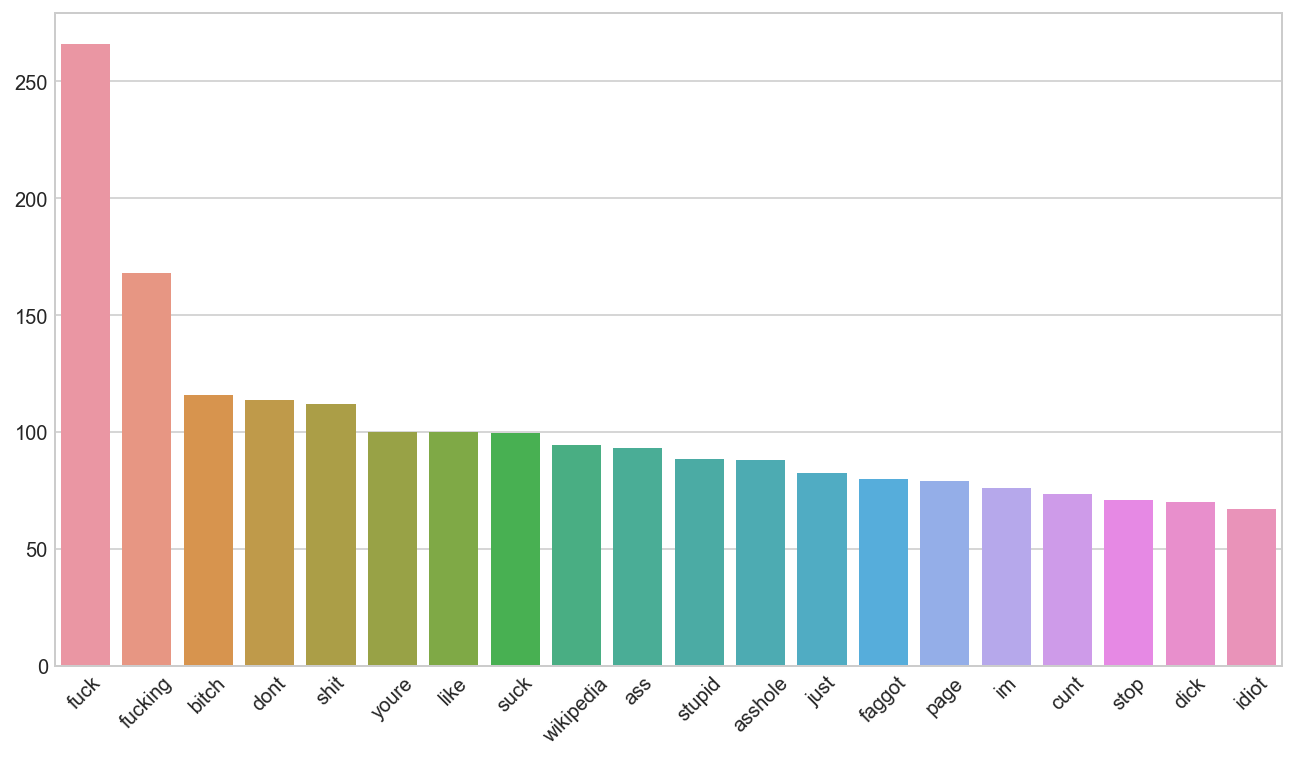

identity_hate
No. of ngrams: 6349


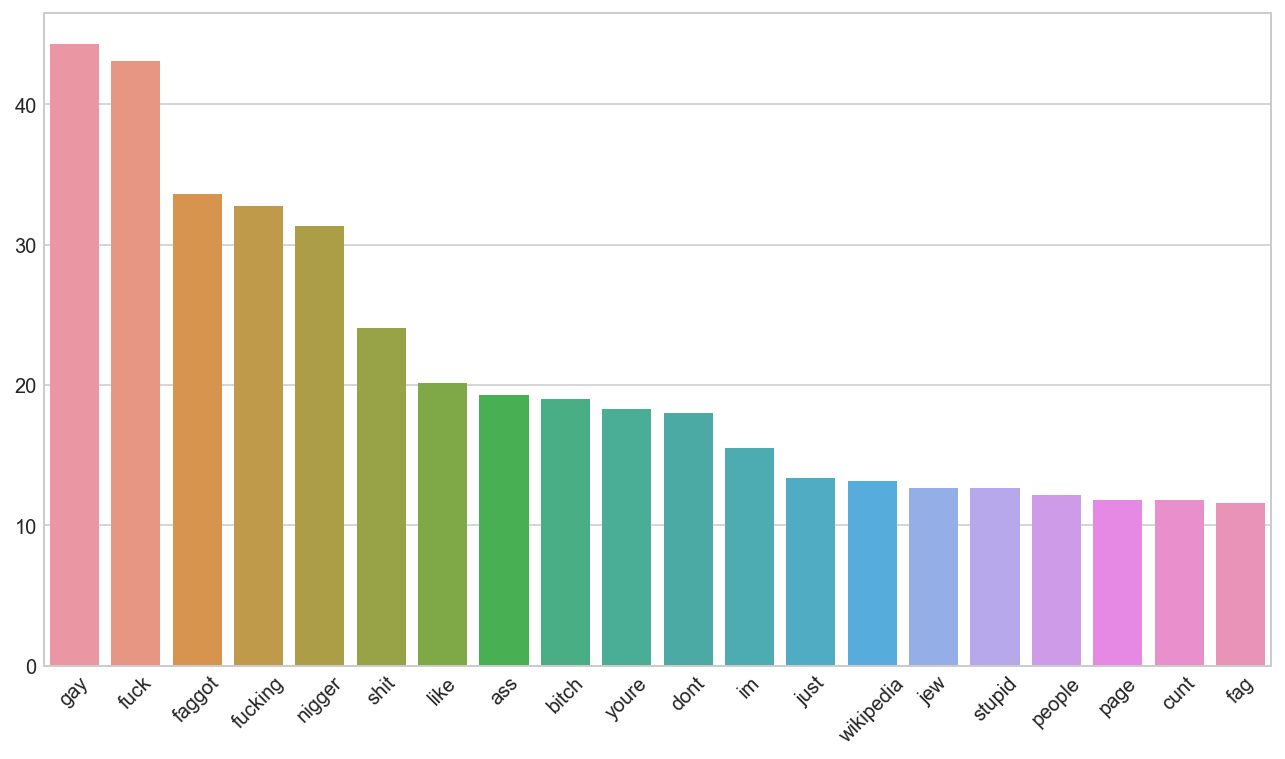

In [22]:
#negative words do come out strongly for toxic comments
for label in labels:
    print (label)
    top_20_words(train[train[label]==1], 'comment_text', ngram_range=(1,1))

lump similar vulgarities with stemming in pipeline later. eg. fuck, fucking

### Sentiment features (Vader)

In [23]:
def sentiment(df, text_col):
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    analyzer = SentimentIntensityAnalyzer()
    senti_pol = df[text_col].apply(lambda x: analyzer.polarity_scores(x))
    return senti_pol

In [24]:
# senti_pol = sentiment(train, 'comment_text')

In [25]:
# senti_pol_df = pd.DataFrame(senti_pol)
# senti_pol_df = senti_pol_df['comment_text'].apply(pd.Series)
# train_senti = pd.concat([train,senti_pol_df], axis=1)
# #save to csv
# train_senti.to_csv('train_senti_2907.csv', encoding='utf-8')

In [26]:
#load from csv 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
train_senti = pd.read_csv('train_senti_2907.csv')

In [27]:
train_senti.columns

Index(['Unnamed: 0', 'comment_text', 'toxic', 'severe_toxic', 'obscene',
       'threat', 'insult', 'identity_hate', 'text_len', 'unique_text',
       'spam_inv_ratio', 'compound', 'neg', 'neu', 'pos'],
      dtype='object')

In [28]:
train_senti = train_senti.drop('Unnamed: 0', axis=1)

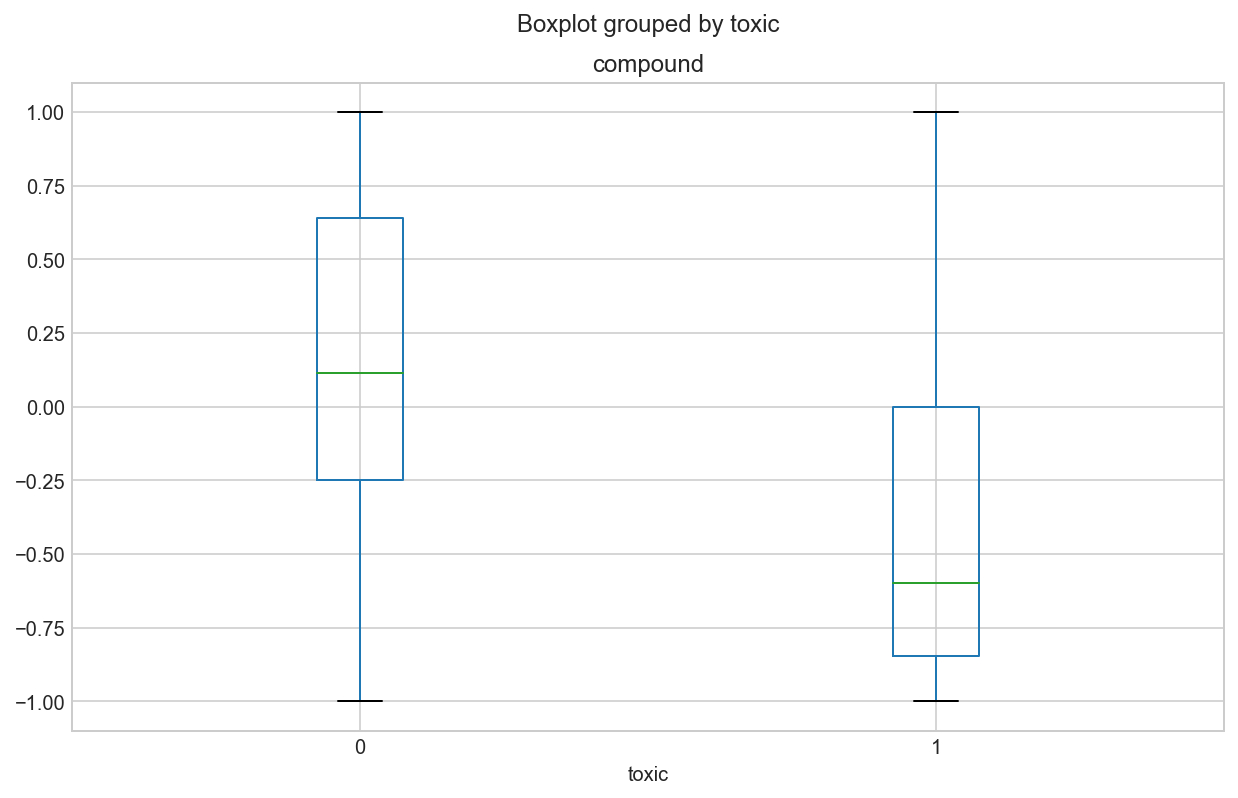

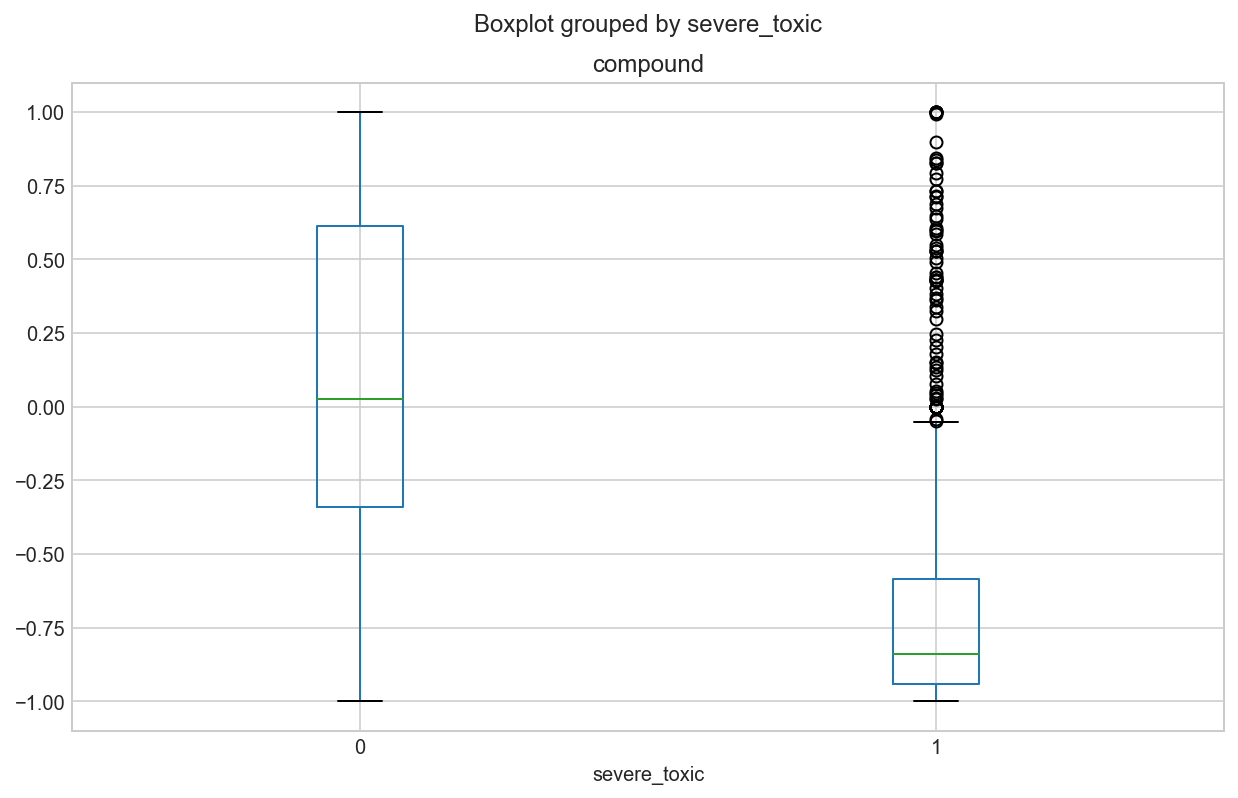

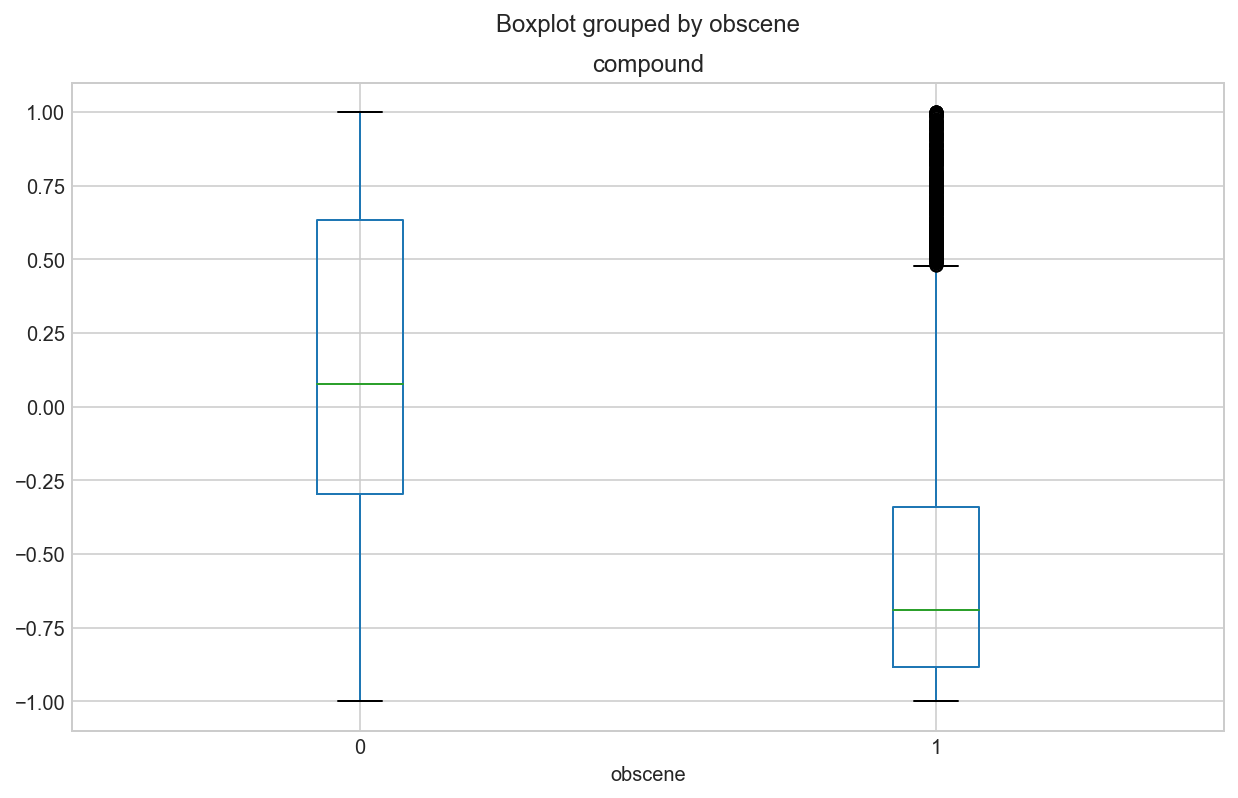

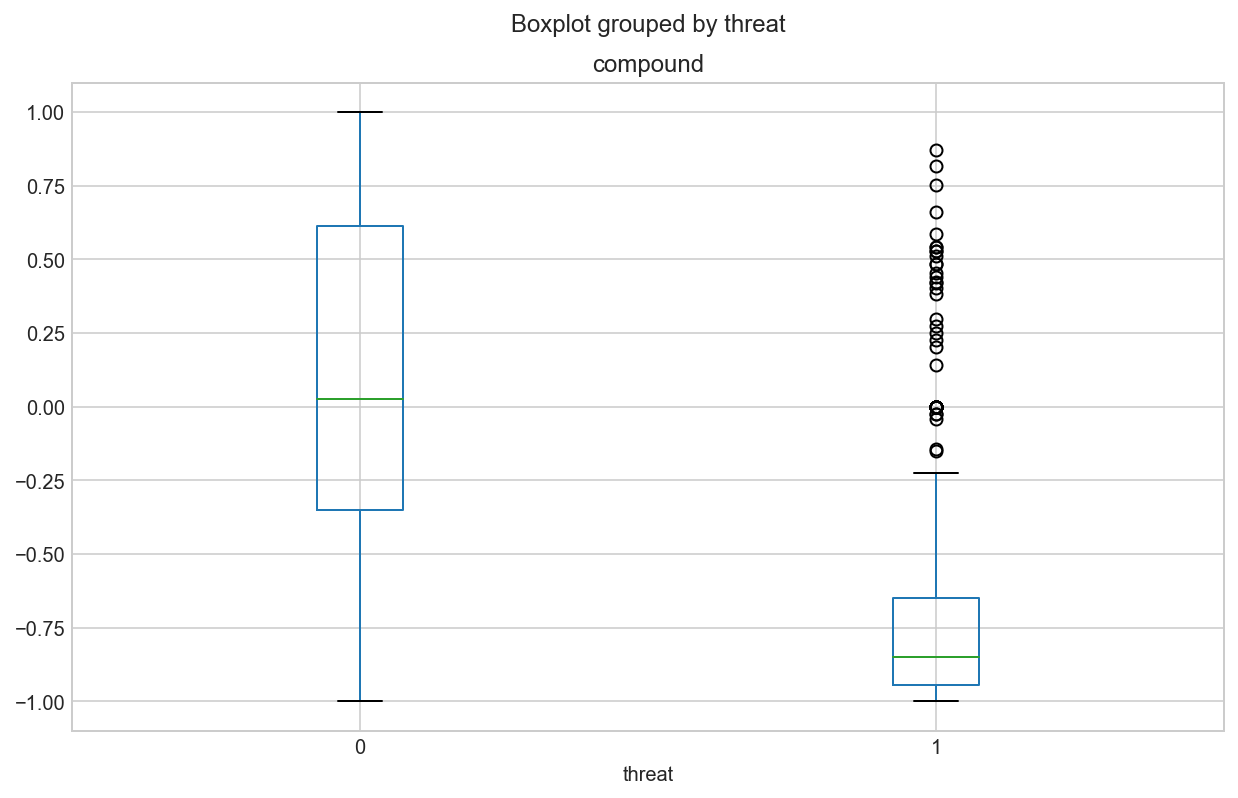

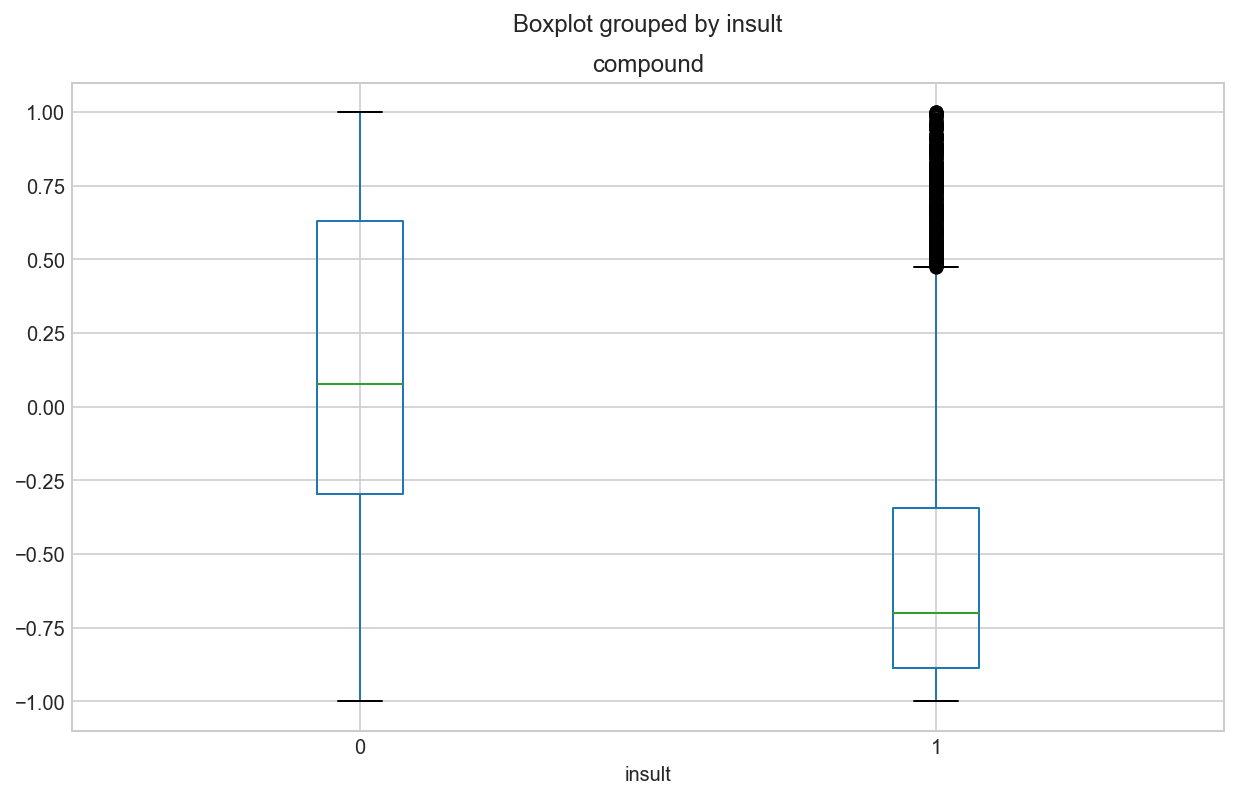

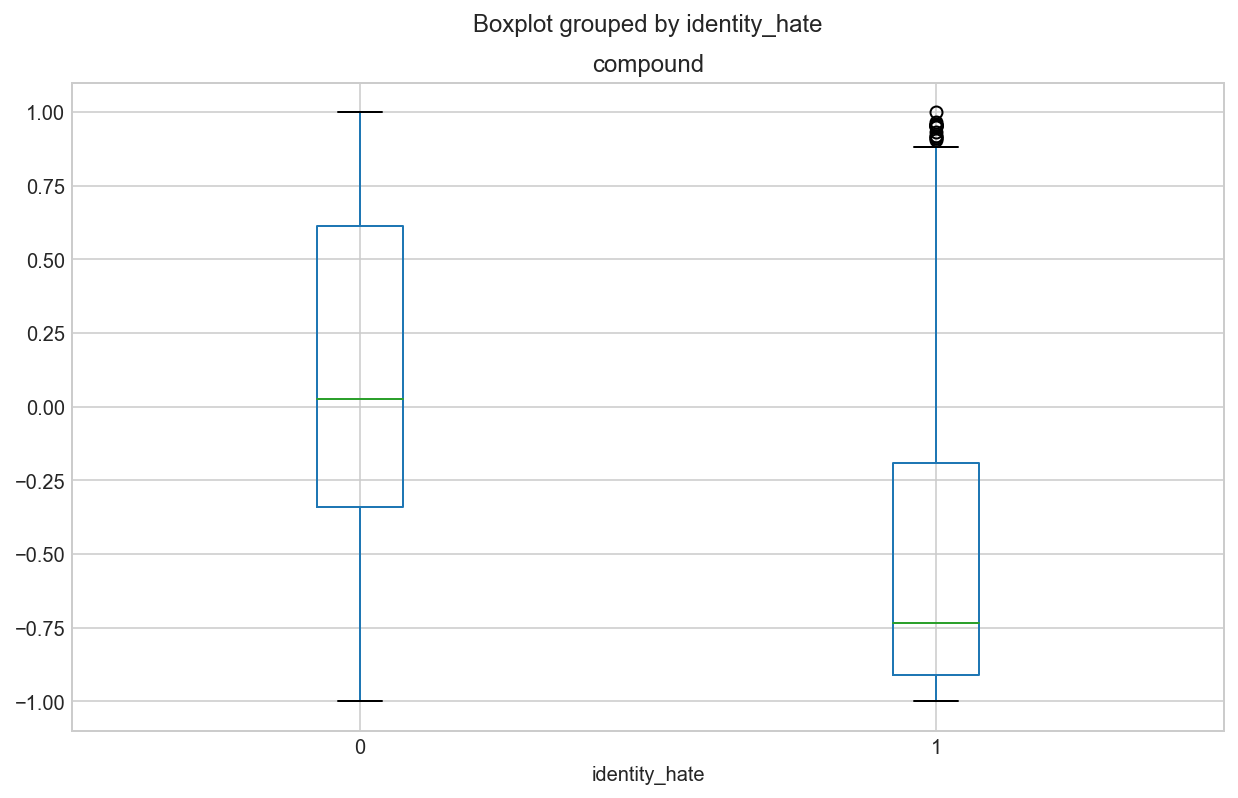

In [29]:
#boxplot to see vader sentiment differences
#toxic comments towards more negative compounds
for label in labels:
    train_senti.boxplot(column='compound', by=label, figsize=(10,6))
    plt.show()

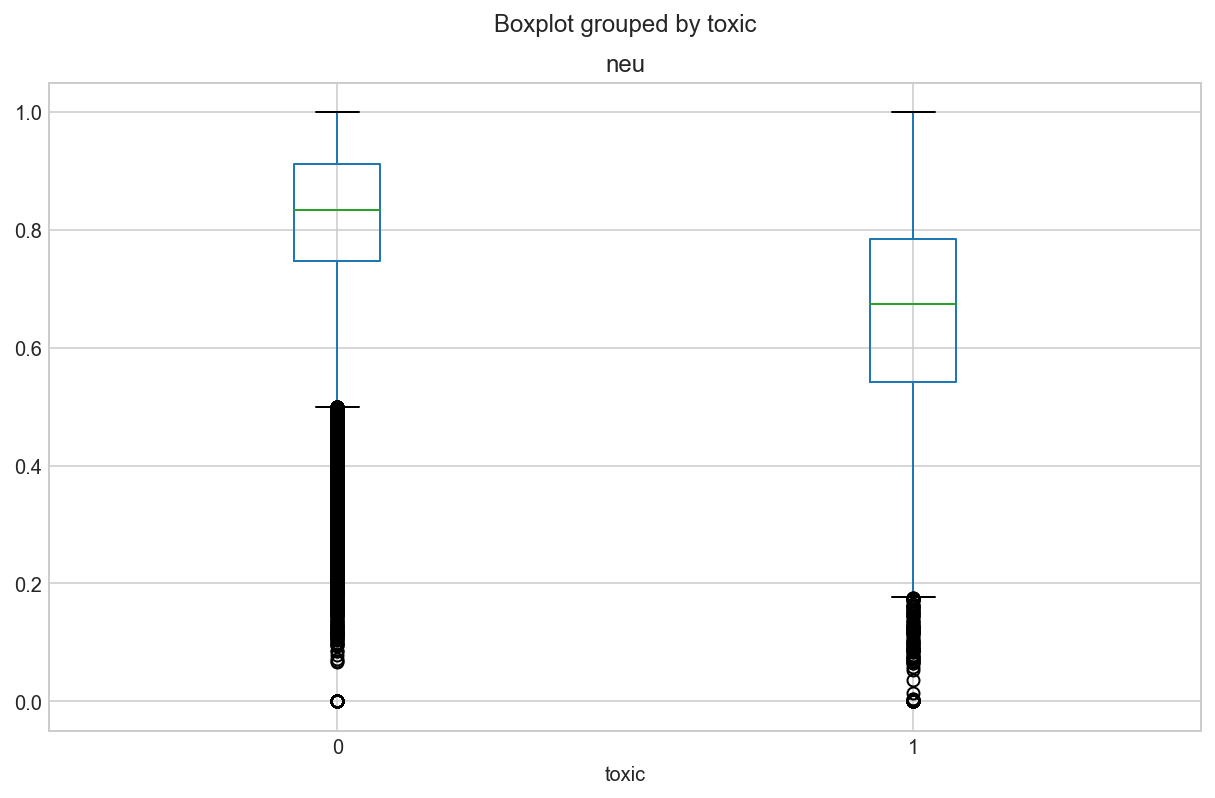

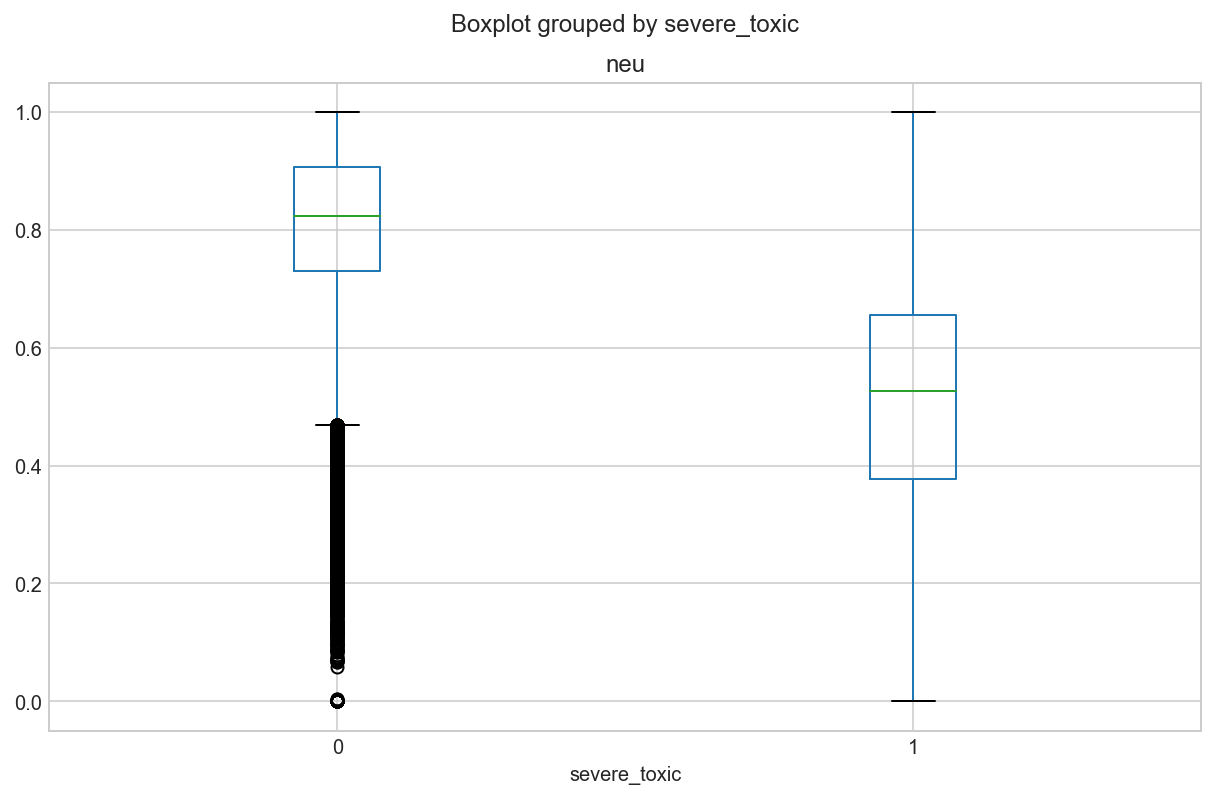

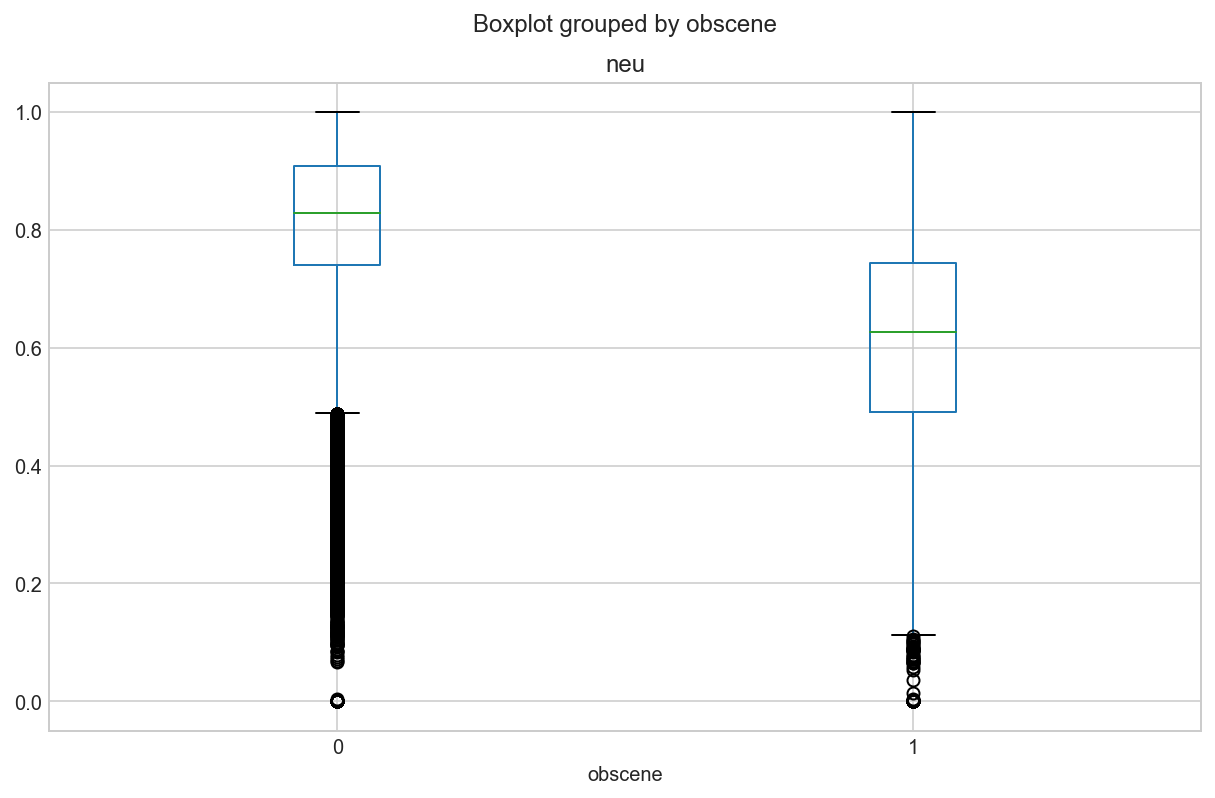

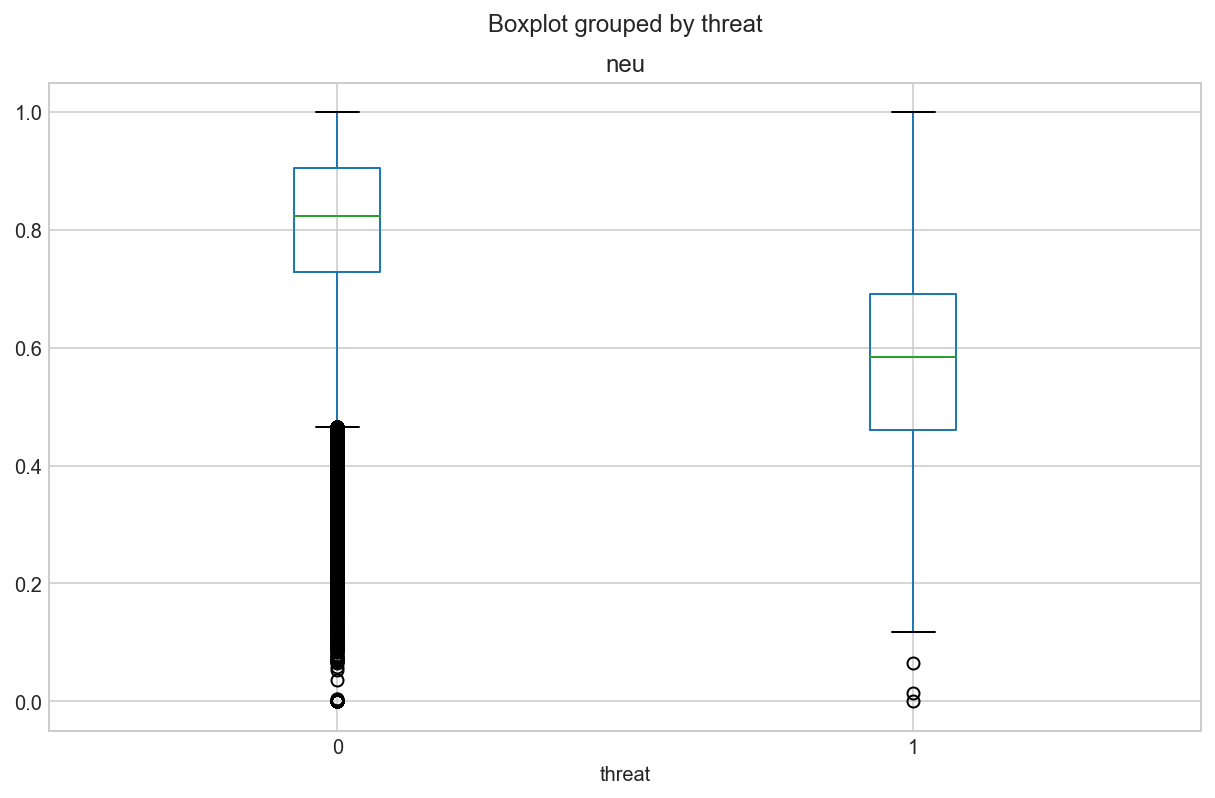

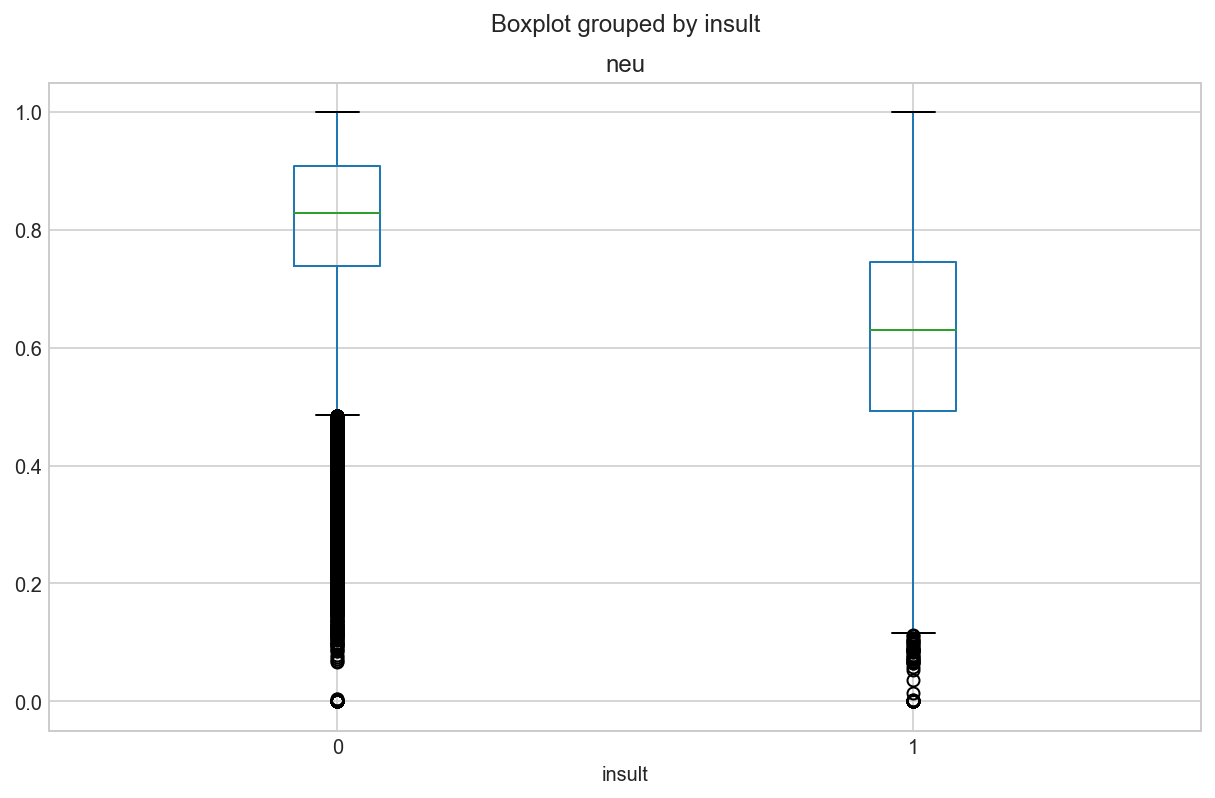

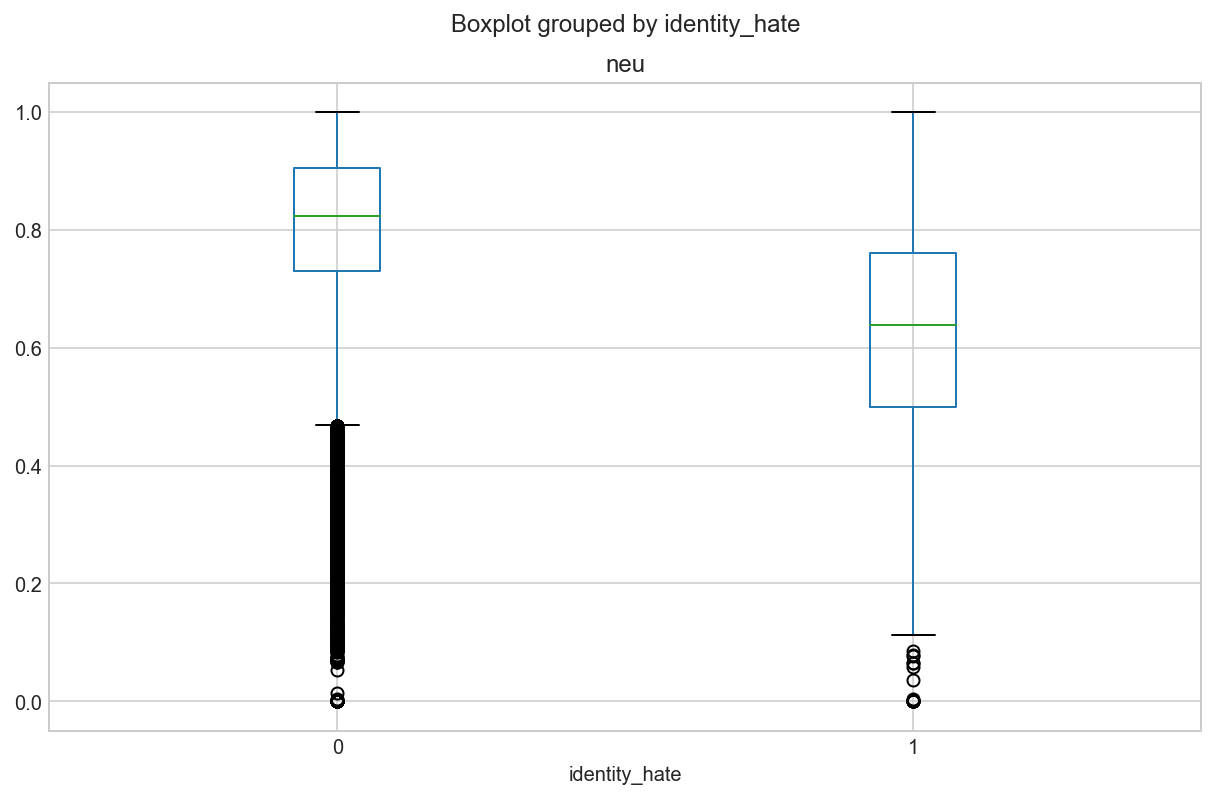

In [30]:
#non-toxic comments are more neutral
for label in labels:
    train_senti.boxplot(column='neu', by=label, figsize=(10,6))
    plt.show()

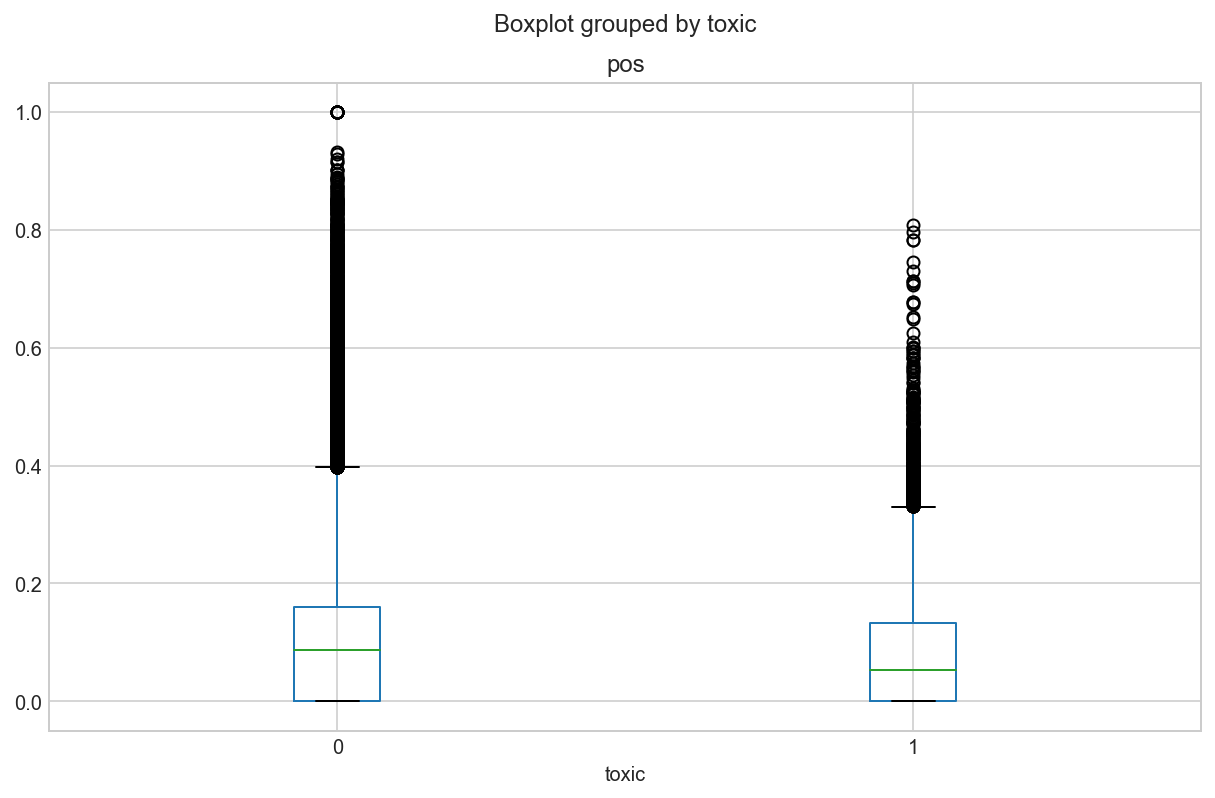

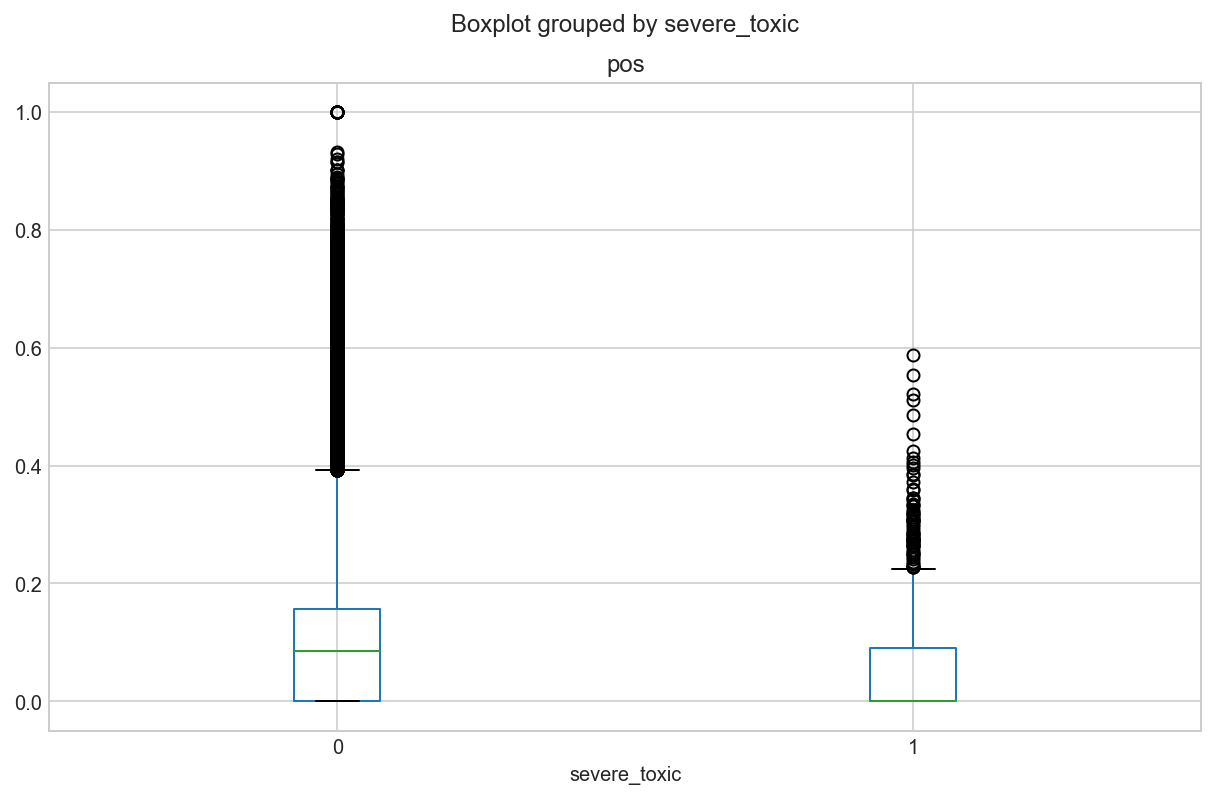

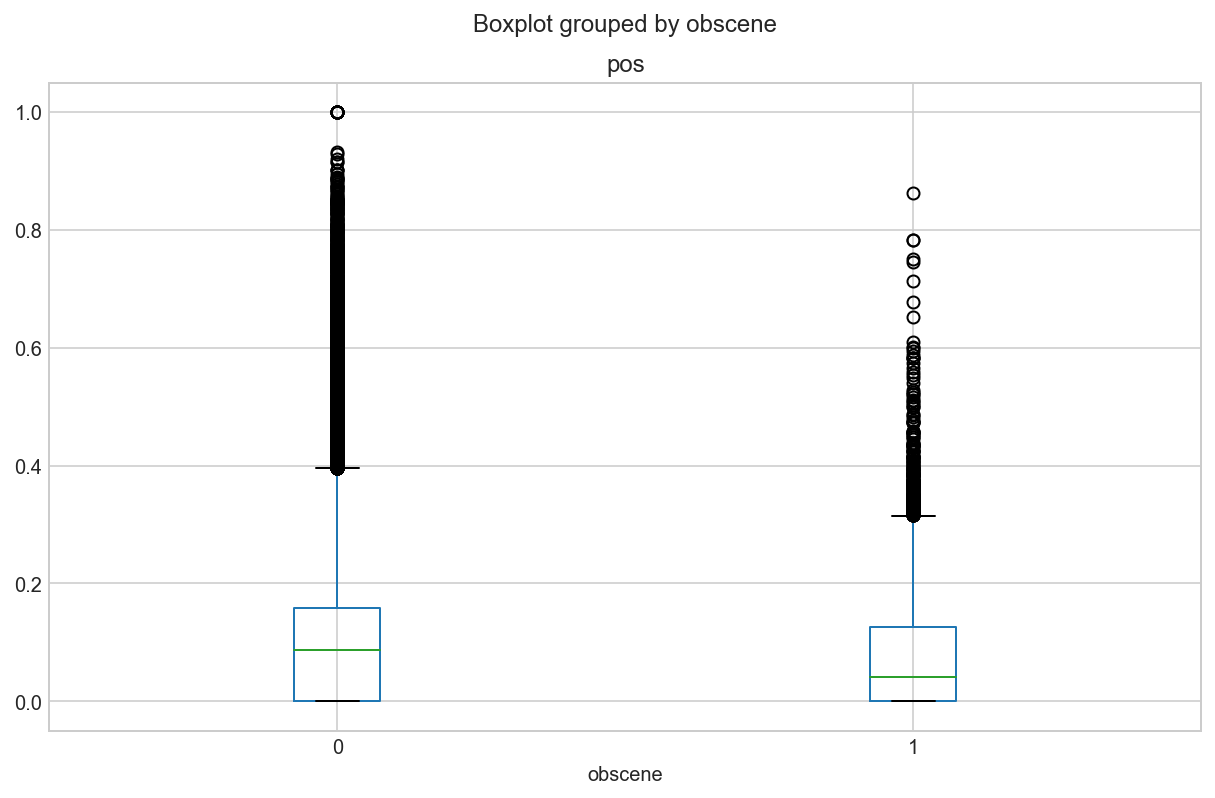

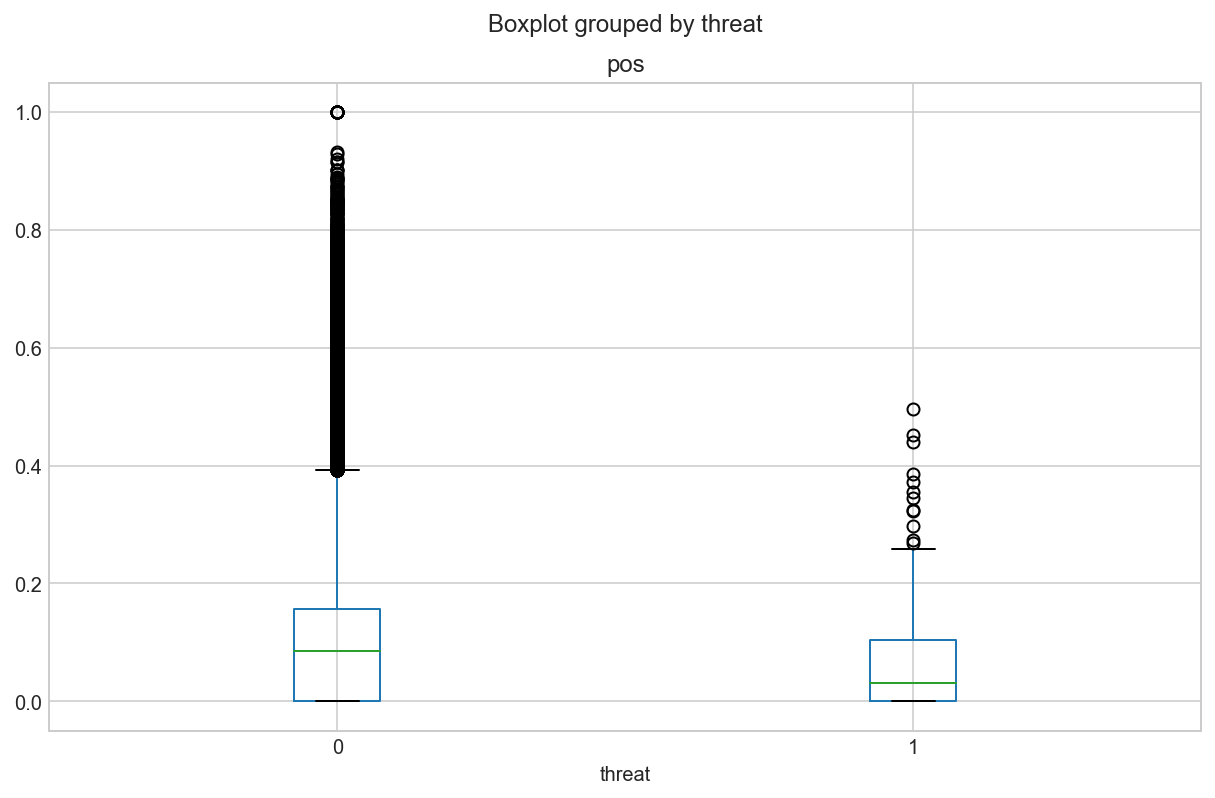

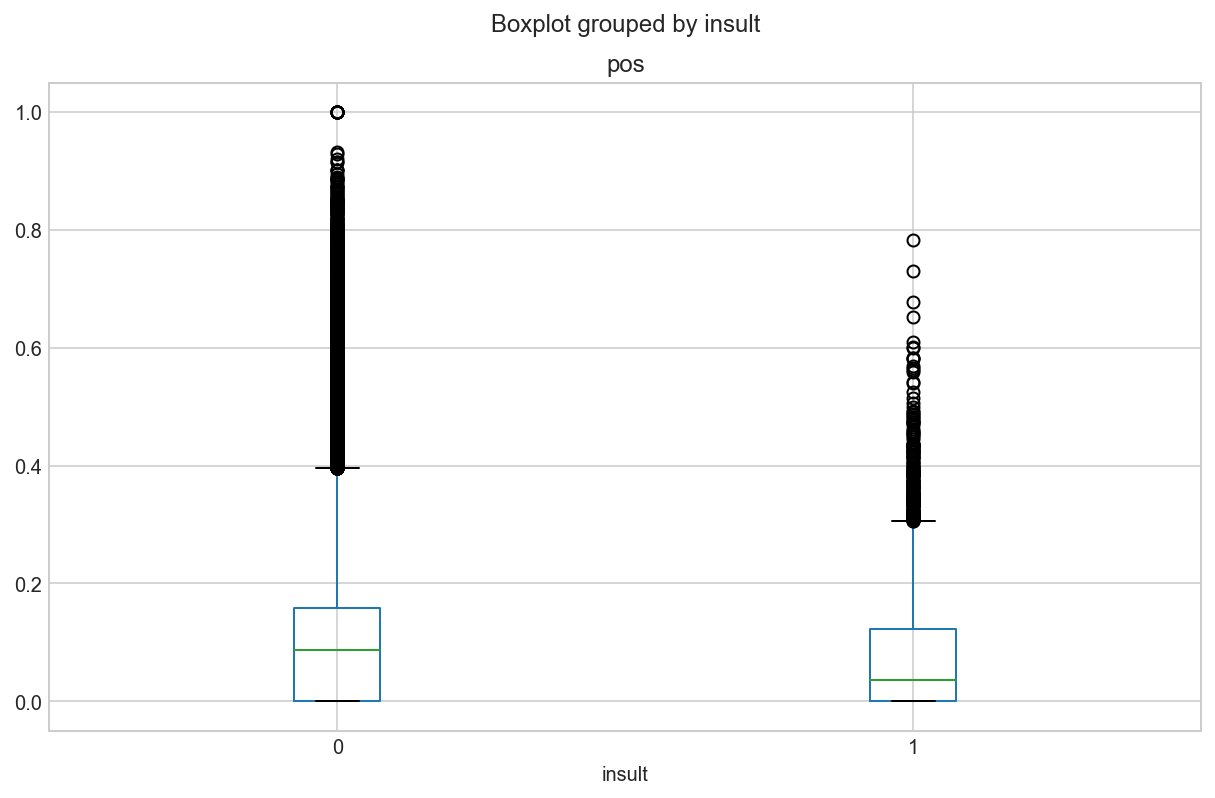

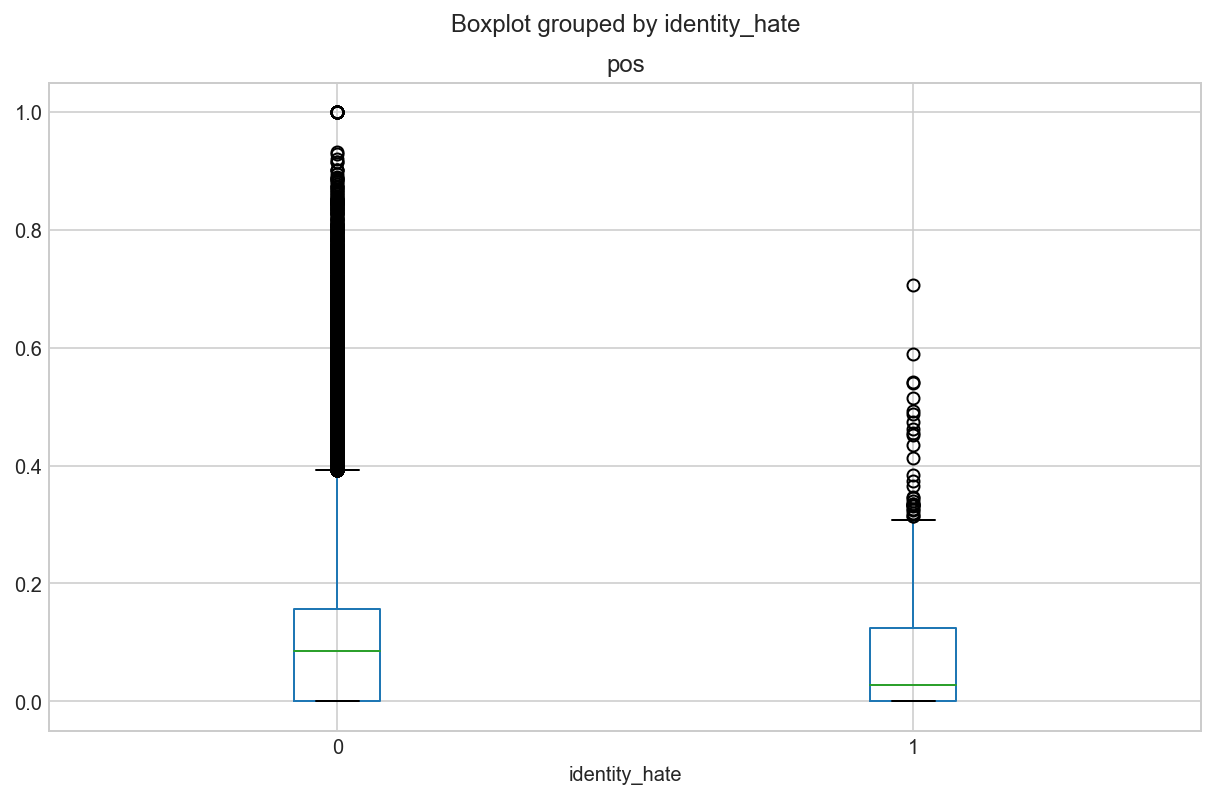

In [31]:
#pos not that strong an indicator
for label in labels:
    train_senti.boxplot(column='pos', by=label, figsize=(10,6))
    plt.show()

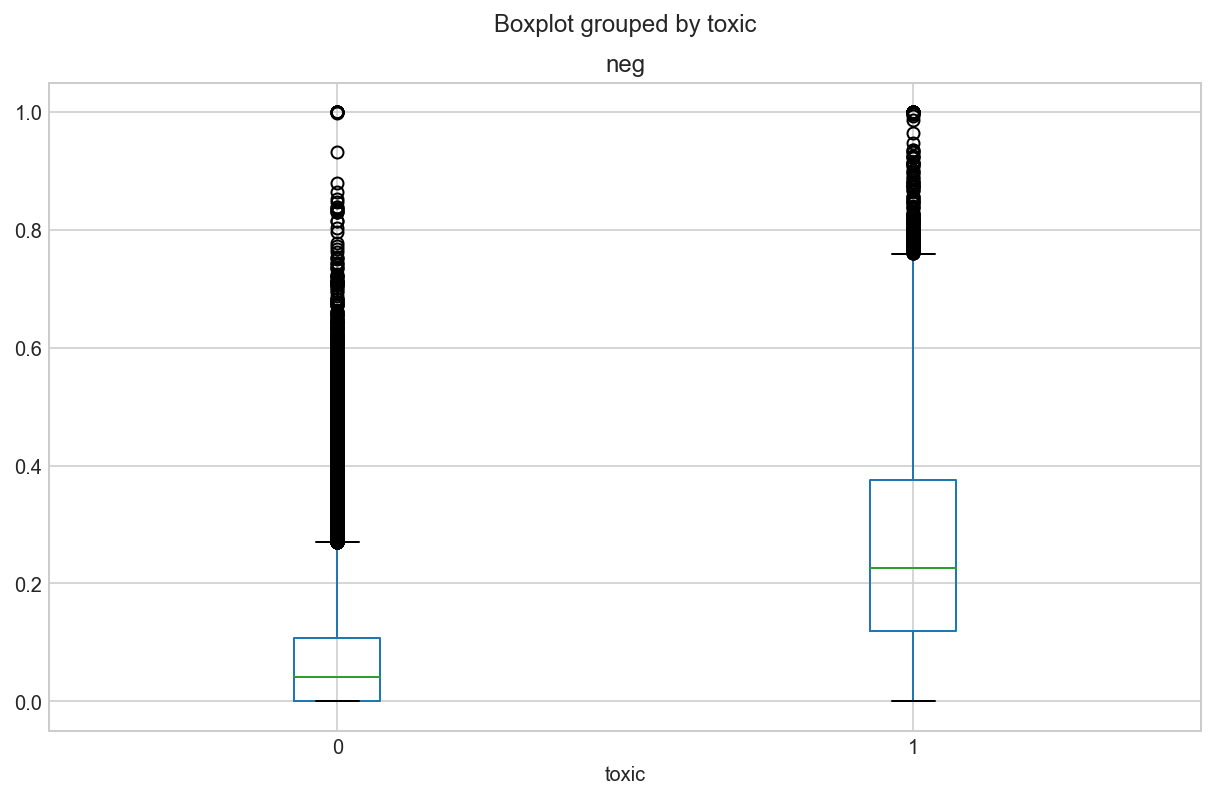

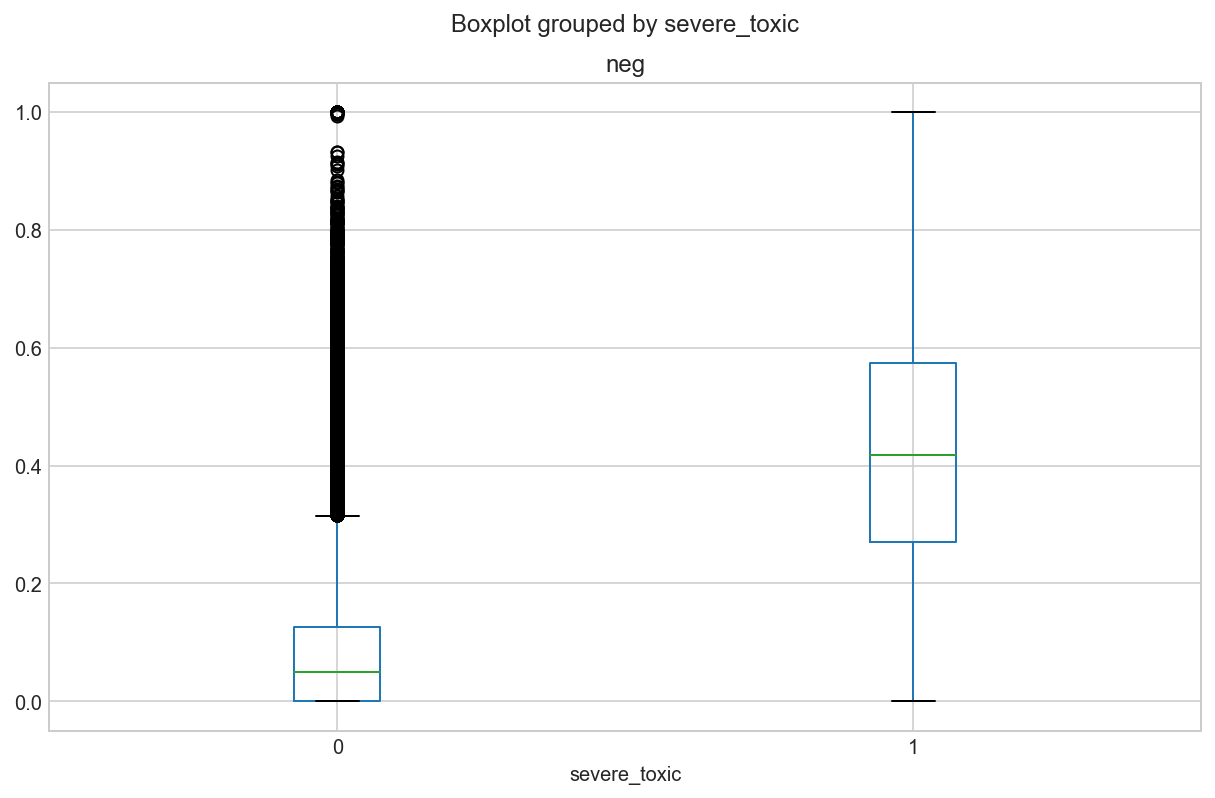

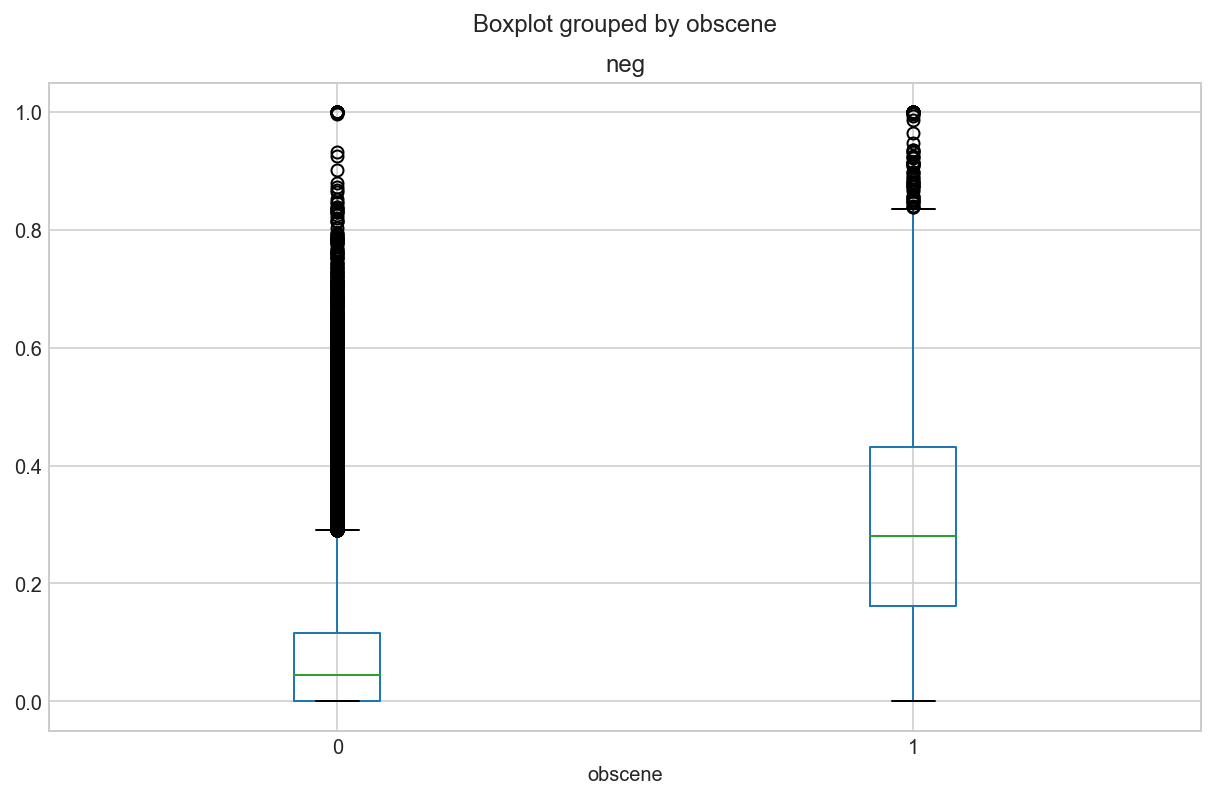

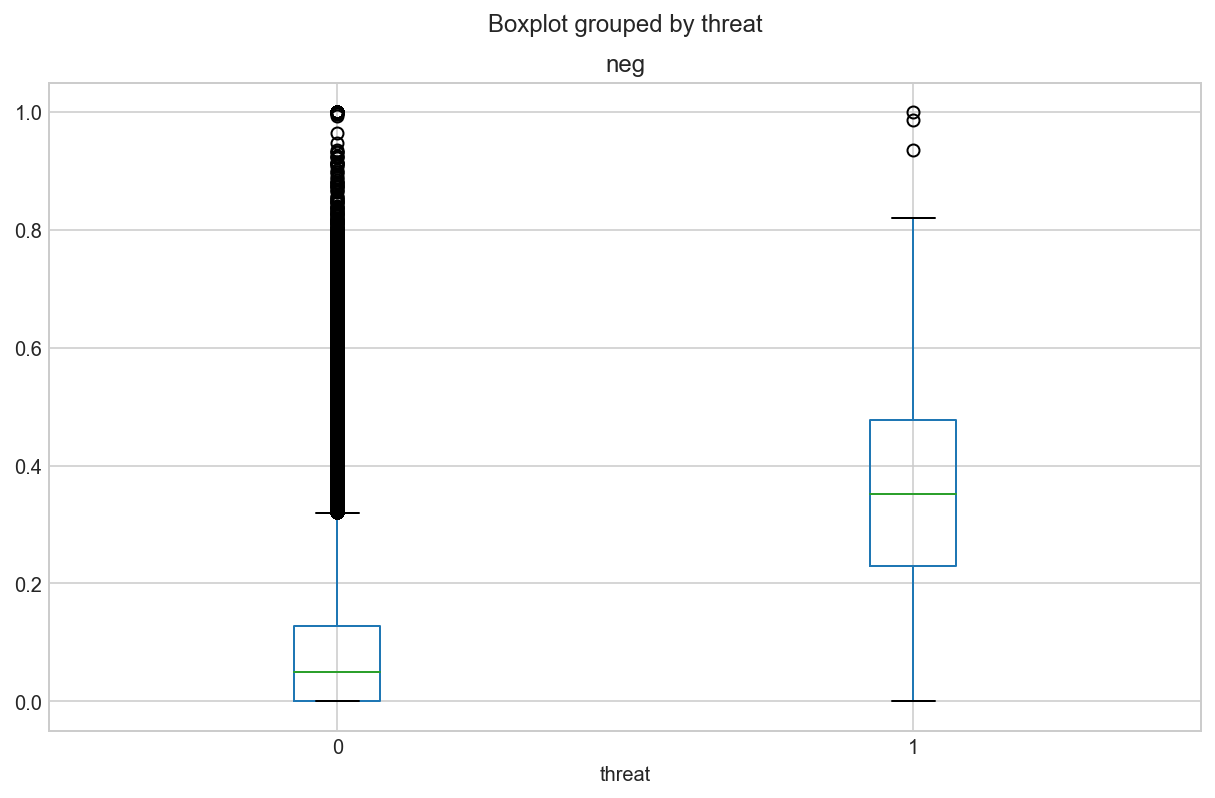

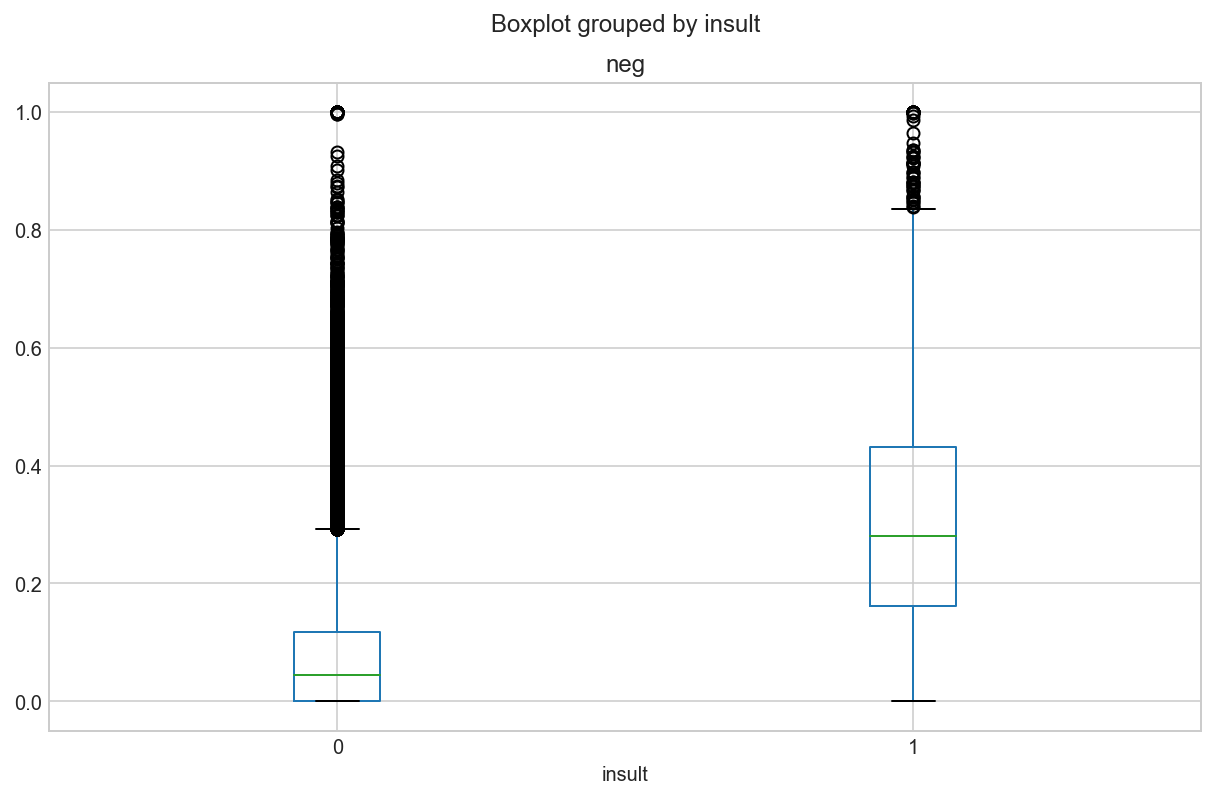

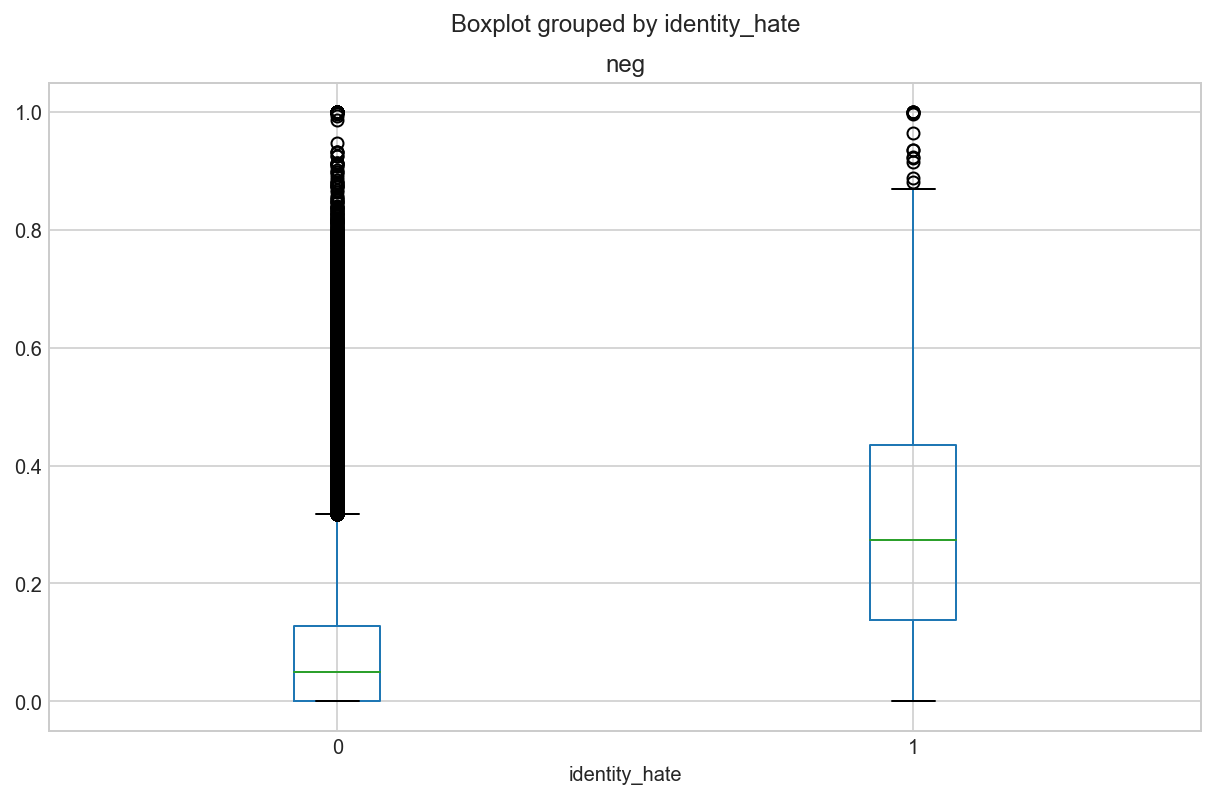

In [32]:
#toxic comments more negative
for label in labels:
    train_senti.boxplot(column='neg', by=label, figsize=(10,6))
    plt.show()

Most wiki comments are neutral. toxicity is really different in terms of negativity. To incorporate vader sentiment (compound) as a feature, omit the rest due to collinearity issue.

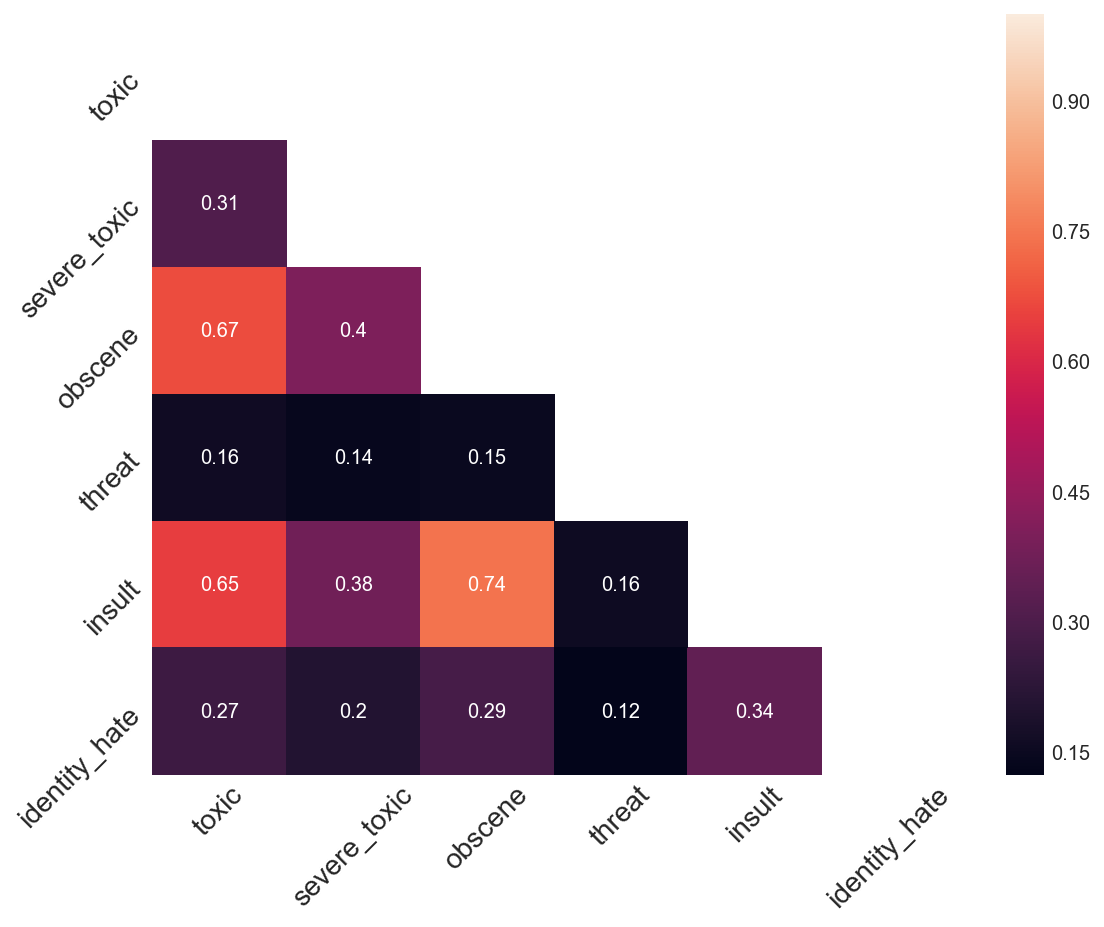

In [33]:
corr = train_senti[labels].corr(method='spearman')
# Set the default matplotlib figure size:
fig, ax = plt.subplots(figsize=(9,7))
# Generate a mask for the upper triangle (taken from seaborn example gallery)
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
# Plot the heatmap with seaborn.
# Assign the matplotlib axis the function returns. This will let us resize the labels.
ax = sns.heatmap(corr, mask=mask, ax=ax, annot=True)
# Resize the labels.
ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=14 , rotation=45)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=14 , rotation=45)
# If you put plt.show() at the bottom, it prevents those useless printouts from matplotlib.
plt.show()

#obscene-insult-toxic are strongly correlated

## Model Building

Two-step model where <br>
1st-step: Predicting whether comment is negative/labelled (0,1). <br>
2nd-step: From the predicted negative comment, identify type of toxicity associated (6).

### Creating train Xs & Ys

#### Creating train Ys

In [34]:
#creating Y for step 1 of model
train_senti['neg'] = train_senti[labels].sum(axis=1)
train_senti['neg'] = train_senti['neg'].map(lambda x: 1 if x > 0 else 0)
#reset train_y1 index
y_train1_csr = train_senti['neg'].reset_index(drop=True)

In [35]:
#creating Y for step 2 of model
#reset train_y2 index
y_train2_csr = train_senti[train_senti['neg']==1][labels].reset_index(drop=True)

In [36]:
import nltk
from nltk.stem import SnowballStemmer
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
snowball_stemmer = SnowballStemmer("english")
def snowball_stem(text):
    return [snowball_stemmer.stem(w) for w in w_tokenizer.tokenize(text)]
train_senti['comment_text'] = train_senti['comment_text'].apply(snowball_stem)
train_senti['comment_text'] = train_senti['comment_text'].apply(lambda x: " ".join(x))

In [37]:
# import nltk
# w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
# lemmatizer = nltk.stem.WordNetLemmatizer()
# def lemmatize_text(text):
#     return [lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)]
# train_senti['comment_text'] = train_senti['comment_text'].apply(lemmatize_text)
# train_senti['comment_text'] = train_senti['comment_text'].apply(lambda x: " ".join(x))

#### Creating train Xs

In [38]:
#creating predictor Xs pipeline
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer

    
pipe_text = Pipeline([
    ('vect', CountVectorizer(max_features=150000, strip_accents='unicode', stop_words='english', ngram_range=(1,2), max_df=0.9, min_df=1)),
    ('tfidf', TfidfTransformer()),
])

#creating pipes for model step 1 & 2
pipe_text1 = pipe_text.fit(train_senti['comment_text'])
pipe_text2 = pipe_text.fit(train_senti[train_senti['neg']==1]['comment_text'])

#port stemming causes RecursionError: maximum recursion depth exceeded in comparison, upon applying. iteration one by one takes too much time.
#use snowball stemming instead

In [39]:
#vectorising text features
train1_cvect = pipe_text1.transform(train_senti['comment_text'])
train2_cvect = pipe_text2.transform(train_senti[train_senti['neg']==1]['comment_text'])

In [40]:
#standardizing non-text features
from sklearn.preprocessing import StandardScaler
train1_nontext_ss = StandardScaler().fit_transform(train_senti[['text_len','unique_text','spam_inv_ratio','compound']])
train2_nontext_ss = StandardScaler().fit_transform(train_senti[train_senti['neg']==1][['text_len','unique_text','spam_inv_ratio','compound']])

In [41]:
import scipy as sp
X_train1_csr = sp.sparse.hstack((train1_cvect,train1_nontext_ss),format='csr')
X_train2_csr = sp.sparse.hstack((train2_cvect,train2_nontext_ss),format='csr')
print (X_train1_csr.shape)
print (y_train1_csr.shape)
print (X_train2_csr.shape)
print (y_train2_csr.shape)

(127656, 150004)
(127656,)
(12981, 150004)
(12981, 6)


### Create test functions & pipeline

In [42]:
#functions for non-text feature engineering
#clean
def text_clean(df, text_col):
    import re
    df[text_col] = df[text_col].apply(lambda x: re.sub(',', '', x)) #replace commas without space to prevent additional spaces in sentences
    df[text_col] = df[text_col].apply(lambda x: re.sub("'", '', x)) #replace ' next to get words like dont, wont, etc.
    df[text_col] = df[text_col].apply(lambda x: re.sub('[^ a-zA-Z0-9!]', ' ', x).lower()) #replace weird char without ! (!+  seems to appear quite abit in toxic comments) + lower case
    df[text_col] = df[text_col].apply(lambda x: " ".join(x.split())) #remove additional spaces
#text attributes
def text_attr(df, text_col):
    df['text_len'] = df[text_col].apply(lambda x: len(x.split()))
    df['unique_text'] = df[text_col].map(lambda x: len(set(x.split()))) #no. of unique words in text
    df['spam_inv_ratio'] = df['unique_text']/df['text_len'] #smaller ratio increase probability of spam
#sentiment attributes
def sentiment(df, text_col):
    from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
    analyzer = SentimentIntensityAnalyzer()
    senti_pol = df[text_col].apply(lambda x: analyzer.polarity_scores(x))
    senti_pol_df = pd.DataFrame(senti_pol)
    senti_pol_df = senti_pol_df[text_col].apply(pd.Series)
    df = pd.concat([df,senti_pol_df], axis=1)
    return df
#snowball stem text
import nltk
from nltk.stem import SnowballStemmer
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
snowball_stemmer = SnowballStemmer("english")
def snowball_stem(text):
    return [snowball_stemmer.stem(w) for w in w_tokenizer.tokenize(text)]

In [43]:
#clean and extract/transform features of test set using above functions
text_clean(test, 'comment_text')
text_attr(test, 'comment_text')
test_senti = sentiment(test, 'comment_text')
test_senti['comment_text'] = test_senti['comment_text'].apply(snowball_stem)
test_senti['comment_text'] = test_senti['comment_text'].apply(lambda x: " ".join(x))

#### Creating test Ys

In [44]:
#creating Y for step 1 of model
test_senti['neg'] = test_senti[labels].sum(axis=1)
test_senti['neg'] = test_senti['neg'].map(lambda x: 1 if x > 0 else 0)
#reset test_y1 index
y_test1_csr = test_senti['neg'].reset_index(drop=True)

In [45]:
#creating Y for step 2 of model
#reset test_y2 index
y_test2_csr = test_senti[test_senti['neg']==1][labels].reset_index(drop=True)

#### Creating test Xs

In [46]:
#vectorising text features
test1_cvect = pipe_text1.transform(test_senti['comment_text'])
test2_cvect = pipe_text2.transform(test_senti[test_senti['neg']==1]['comment_text'])

In [47]:
#standardizing non-text features
from sklearn.preprocessing import StandardScaler
#fit on training non-text features before transforming on test
test1_nontext_ss = StandardScaler().fit(train_senti[['text_len','unique_text','spam_inv_ratio','compound']]).transform(test_senti[['text_len','unique_text','spam_inv_ratio','compound']])
test2_nontext_ss = StandardScaler().fit(train_senti[train_senti['neg']==1][['text_len','unique_text','spam_inv_ratio','compound']]).transform(test_senti[test_senti['neg']==1][['text_len','unique_text','spam_inv_ratio','compound']])

In [48]:
import scipy as sp
X_test1_csr = sp.sparse.hstack((test1_cvect,test1_nontext_ss),format='csr')
X_test2_csr = sp.sparse.hstack((test2_cvect,test2_nontext_ss),format='csr')
print (X_test1_csr.shape)
print (y_test1_csr.shape)
print (X_test2_csr.shape)
print (y_test2_csr.shape)

(31915, 150004)
(31915,)
(3244, 150004)
(3244, 6)


### Model fitting & score

In [49]:
#write function to measure model performance
def model_performance(model, X_train, y_train, X_test, y_test):
    model.fit(X_train, y_train)
    Y_pp = pd.DataFrame(model.predict_proba(X_test), columns=['class_0_pp','class_1_pp'])
    #roc, auc for model for common performance measurement
    from sklearn.metrics import roc_curve, auc
    # For class 1, find the area under the curve.
    fpr, tpr, _ = roc_curve(y_test, Y_pp.class_1_pp)
    roc_auc = auc(fpr, tpr)
    # Plot of a ROC curve.
    plt.figure(figsize=[4,4])
    plt.plot(fpr, tpr, label='ROC curve (area = %0.2f)' % roc_auc, linewidth=4)
    plt.plot([0, 1], [0, 1], 'k--', linewidth=4)
    plt.xlim([-0.05, 1.0])
    plt.ylim([-0.05, 1.05])
    plt.xlabel('False Positive Rate', fontsize=18)
    plt.ylabel('True Positive Rate', fontsize=18)
    plt.title('Receiver operating characteristic for 1', fontsize=18)
    plt.legend(loc="lower right")
    plt.show()
    print ('auc:',roc_auc)
    
    from sklearn.metrics import confusion_matrix
    from sklearn.metrics import classification_report
    from sklearn import metrics
    
    #predict
    class_pred = model.predict(X_test)
    #confusion matrix and f1-score
    conmat = np.array(confusion_matrix(y_test, class_pred))
    confusion = pd.DataFrame(conmat, index=["class_0", "class_1"], 
                             columns=["predicted_0","predicted_1"])
    f1_score = metrics.f1_score(y_test, class_pred, average='weighted')
    precision_score = metrics.precision_score(y_test, class_pred, average='weighted')
    print ('')
    print ('Confusion Table:')
    print (confusion)
    print ('')
    print ('Classification Report:')
    print (classification_report(y_test, class_pred))
    print ('f1:',f1_score)
    print ('precision:',precision_score)
    return roc_auc, f1_score, precision_score

#### Model step 1

##### Naives bayes

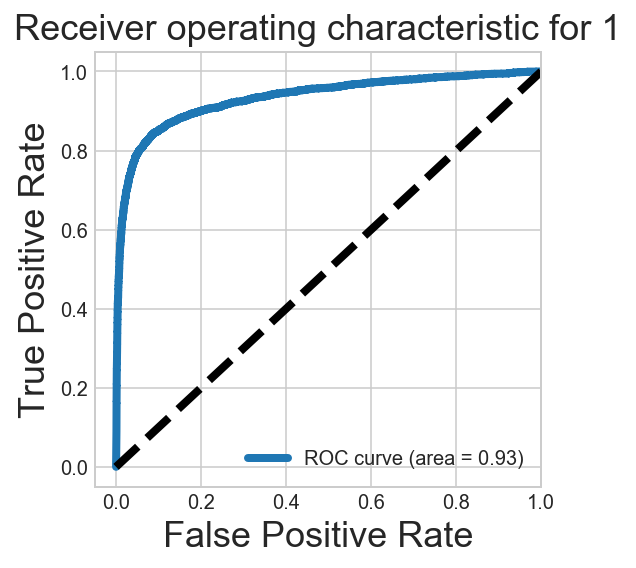

auc: 0.9337599072964381

Confusion Table:
         predicted_0  predicted_1
class_0        28587           84
class_1         2113         1131

Classification Report:
             precision    recall  f1-score   support

          0       0.93      1.00      0.96     28671
          1       0.93      0.35      0.51      3244

avg / total       0.93      0.93      0.92     31915

f1: 0.91667508944845
precision: 0.9311412869623219


In [50]:
#naives bayes
from sklearn.naive_bayes import BernoulliNB, GaussianNB
roc_auc, f1_score, precision_score = model_performance(BernoulliNB(), X_train1_csr, y_train1_csr, X_test1_csr, y_test1_csr)

##### Logistic reg

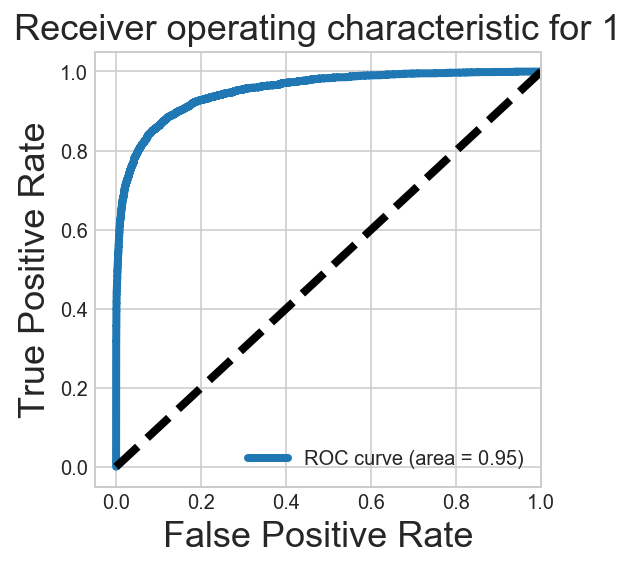

auc: 0.9516199684666139

Confusion Table:
         predicted_0  predicted_1
class_0        28508          163
class_1         1461         1783

Classification Report:
             precision    recall  f1-score   support

          0       0.95      0.99      0.97     28671
          1       0.92      0.55      0.69      3244

avg / total       0.95      0.95      0.94     31915

f1: 0.9433149128149656
precision: 0.9476909127227127


In [51]:
#logistic modelling
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
roc_auc, f1_score, precision_score = model_performance(LogisticRegression(), X_train1_csr, y_train1_csr, X_test1_csr, y_test1_csr)

##### Lasso logreg

In [ ]:
#Lasso logistic regression best C
lr_lasso = LogisticRegressionCV(penalty='l1', solver='liblinear', Cs=35, cv=3)
lr_lasso.fit(X_train1_csr, y_train1_csr)
print (lr_lasso.C_)

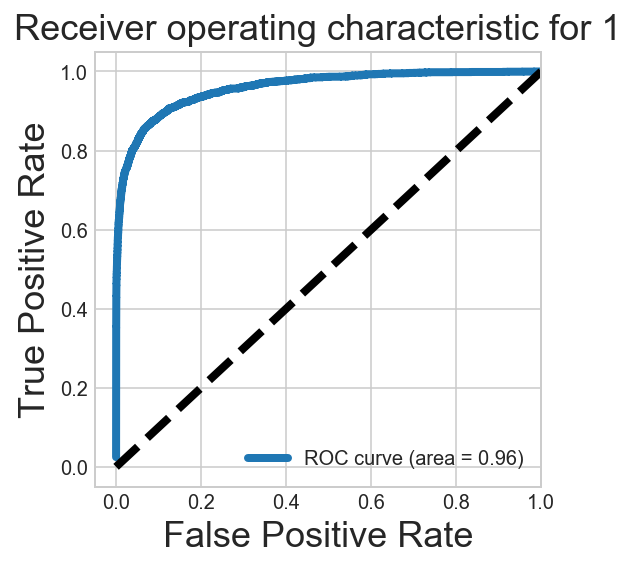

auc: 0.9591759155840047

Confusion Table:
         predicted_0  predicted_1
class_0        28310          361
class_1          981         2263

Classification Report:
             precision    recall  f1-score   support

          0       0.97      0.99      0.98     28671
          1       0.86      0.70      0.77      3244

avg / total       0.96      0.96      0.96     31915

f1: 0.9559542871349043
precision: 0.9559287947336667


In [53]:
#lasso logistic regression
#best C = 4.2813324, 2.95520924
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
lr_lasso = LogisticRegression(penalty='l1', solver='liblinear', C=4.2813324)
roc_auc, f1_score, precision_score = model_performance(lr_lasso, X_train1_csr, y_train1_csr, X_test1_csr, y_test1_csr)

###### Ridge logreg

In [ ]:
#ridge logistic regression best C
lr_ridge = LogisticRegressionCV(penalty='l2', Cs=20, cv=3)
lr_ridge.fit(X_train1_csr, y_train1_csr)
print (lr_ridge.C_)

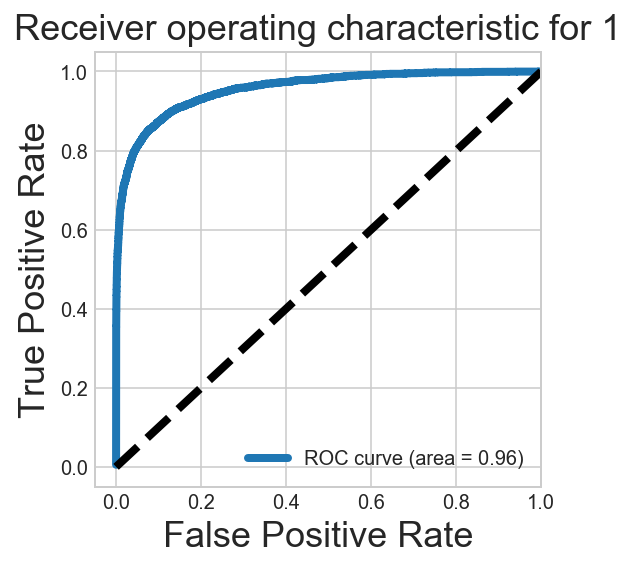

auc: 0.9554661560565006

Confusion Table:
         predicted_0  predicted_1
class_0        28435          236
class_1         1206         2038

Classification Report:
             precision    recall  f1-score   support

          0       0.96      0.99      0.98     28671
          1       0.90      0.63      0.74      3244

avg / total       0.95      0.95      0.95     31915

f1: 0.9512220022228198
precision: 0.9528998230967728


In [54]:
#ridge logistic regression
lr_ridge = LogisticRegression(penalty='l2', C=29.76351442)
roc_auc, f1_score, precision_score = model_performance(lr_ridge, X_train1_csr, y_train1_csr, X_test1_csr, y_test1_csr)

##### Randomforest

In [144]:
#use a randomized search due to large number of parameters
from sklearn.model_selection import RandomizedSearchCV
random_grid = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10]
}
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, scoring='roc_auc', n_iter = 10, cv = 3, verbose=2, random_state=42) #n_jobs = -1
# Fit the random search model
rf_random.fit(X_train1_csr, y_train1_csr)
print (rf_random.best_score_)
print (rf_random.best_estimator_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=True 
[CV]  min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=True, total=  16.6s
[CV] min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=True 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   17.4s remaining:    0.0s


[CV]  min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=True, total=  15.6s
[CV] min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=True 
[CV]  min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=True, total=  15.8s
[CV] min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False 
[CV]  min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False, total=  24.2s
[CV] min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False 
[CV]  min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False, total=  24.2s
[CV] min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False 
[CV]  min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False, total=  24.8s
[CV] min_samples_split=5, min_samples_leaf=4, max_features=sqrt,

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed: 35.5min finished


0.9511234465586342
RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


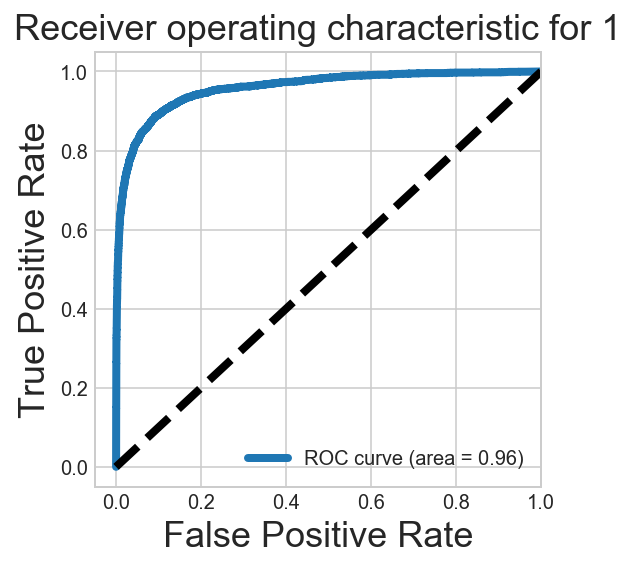

auc: 0.957947724344654

Confusion Table:
         predicted_0  predicted_1
class_0        28571          100
class_1         1667         1577

Classification Report:
             precision    recall  f1-score   support

          0       0.94      1.00      0.97     28671
          1       0.94      0.49      0.64      3244

avg / total       0.94      0.94      0.94     31915

f1: 0.9365554576881973
precision: 0.9444131899415209


In [58]:
#random forest
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
roc_auc, f1_score, precision_score = model_performance(rf, X_train1_csr, y_train1_csr, X_test1_csr, y_test1_csr)

##### XGBoost

In [147]:
#use a randomized search due to large number of parameters
random_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

xgb = XGBClassifier()

# search across 100 different combinations, and use all available cores
xgb_random = RandomizedSearchCV(estimator = xgb, param_distributions = random_grid, scoring='roc_auc', n_jobs=4, n_iter = 10, cv = 3, verbose=2) #n_jobs = -1
# Fit the random search model
xgb_random.fit(X_train1_csr, y_train1_csr)
print (xgb_random.best_score_)
print (xgb_random.best_estimator_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed: 25.4min finished


0.9385848301000773
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1.0, gamma=0.5, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=5, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.6)


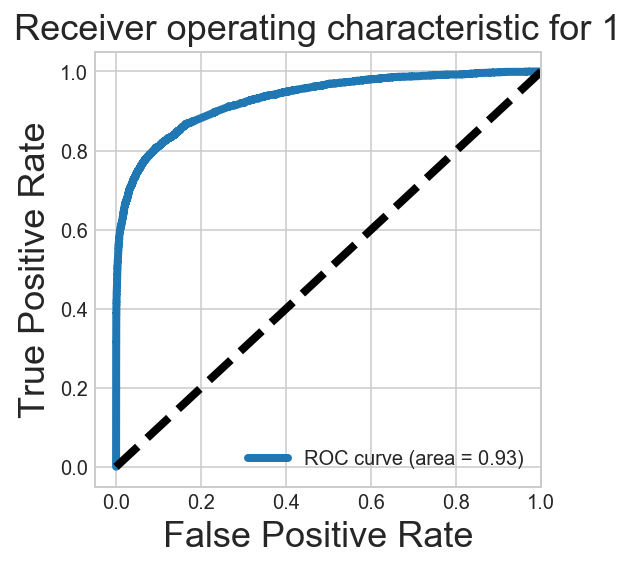

auc: 0.9311220095869717

Confusion Table:
         predicted_0  predicted_1
class_0        28567          104
class_1         1577         1667

Classification Report:
             precision    recall  f1-score   support

          0       0.95      1.00      0.97     28671
          1       0.94      0.51      0.66      3244

avg / total       0.95      0.95      0.94     31915

f1: 0.9402531513337193
precision: 0.9470330730313223


C:\Users\Samson\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


In [59]:
#xgb
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1.0, gamma=0.5, learning_rate=0.1,
       max_delta_step=0, max_depth=5, min_child_weight=5, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=0.6)
roc_auc, f1_score, precision_score = model_performance(xgb, X_train1_csr, y_train1_csr, X_test1_csr, y_test1_csr)

Lasso log reg performs the best for model step 1 <br>
auc: 0.96 <br>
negative recall: 0.69 <br>
negative f1: 0.77 <br>
the other models (including ensembles): recall avg around 0.5+ and f1 0.65 <br>
only ridge log reg comes close with recall of 0.63 and f1 of 0.74. <br>

#### Model step 2

##### Naives bayes

toxic


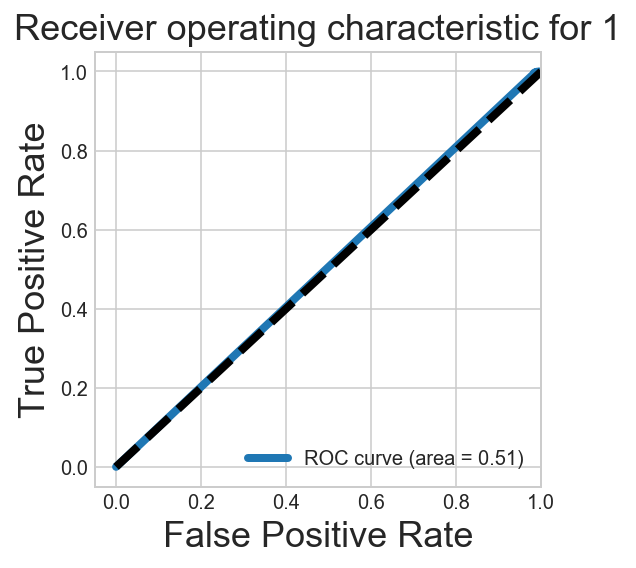

auc: 0.5058665548067283

Confusion Table:
         predicted_0  predicted_1
class_0            2          186
class_1            7         3049

Classification Report:
             precision    recall  f1-score   support

          0       0.22      0.01      0.02       188
          1       0.94      1.00      0.97      3056

avg / total       0.90      0.94      0.91      3244

f1: 0.9143227517808461
precision: 0.9007612780900096
severe_toxic


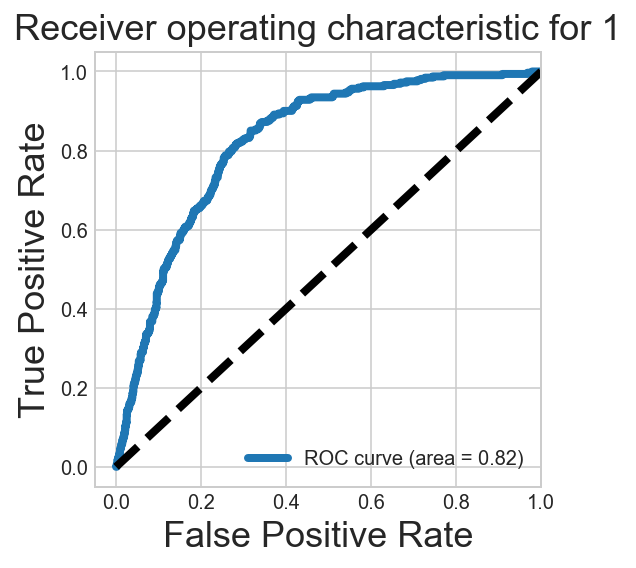

auc: 0.8239795456168343

Confusion Table:
         predicted_0  predicted_1
class_0         2919            4
class_1          320            1

Classification Report:
             precision    recall  f1-score   support

          0       0.90      1.00      0.95      2923
          1       0.20      0.00      0.01       321

avg / total       0.83      0.90      0.85      3244

f1: 0.8542777489090834
precision: 0.8318185919220473
obscene


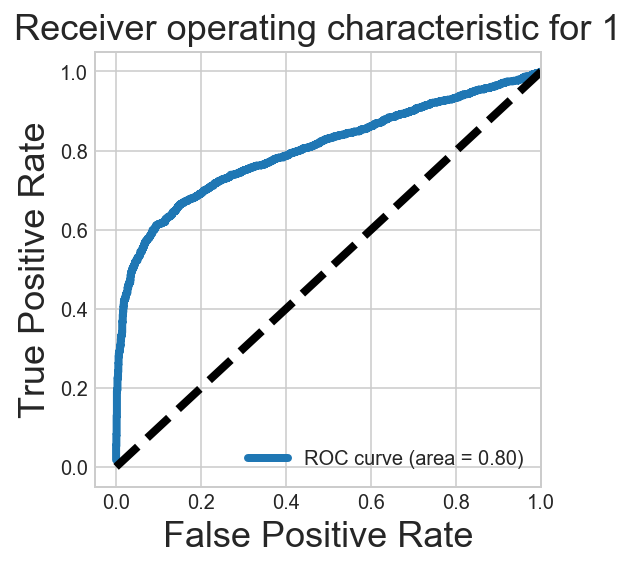

auc: 0.8027139062669821

Confusion Table:
         predicted_0  predicted_1
class_0          427         1102
class_1          152         1563

Classification Report:
             precision    recall  f1-score   support

          0       0.74      0.28      0.41      1529
          1       0.59      0.91      0.71      1715

avg / total       0.66      0.61      0.57      3244

f1: 0.5682573172079816
precision: 0.6576564460970291
threat


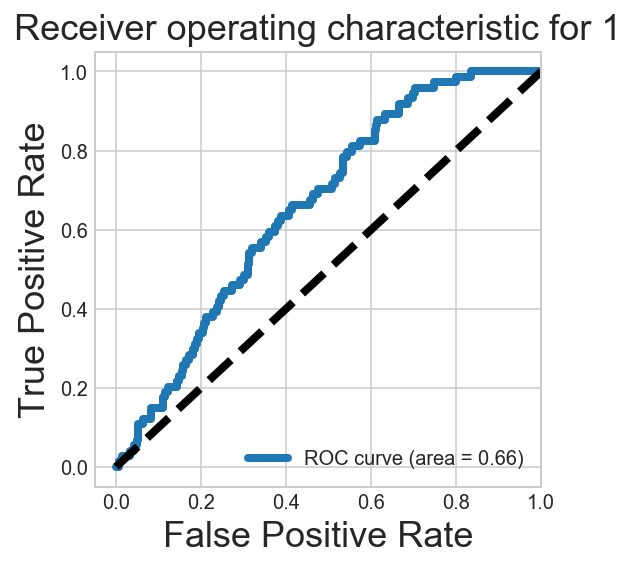

auc: 0.6614204109472248

Confusion Table:
         predicted_0  predicted_1
class_0         3167            3
class_1           74            0

Classification Report:
             precision    recall  f1-score   support

          0       0.98      1.00      0.99      3170
          1       0.00      0.00      0.00        74

avg / total       0.95      0.98      0.97      3244

f1: 0.9654520272935639
precision: 0.9548770359424619
insult


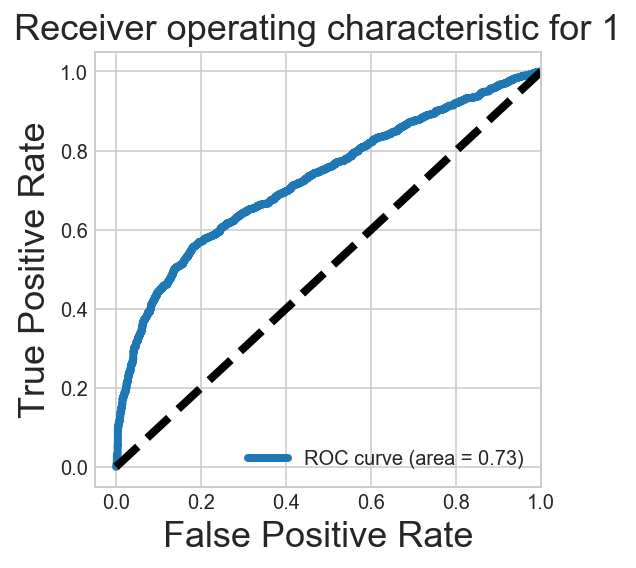

auc: 0.7259466630176143

Confusion Table:
         predicted_0  predicted_1
class_0          536         1094
class_1          227         1387

Classification Report:
             precision    recall  f1-score   support

          0       0.70      0.33      0.45      1630
          1       0.56      0.86      0.68      1614

avg / total       0.63      0.59      0.56      3244

f1: 0.5621265507789242
precision: 0.6311232100986175
identity_hate


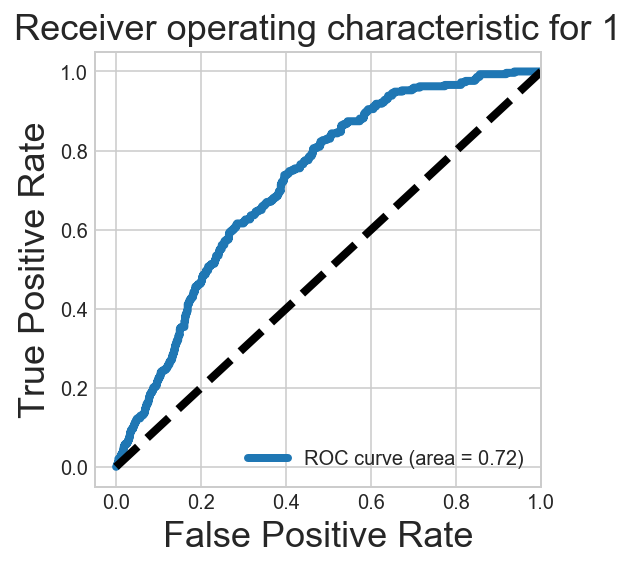

auc: 0.7207690533840655

Confusion Table:
         predicted_0  predicted_1
class_0         2944            6
class_1          293            1

Classification Report:
             precision    recall  f1-score   support

          0       0.91      1.00      0.95      2950
          1       0.14      0.00      0.01       294

avg / total       0.84      0.91      0.87      3244

f1: 0.8660260273150465
precision: 0.8400055690846474


toxic  severe_toxic   obscene    threat    insult  identity_hate
auc    0.505867      0.823980  0.802714  0.661420  0.725947       0.720769
f1     0.914323      0.854278  0.568257  0.965452  0.562127       0.866026
presc  0.900761      0.831819  0.657656  0.954877  0.631123       0.840006

In [55]:
#naives bayes
from sklearn.naive_bayes import BernoulliNB, GaussianNB

auc_ls = []
f1_ls = []
precision_ls = []
for label in labels:
    print (label)
    roc_auc, f1_score, precision_score = model_performance(BernoulliNB(), X_train2_csr, y_train2_csr[label], X_test2_csr, y_test2_csr[label])
    auc_ls.append(roc_auc)
    f1_ls.append(f1_score)
    precision_ls.append(precision_score)
scores = [auc_ls, f1_ls, precision_ls]
metrics = pd.DataFrame(scores, columns=labels, index=(['auc','f1','presc']))
metrics

##### Logistic reg

toxic


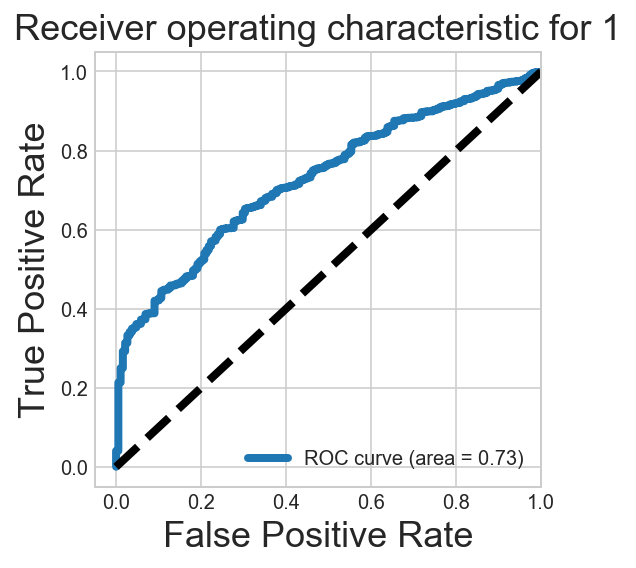

auc: 0.7286146193048904

Confusion Table:
         predicted_0  predicted_1
class_0            0          188
class_1            1         3055

Classification Report:
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       188
          1       0.94      1.00      0.97      3056

avg / total       0.89      0.94      0.91      3244

f1: 0.9137809634120775
precision: 0.8874354438070731
severe_toxic


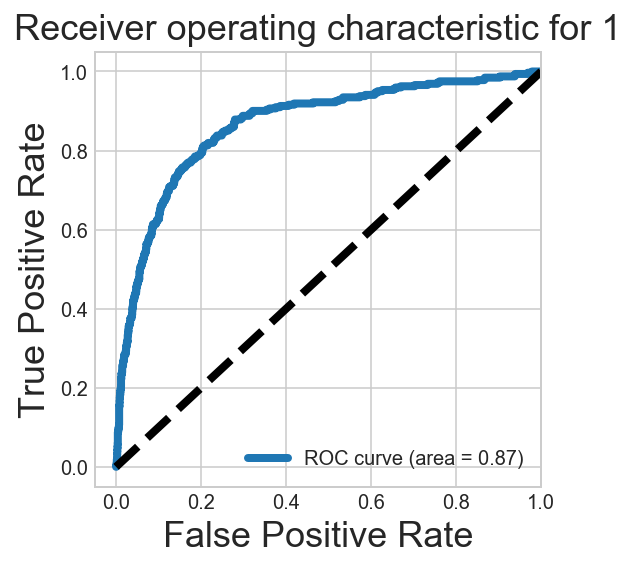

auc: 0.865562948492086

Confusion Table:
         predicted_0  predicted_1
class_0         2884           39
class_1          245           76

Classification Report:
             precision    recall  f1-score   support

          0       0.92      0.99      0.95      2923
          1       0.66      0.24      0.35       321

avg / total       0.90      0.91      0.89      3244

f1: 0.8932619298306071
precision: 0.8958905315504845
obscene


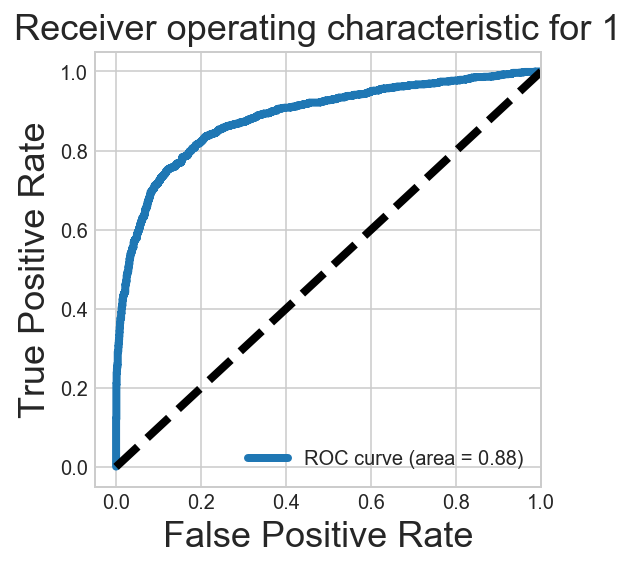

auc: 0.8846291426969742

Confusion Table:
         predicted_0  predicted_1
class_0         1353          176
class_1          443         1272

Classification Report:
             precision    recall  f1-score   support

          0       0.75      0.88      0.81      1529
          1       0.88      0.74      0.80      1715

avg / total       0.82      0.81      0.81      3244

f1: 0.8087938023183348
precision: 0.8194836557161957
threat


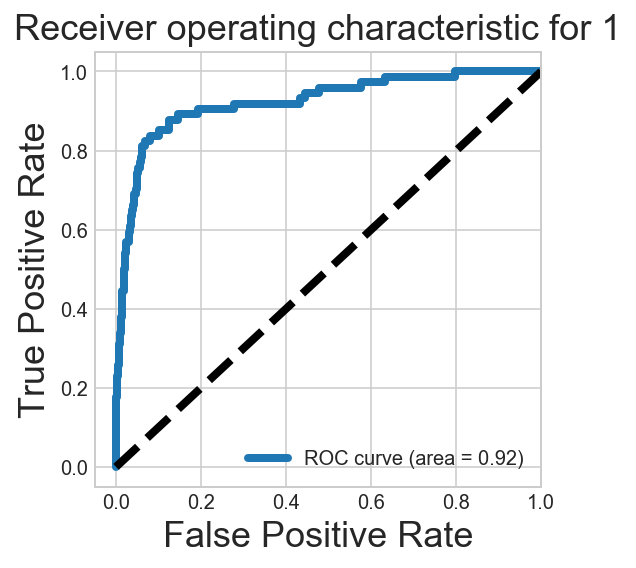

auc: 0.9237232500639441

Confusion Table:
         predicted_0  predicted_1
class_0         3167            3
class_1           65            9

Classification Report:
             precision    recall  f1-score   support

          0       0.98      1.00      0.99      3170
          1       0.75      0.12      0.21        74

avg / total       0.97      0.98      0.97      3244

f1: 0.9715837374215447
precision: 0.9746445456043754
insult


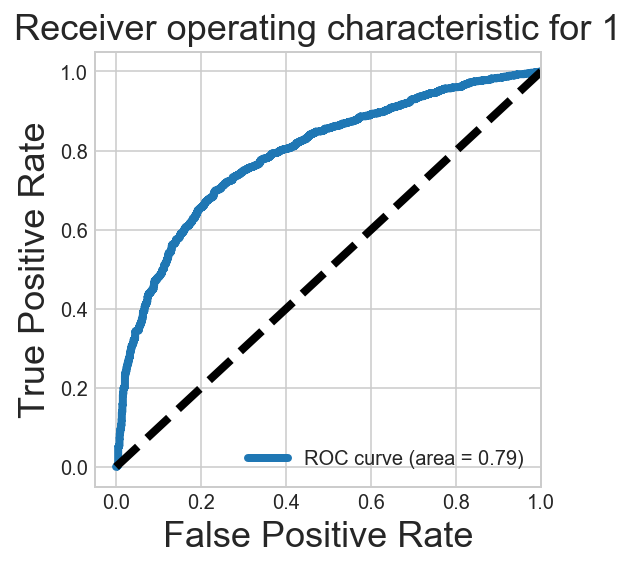

auc: 0.7904178164982781

Confusion Table:
         predicted_0  predicted_1
class_0         1300          330
class_1          553         1061

Classification Report:
             precision    recall  f1-score   support

          0       0.70      0.80      0.75      1630
          1       0.76      0.66      0.71      1614

avg / total       0.73      0.73      0.73      3244

f1: 0.726419110363606
precision: 0.7320119029120568
identity_hate


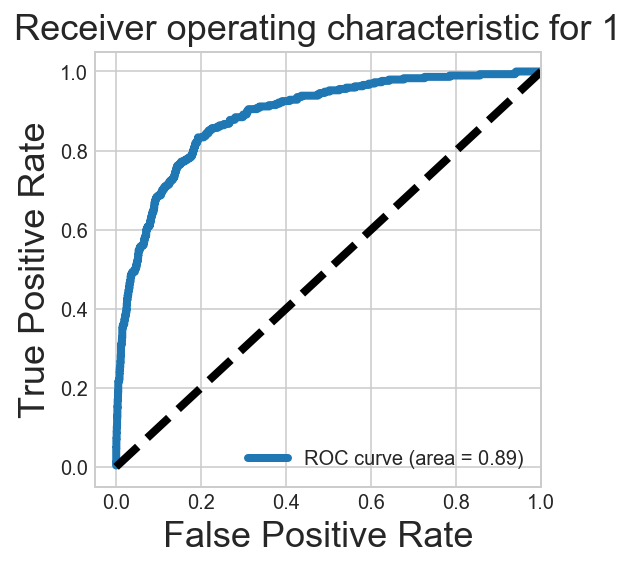

auc: 0.8874322610400093

Confusion Table:
         predicted_0  predicted_1
class_0         2935           15
class_1          235           59

Classification Report:
             precision    recall  f1-score   support

          0       0.93      0.99      0.96      2950
          1       0.80      0.20      0.32       294

avg / total       0.91      0.92      0.90      3244

f1: 0.9012839713880156
precision: 0.9142153371363717


toxic  severe_toxic   obscene    threat    insult  identity_hate
auc    0.728615      0.865563  0.884629  0.923723  0.790418       0.887432
f1     0.913781      0.893262  0.808794  0.971584  0.726419       0.901284
presc  0.887435      0.895891  0.819484  0.974645  0.732012       0.914215

In [57]:
#logistic modelling
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

auc_ls = []
f1_ls = []
precision_ls = []
for label in labels:
    print (label)
    roc_auc, f1_score, precision_score = model_performance(LogisticRegression(), X_train2_csr, y_train2_csr[label], X_test2_csr, y_test2_csr[label])
    auc_ls.append(roc_auc)
    f1_ls.append(f1_score)
    precision_ls.append(precision_score)
scores = [auc_ls, f1_ls, precision_ls]
metrics = pd.DataFrame(scores, columns=labels, index=(['auc','f1','presc']))
metrics

##### Lasso logreg

toxic


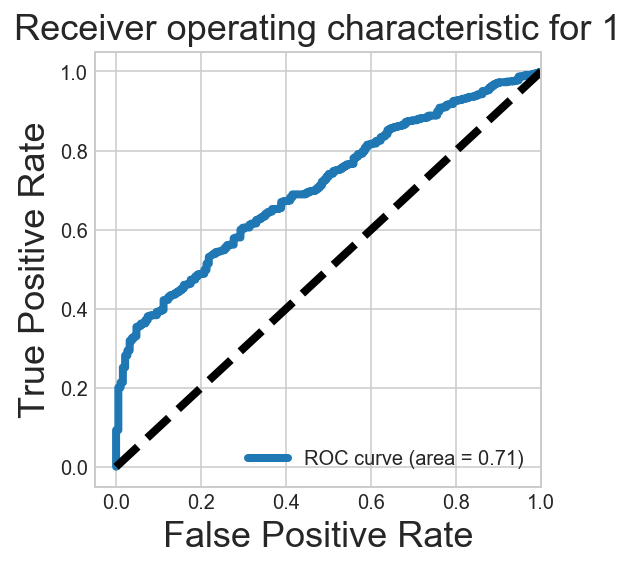

auc: 0.7091917191155175

Confusion Table:
         predicted_0  predicted_1
class_0            0          188
class_1            1         3055

Classification Report:
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       188
          1       0.94      1.00      0.97      3056

avg / total       0.89      0.94      0.91      3244

f1: 0.9137809634120775
precision: 0.8874354438070731
severe_toxic


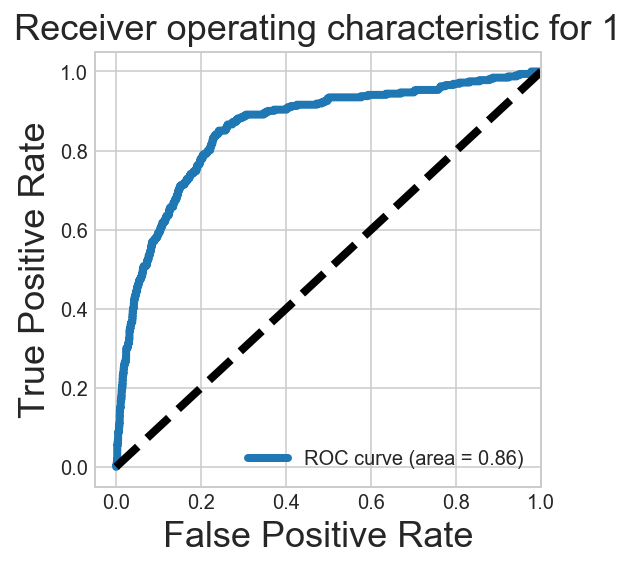

auc: 0.8552350410270675

Confusion Table:
         predicted_0  predicted_1
class_0         2857           66
class_1          235           86

Classification Report:
             precision    recall  f1-score   support

          0       0.92      0.98      0.95      2923
          1       0.57      0.27      0.36       321

avg / total       0.89      0.91      0.89      3244

f1: 0.891940747466237
precision: 0.8885520525000217
obscene


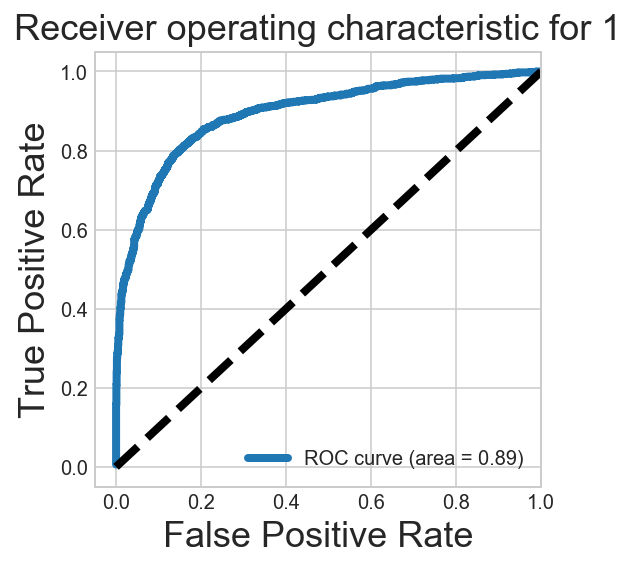

auc: 0.8945882043371399

Confusion Table:
         predicted_0  predicted_1
class_0         1335          194
class_1          390         1325

Classification Report:
             precision    recall  f1-score   support

          0       0.77      0.87      0.82      1529
          1       0.87      0.77      0.82      1715

avg / total       0.83      0.82      0.82      3244

f1: 0.8199418093226113
precision: 0.8259188611016475
threat


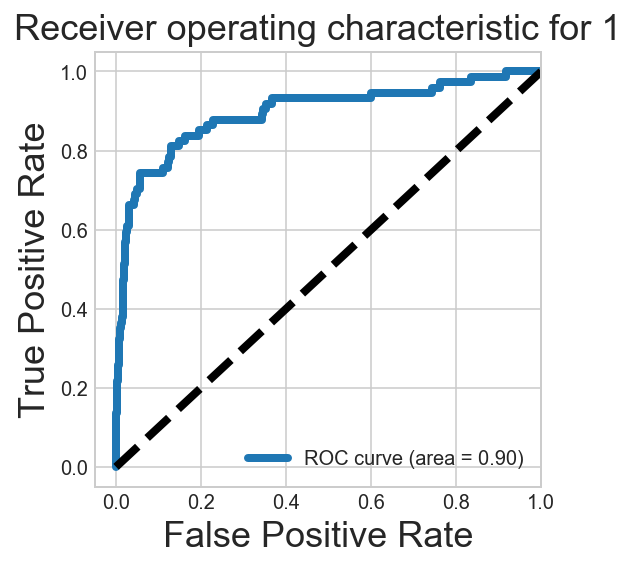

auc: 0.8961122005286043

Confusion Table:
         predicted_0  predicted_1
class_0         3142           28
class_1           50           24

Classification Report:
             precision    recall  f1-score   support

          0       0.98      0.99      0.99      3170
          1       0.46      0.32      0.38        74

avg / total       0.97      0.98      0.97      3244

f1: 0.9738980701112905
precision: 0.9724101287554464
insult


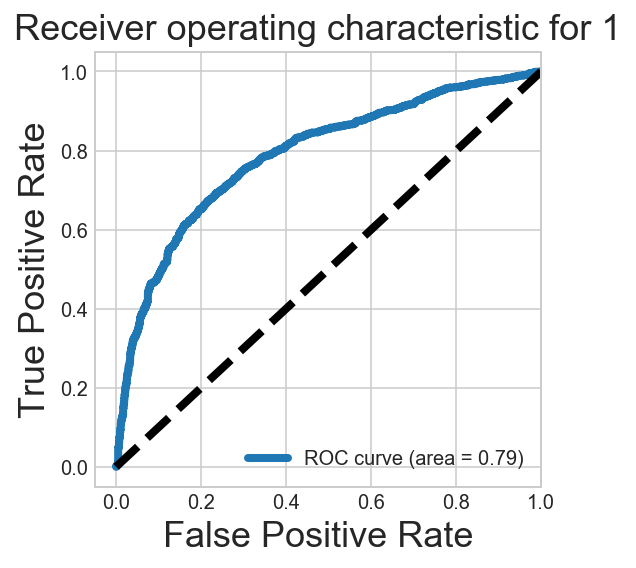

auc: 0.7891982347709079

Confusion Table:
         predicted_0  predicted_1
class_0         1257          373
class_1          511         1103

Classification Report:
             precision    recall  f1-score   support

          0       0.71      0.77      0.74      1630
          1       0.75      0.68      0.71      1614

avg / total       0.73      0.73      0.73      3244

f1: 0.726945361691492
precision: 0.7290418504520646
identity_hate


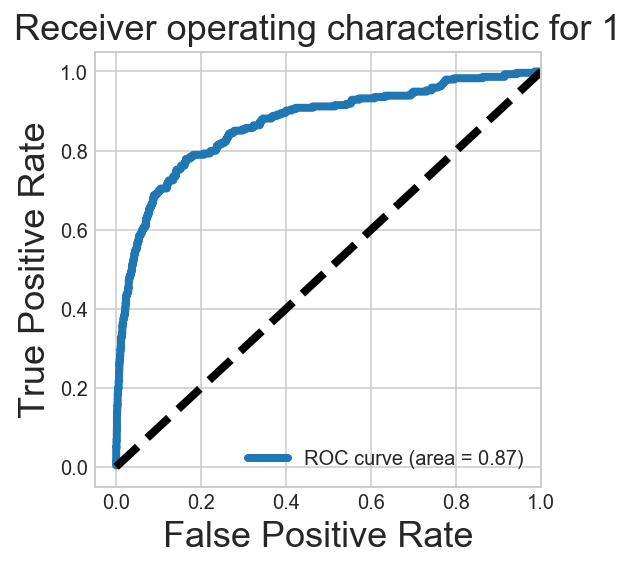

auc: 0.8673037011414736

Confusion Table:
         predicted_0  predicted_1
class_0         2899           51
class_1          184          110

Classification Report:
             precision    recall  f1-score   support

          0       0.94      0.98      0.96      2950
          1       0.68      0.37      0.48       294

avg / total       0.92      0.93      0.92      3244

f1: 0.9177694767683492
precision: 0.9170182762683331


toxic  severe_toxic   obscene    threat    insult  identity_hate
auc    0.709192      0.855235  0.894588  0.896112  0.789198       0.867304
f1     0.913781      0.891941  0.819942  0.973898  0.726945       0.917769
presc  0.887435      0.888552  0.825919  0.972410  0.729042       0.917018

In [58]:
#lasso logistic modelling
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV

auc_ls = []
f1_ls = []
precision_ls = []
for label in labels:
    print (label)
    roc_auc, f1_score, precision_score = model_performance(LogisticRegression(penalty='l1', solver='liblinear'), X_train2_csr, y_train2_csr[label], X_test2_csr, y_test2_csr[label])
    auc_ls.append(roc_auc)
    f1_ls.append(f1_score)
    precision_ls.append(precision_score)
scores = [auc_ls, f1_ls, precision_ls]
metrics = pd.DataFrame(scores, columns=labels, index=(['auc','f1','presc']))
metrics

##### Ridge logreg

toxic


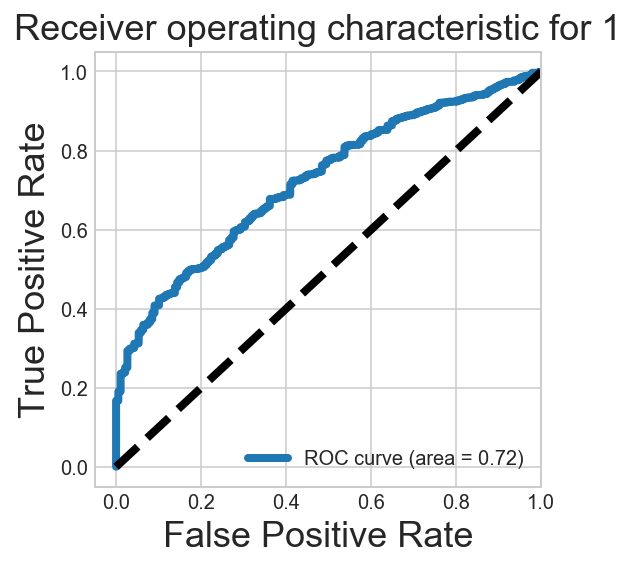

auc: 0.7230744193494486

Confusion Table:
         predicted_0  predicted_1
class_0            1          187
class_1            8         3048

Classification Report:
             precision    recall  f1-score   support

          0       0.11      0.01      0.01       188
          1       0.94      1.00      0.97      3056

avg / total       0.89      0.94      0.91      3244

f1: 0.9134349046490416
precision: 0.8940308352460045
severe_toxic


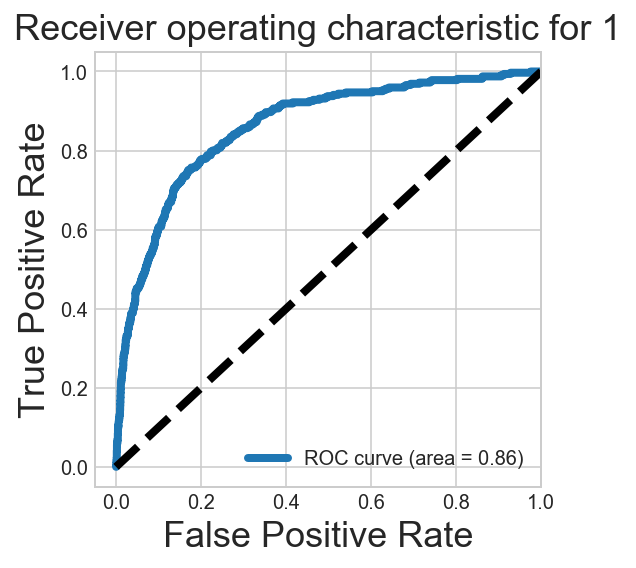

auc: 0.8600454233957132

Confusion Table:
         predicted_0  predicted_1
class_0         2857           66
class_1          220          101

Classification Report:
             precision    recall  f1-score   support

          0       0.93      0.98      0.95      2923
          1       0.60      0.31      0.41       321

avg / total       0.90      0.91      0.90      3244

f1: 0.8990577324762654
precision: 0.8964699288787855
obscene


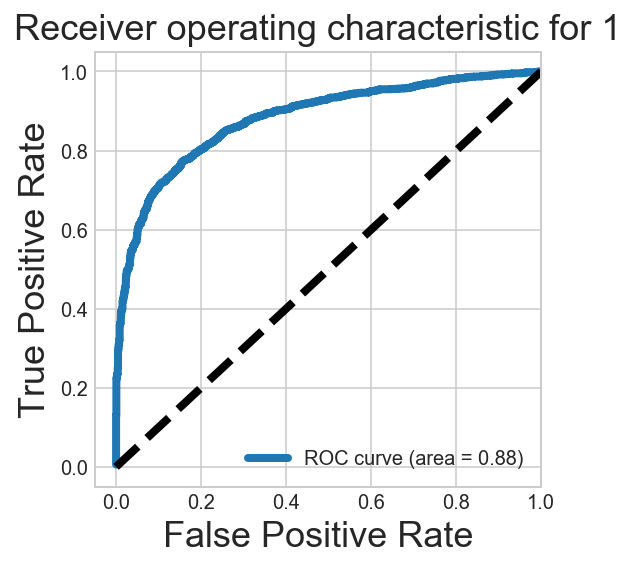

auc: 0.881609199785679

Confusion Table:
         predicted_0  predicted_1
class_0         1295          234
class_1          401         1314

Classification Report:
             precision    recall  f1-score   support

          0       0.76      0.85      0.80      1529
          1       0.85      0.77      0.81      1715

avg / total       0.81      0.80      0.80      3244

f1: 0.8043130297023335
precision: 0.8086439806989675
threat


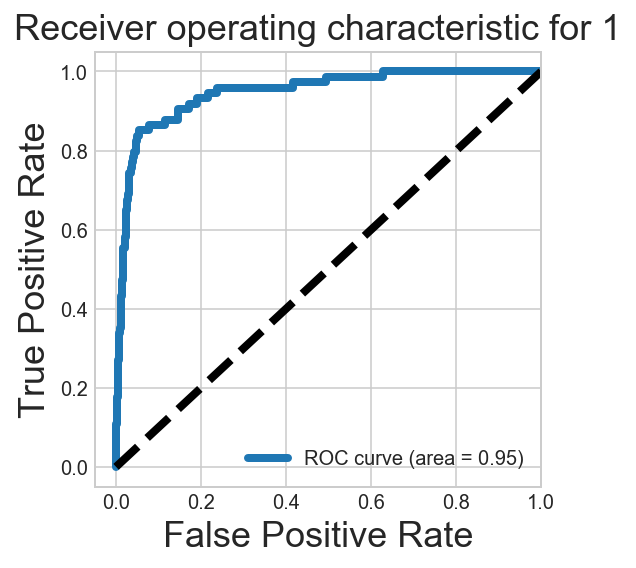

auc: 0.9481626737147242

Confusion Table:
         predicted_0  predicted_1
class_0         3152           18
class_1           54           20

Classification Report:
             precision    recall  f1-score   support

          0       0.98      0.99      0.99      3170
          1       0.53      0.27      0.36        74

avg / total       0.97      0.98      0.97      3244

f1: 0.9743008118563339
precision: 0.9727354289427551
insult


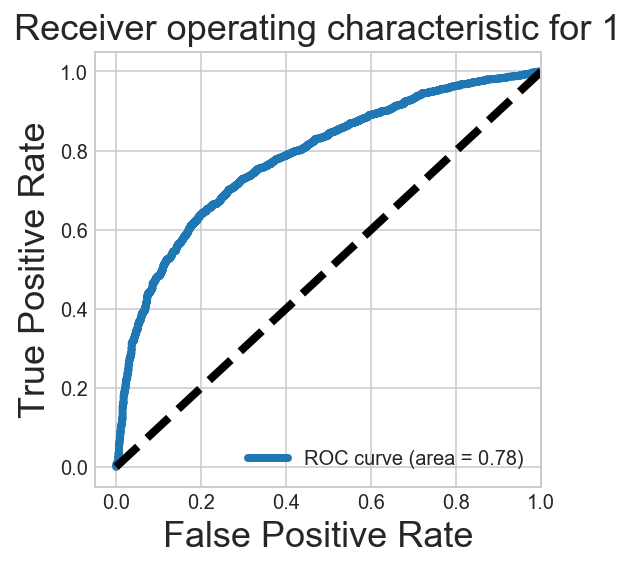

auc: 0.7822865114298965

Confusion Table:
         predicted_0  predicted_1
class_0         1230          400
class_1          528         1086

Classification Report:
             precision    recall  f1-score   support

          0       0.70      0.75      0.73      1630
          1       0.73      0.67      0.70      1614

avg / total       0.72      0.71      0.71      3244

f1: 0.713431379956831
precision: 0.7151630004593101
identity_hate


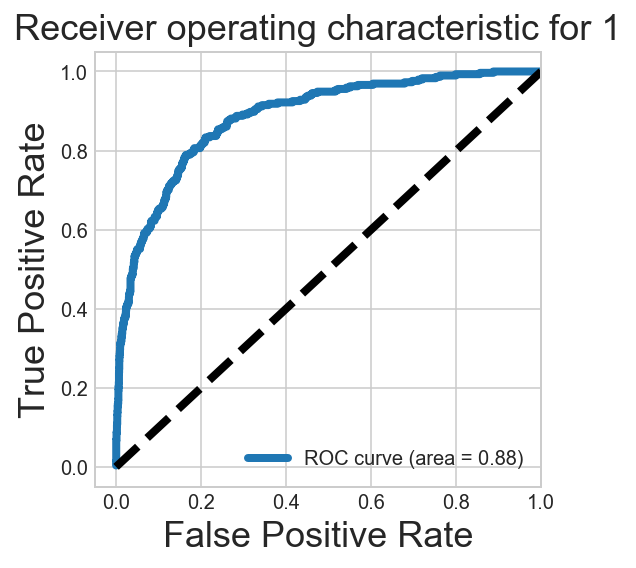

auc: 0.884977516430301

Confusion Table:
         predicted_0  predicted_1
class_0         2902           48
class_1          189          105

Classification Report:
             precision    recall  f1-score   support

          0       0.94      0.98      0.96      2950
          1       0.69      0.36      0.47       294

avg / total       0.92      0.93      0.92      3244

f1: 0.9162720885924655
precision: 0.9159636829850428


toxic  severe_toxic   obscene    threat    insult  identity_hate
auc    0.723074      0.860045  0.881609  0.948163  0.782287       0.884978
f1     0.913435      0.899058  0.804313  0.974301  0.713431       0.916272
presc  0.894031      0.896470  0.808644  0.972735  0.715163       0.915964

In [59]:
#ridge logistic modelling
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
LogisticRegression()
auc_ls = []
f1_ls = []
precision_ls = []
for label in labels:
    print (label)
    roc_auc, f1_score, precision_score = model_performance(LogisticRegression(C=10), X_train2_csr, y_train2_csr[label], X_test2_csr, y_test2_csr[label])
    auc_ls.append(roc_auc)
    f1_ls.append(f1_score)
    precision_ls.append(precision_score)
scores = [auc_ls, f1_ls, precision_ls]
metrics = pd.DataFrame(scores, columns=labels, index=(['auc','f1','presc']))
metrics

ridge shows the best scores.

##### SGD Classifier

toxic


C:\Users\Samson\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\linear_model\stochastic_gradient.py:128: FutureWarning: max_iter and tol parameters have been added in <class 'sklearn.linear_model.stochastic_gradient.SGDClassifier'> in 0.19. If both are left unset, they default to max_iter=5 and tol=None. If tol is not None, max_iter defaults to max_iter=1000. From 0.21, default max_iter will be 1000, and default tol will be 1e-3.
  "and default tol will be 1e-3." % type(self), FutureWarning)


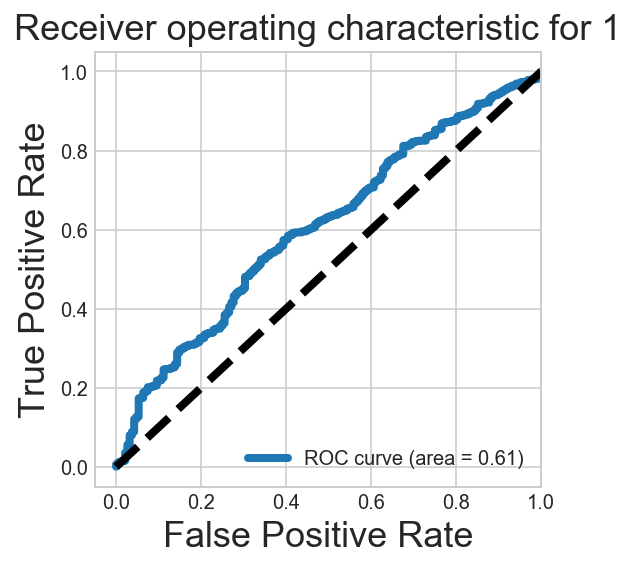

auc: 0.606303783279492

Confusion Table:
         predicted_0  predicted_1
class_0            0          188
class_1            1         3055

Classification Report:
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       188
          1       0.94      1.00      0.97      3056

avg / total       0.89      0.94      0.91      3244

f1: 0.9137809634120775
precision: 0.8874354438070731
severe_toxic


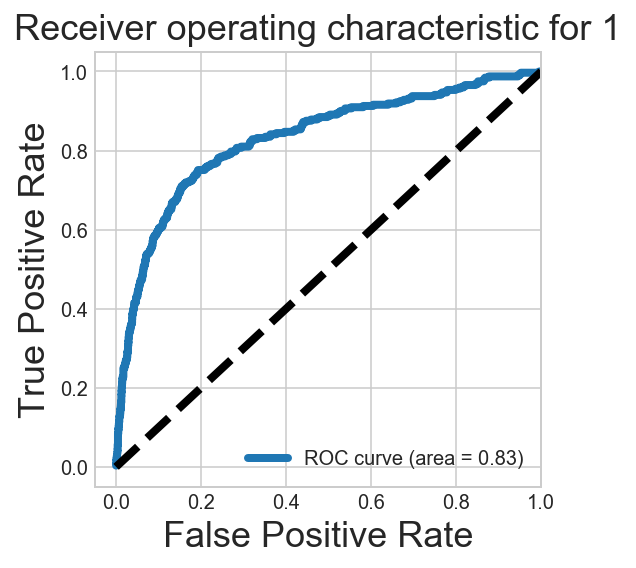

auc: 0.8301525232792238

Confusion Table:
         predicted_0  predicted_1
class_0         2869           54
class_1          241           80

Classification Report:
             precision    recall  f1-score   support

          0       0.92      0.98      0.95      2923
          1       0.60      0.25      0.35       321

avg / total       0.89      0.91      0.89      3244

f1: 0.8917851598505658
precision: 0.8902998729436937
obscene


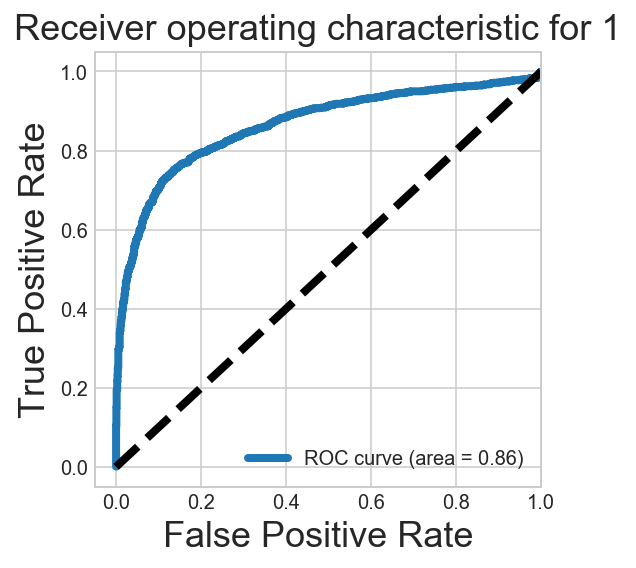

auc: 0.8646275028744563

Confusion Table:
         predicted_0  predicted_1
class_0         1312          217
class_1          421         1294

Classification Report:
             precision    recall  f1-score   support

          0       0.76      0.86      0.80      1529
          1       0.86      0.75      0.80      1715

avg / total       0.81      0.80      0.80      3244

f1: 0.8032605963121536
precision: 0.8095748574966116
threat


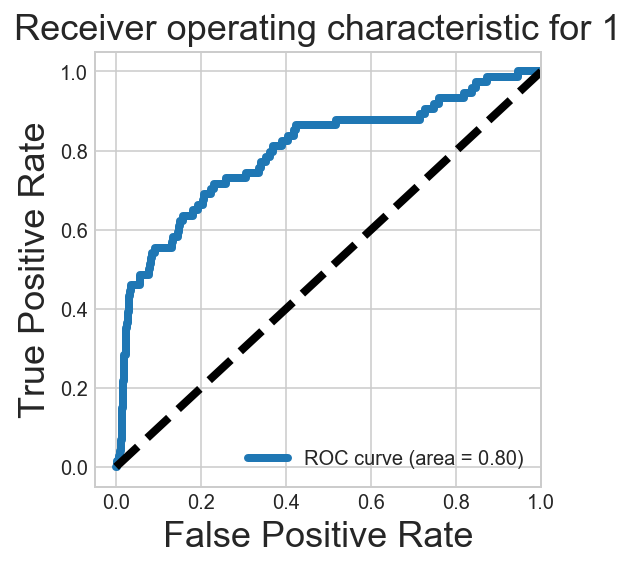

auc: 0.796738852417086

Confusion Table:
         predicted_0  predicted_1
class_0         3124           46
class_1           67            7

Classification Report:
             precision    recall  f1-score   support

          0       0.98      0.99      0.98      3170
          1       0.13      0.09      0.11        74

avg / total       0.96      0.97      0.96      3244

f1: 0.9623440220686024
precision: 0.9596838817862393
insult


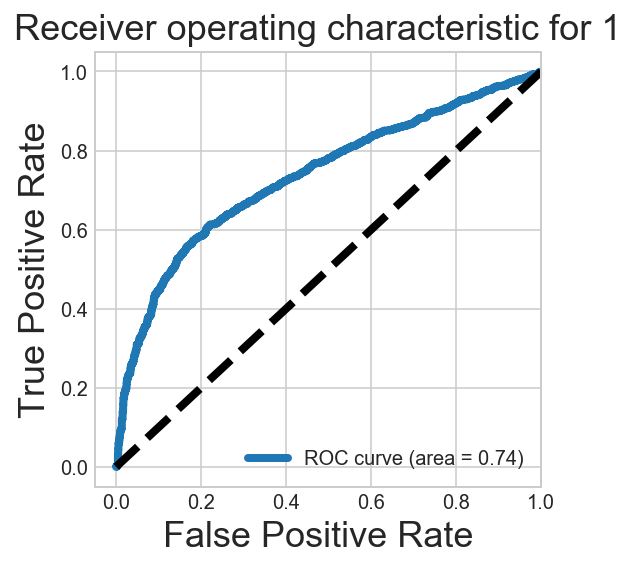

auc: 0.735537969150303

Confusion Table:
         predicted_0  predicted_1
class_0         1068          562
class_1          502         1112

Classification Report:
             precision    recall  f1-score   support

          0       0.68      0.66      0.67      1630
          1       0.66      0.69      0.68      1614

avg / total       0.67      0.67      0.67      3244

f1: 0.67192756757
precision: 0.672305380949393
identity_hate


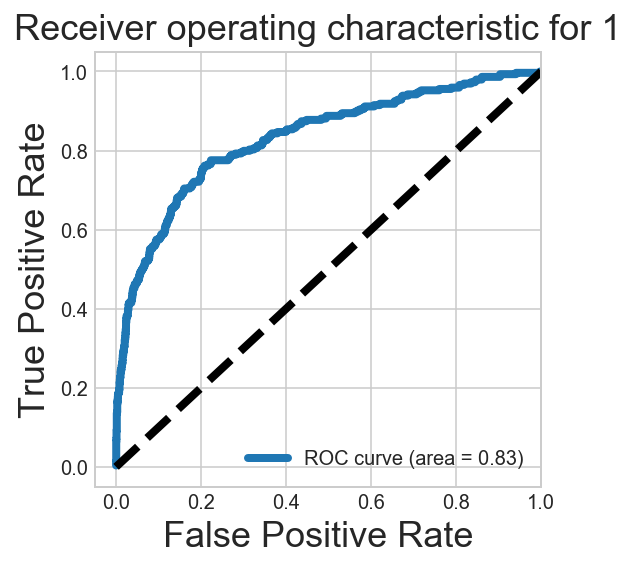

auc: 0.8321457396517928

Confusion Table:
         predicted_0  predicted_1
class_0         2925           25
class_1          231           63

Classification Report:
             precision    recall  f1-score   support

          0       0.93      0.99      0.96      2950
          1       0.72      0.21      0.33       294

avg / total       0.91      0.92      0.90      3244

f1: 0.9011381619476014
precision: 0.907692731040485


toxic  severe_toxic   obscene    threat    insult  identity_hate
auc    0.606304      0.830153  0.864628  0.796739  0.735538       0.832146
f1     0.913781      0.891785  0.803261  0.962344  0.671928       0.901138
presc  0.887435      0.890300  0.809575  0.959684  0.672305       0.907693

In [63]:
#sgd classifier
from sklearn.linear_model import SGDClassifier
SGDClassifier()
auc_ls = []
f1_ls = []
precision_ls = []
for label in labels:
    print (label)
    roc_auc, f1_score, precision_score = model_performance(SGDClassifier(loss='log'), X_train2_csr, y_train2_csr[label], X_test2_csr, y_test2_csr[label])
    auc_ls.append(roc_auc)
    f1_ls.append(f1_score)
    precision_ls.append(precision_score)
scores = [auc_ls, f1_ls, precision_ls]
metrics = pd.DataFrame(scores, columns=labels, index=(['auc','f1','presc']))
metrics

##### Randomforest

In [137]:
#use a randomized search due to large number of parameters
from sklearn.model_selection import RandomizedSearchCV
random_grid = {'bootstrap': [True, False],
 'max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
 'max_features': ['auto', 'sqrt'],
 'min_samples_leaf': [1, 2, 4],
 'min_samples_split': [2, 5, 10]
}
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, scoring='recall', n_iter = 10, cv = 3, verbose=2, random_state=42) #n_jobs = -1
# Fit the random search model
rf_random.fit(X_train2_csr, y_train2_csr['threat'])
print (rf_random.best_score_)
print (rf_random.best_estimator_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=True 
[CV]  min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=True, total=   2.2s
[CV] min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=True 


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.3s remaining:    0.0s


[CV]  min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=True, total=   1.7s
[CV] min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=True 
[CV]  min_samples_split=2, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=True, total=   1.8s
[CV] min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False 
[CV]  min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False, total=   2.7s
[CV] min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False 
[CV]  min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False, total=   3.5s
[CV] min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False 
[CV]  min_samples_split=5, min_samples_leaf=4, max_features=auto, max_depth=50, bootstrap=False, total=   2.9s
[CV] min_samples_split=5, min_samples_leaf=4, max_features=sqrt,

[Parallel(n_jobs=1)]: Done  30 out of  30 | elapsed:  1.5min finished


0.03956372176215874
RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=None, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)


toxic


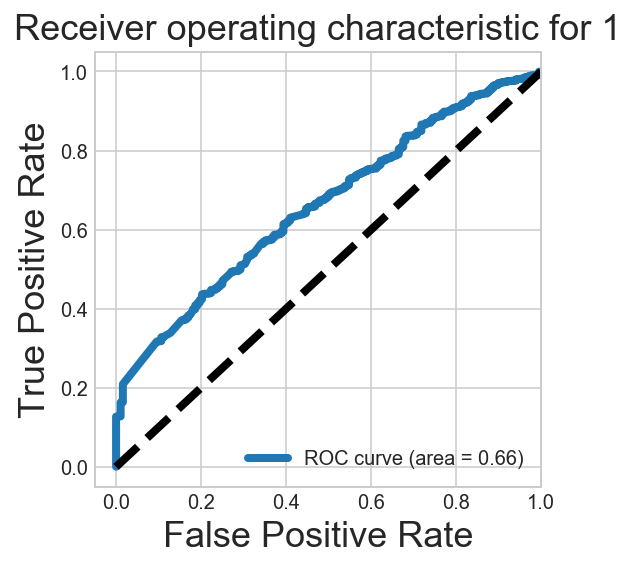

auc: 0.6607284588392559

Confusion Table:
         predicted_0  predicted_1
class_0            0          188
class_1            0         3056

Classification Report:
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       188
          1       0.94      1.00      0.97      3056

avg / total       0.89      0.94      0.91      3244

f1: 0.9139349813085941
precision: 0.8874522783976793
severe_toxic


C:\Users\Samson\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Samson\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Samson\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


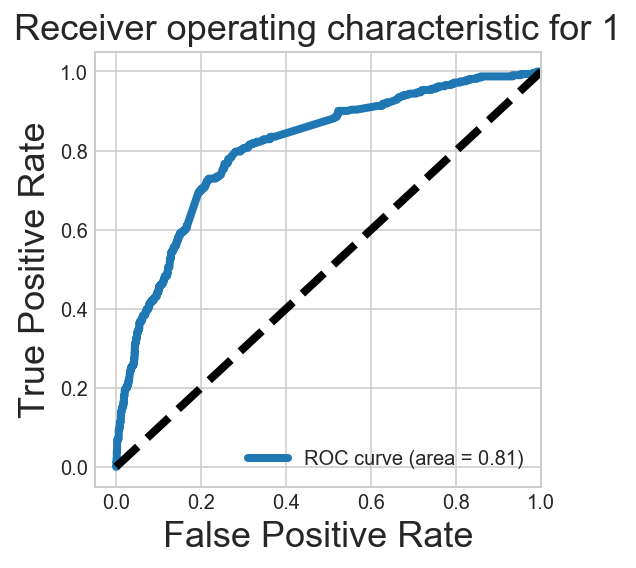

auc: 0.8073070704680784

Confusion Table:
         predicted_0  predicted_1
class_0         2921            2
class_1          318            3

Classification Report:
             precision    recall  f1-score   support

          0       0.90      1.00      0.95      2923
          1       0.60      0.01      0.02       321

avg / total       0.87      0.90      0.86      3244

f1: 0.8560767890460081
precision: 0.8719557306547171
obscene


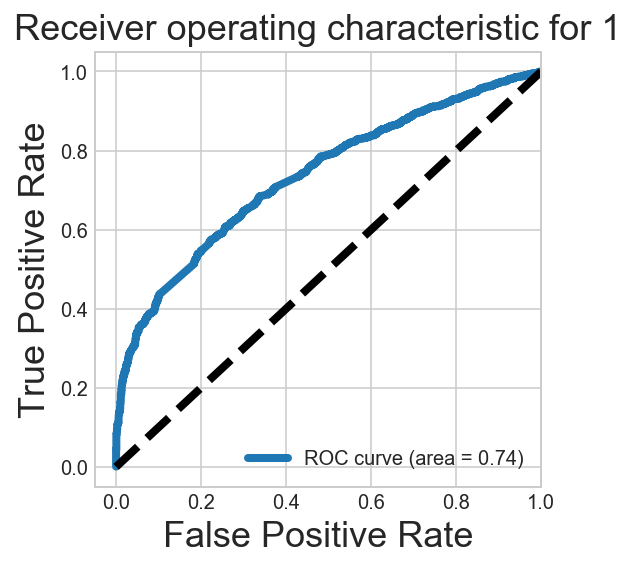

auc: 0.7356240001372875

Confusion Table:
         predicted_0  predicted_1
class_0          854          675
class_1          439         1276

Classification Report:
             precision    recall  f1-score   support

          0       0.66      0.56      0.61      1529
          1       0.65      0.74      0.70      1715

avg / total       0.66      0.66      0.65      3244

f1: 0.6532909731192957
precision: 0.6570664608077688
threat


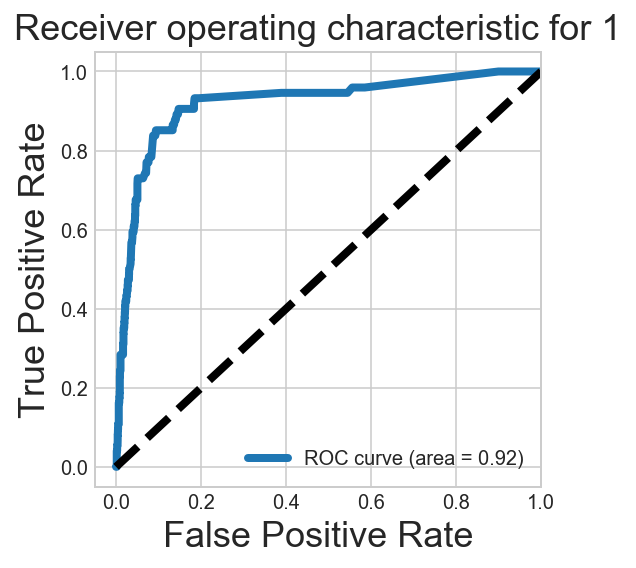

auc: 0.9201146730326542

Confusion Table:
         predicted_0  predicted_1
class_0         3169            1
class_1           74            0

Classification Report:
             precision    recall  f1-score   support

          0       0.98      1.00      0.99      3170
          1       0.00      0.00      0.00        74

avg / total       0.95      0.98      0.97      3244

f1: 0.9657604399817494
precision: 0.9548907958068084
insult


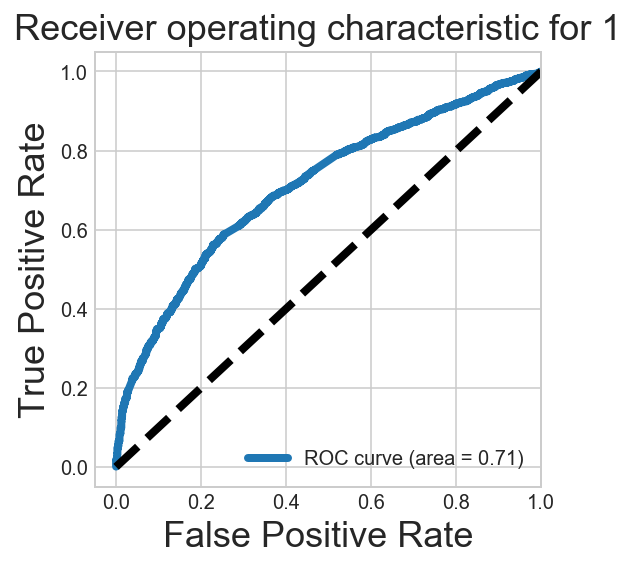

auc: 0.7111128849560213

Confusion Table:
         predicted_0  predicted_1
class_0         1285          345
class_1          749          865

Classification Report:
             precision    recall  f1-score   support

          0       0.63      0.79      0.70      1630
          1       0.71      0.54      0.61      1614

avg / total       0.67      0.66      0.66      3244

f1: 0.6572317440508031
precision: 0.6731130843328075
identity_hate


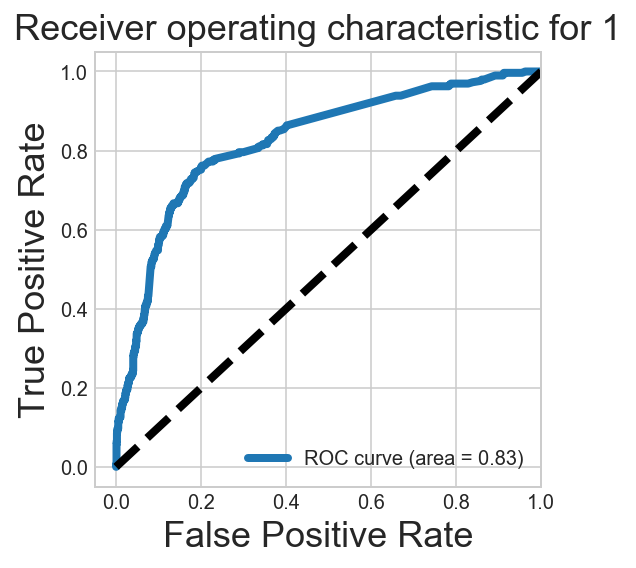

auc: 0.8256070563818748

Confusion Table:
         predicted_0  predicted_1
class_0         2949            1
class_1          293            1

Classification Report:
             precision    recall  f1-score   support

          0       0.91      1.00      0.95      2950
          1       0.50      0.00      0.01       294

avg / total       0.87      0.91      0.87      3244

f1: 0.8668059978511474
precision: 0.8724999638681881


toxic  severe_toxic   obscene    threat    insult  identity_hate
auc    0.660728      0.807307  0.735624  0.920115  0.711113       0.825607
f1     0.913935      0.856077  0.653291  0.965760  0.657232       0.866806
presc  0.887452      0.871956  0.657066  0.954891  0.673113       0.872500

In [64]:
from sklearn.ensemble import RandomForestClassifier
rf = RandomForestClassifier(bootstrap=False, class_weight=None, criterion='gini',
            max_depth=50, max_features='sqrt', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=2, min_samples_split=5,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=1,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)
auc_ls = []
f1_ls = []
precision_ls = []
for label in labels:
    print (label)
    roc_auc, f1_score, precision_score = model_performance(rf, X_train2_csr, y_train2_csr[label], X_test2_csr, y_test2_csr[label])
    auc_ls.append(roc_auc)
    f1_ls.append(f1_score)
    precision_ls.append(precision_score)
scores = [auc_ls, f1_ls, precision_ls]
metrics = pd.DataFrame(scores, columns=labels, index=(['auc','f1','presc']))
metrics

##### XGBoost

In [138]:
#use a randomized search due to large number of parameters
random_grid = {
        'min_child_weight': [1, 5, 10],
        'gamma': [0.5, 1, 1.5, 2, 5],
        'subsample': [0.6, 0.8, 1.0],
        'colsample_bytree': [0.6, 0.8, 1.0],
        'max_depth': [3, 4, 5]
        }
from xgboost import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV

xgb = XGBClassifier()

# search across 100 different combinations, and use all available cores
xgb_random = RandomizedSearchCV(estimator = xgb, param_distributions = random_grid, scoring='roc_auc', n_jobs=4, n_iter = 10, cv = 3, verbose=2) #n_jobs = -1
# Fit the random search model
xgb_random.fit(X_train2_csr, y_train2_csr['threat'])
print (xgb_random.best_score_)
print (xgb_random.best_estimator_)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


[Parallel(n_jobs=4)]: Done  30 out of  30 | elapsed:  2.8min finished


0.8927176510855032
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=1.5, learning_rate=0.1,
       max_delta_step=0, max_depth=4, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1.0)


In [56]:
xgb = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=0.8, gamma=1.5, learning_rate=0.1,
       max_delta_step=0, max_depth=4, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=1, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=0,
       reg_lambda=1, scale_pos_weight=1, seed=None, silent=True,
       subsample=1.0)

toxic


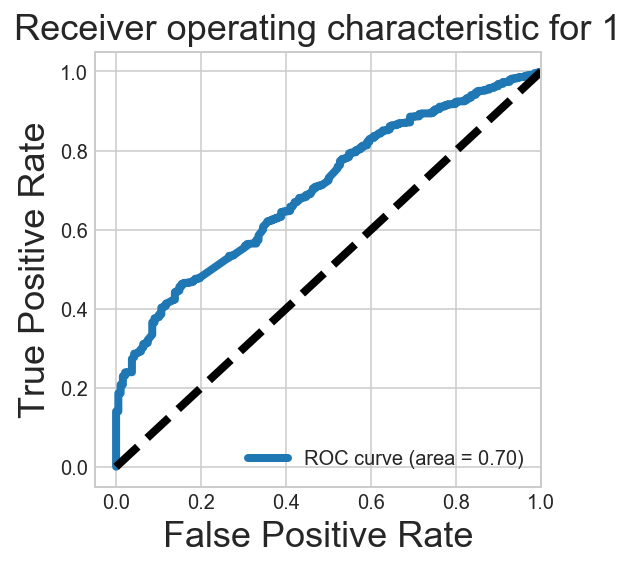

auc: 0.7003992842820541

Confusion Table:
         predicted_0  predicted_1
class_0            0          188
class_1            0         3056

Classification Report:
             precision    recall  f1-score   support

          0       0.00      0.00      0.00       188
          1       0.94      1.00      0.97      3056

avg / total       0.89      0.94      0.91      3244

f1: 0.9139349813085941
precision: 0.8874522783976793
severe_toxic


C:\Users\Samson\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:
C:\Users\Samson\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Samson\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
C:\Users\Samson\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Prec

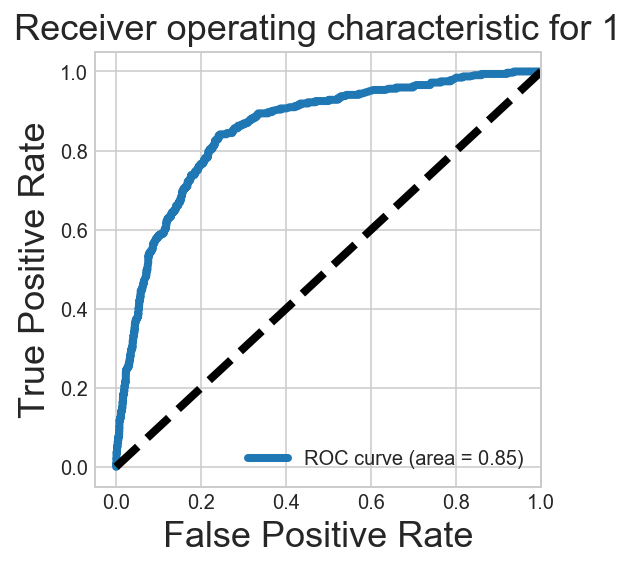

auc: 0.8534114973840514

Confusion Table:
         predicted_0  predicted_1
class_0         2874           49
class_1          264           57

Classification Report:
             precision    recall  f1-score   support

          0       0.92      0.98      0.95      2923
          1       0.54      0.18      0.27       321

avg / total       0.88      0.90      0.88      3244

f1: 0.8809345594469961
precision: 0.8784528858378755
obscene


C:\Users\Samson\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


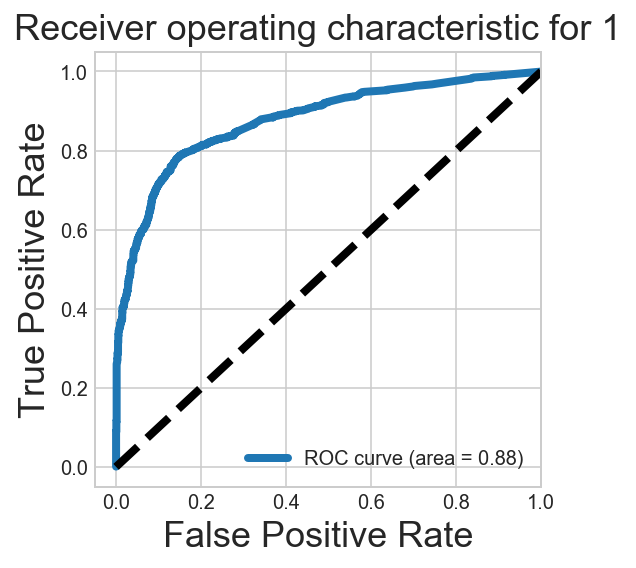

auc: 0.8768613415654966

Confusion Table:
         predicted_0  predicted_1
class_0         1352          177
class_1          451         1264

Classification Report:
             precision    recall  f1-score   support

          0       0.75      0.88      0.81      1529
          1       0.88      0.74      0.80      1715

avg / total       0.82      0.81      0.81      3244

f1: 0.8059679526707937
precision: 0.8171646725179011
threat


C:\Users\Samson\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


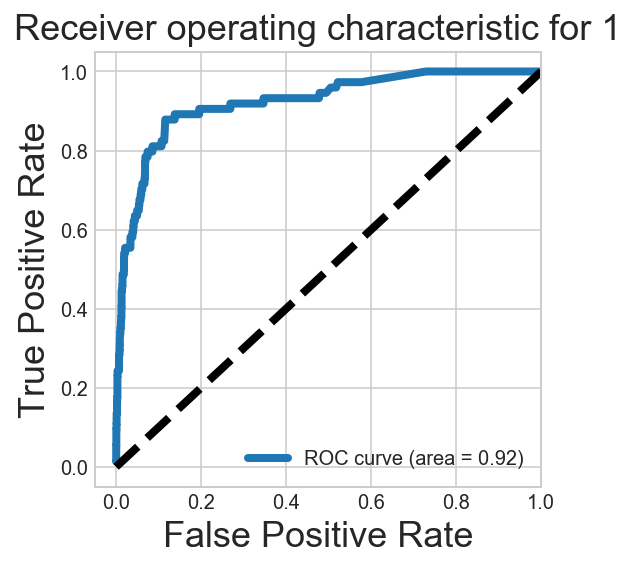

auc: 0.9228941086196607

Confusion Table:
         predicted_0  predicted_1
class_0         3157           13
class_1           56           18

Classification Report:
             precision    recall  f1-score   support

          0       0.98      1.00      0.99      3170
          1       0.58      0.24      0.34        74

avg / total       0.97      0.98      0.97      3244

f1: 0.9744463140557073
precision: 0.973402341946108
insult


C:\Users\Samson\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


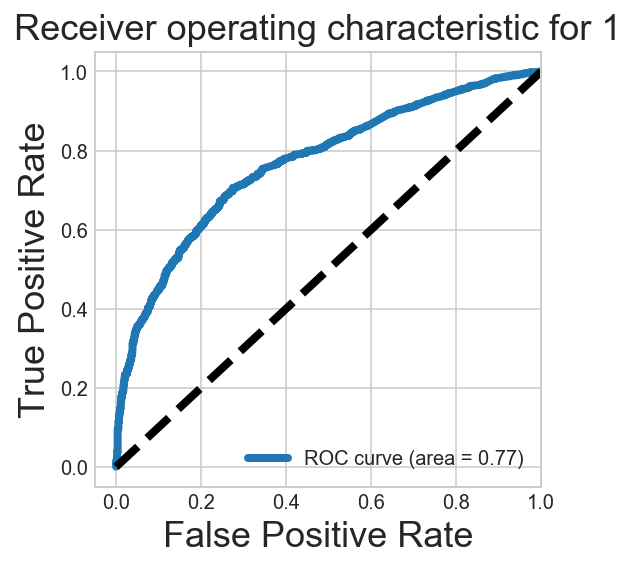

auc: 0.7693985145315909

Confusion Table:
         predicted_0  predicted_1
class_0         1301          329
class_1          628          986

Classification Report:
             precision    recall  f1-score   support

          0       0.67      0.80      0.73      1630
          1       0.75      0.61      0.67      1614

avg / total       0.71      0.70      0.70      3244

f1: 0.7023284158610339
precision: 0.7119404388655838
identity_hate


C:\Users\Samson\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


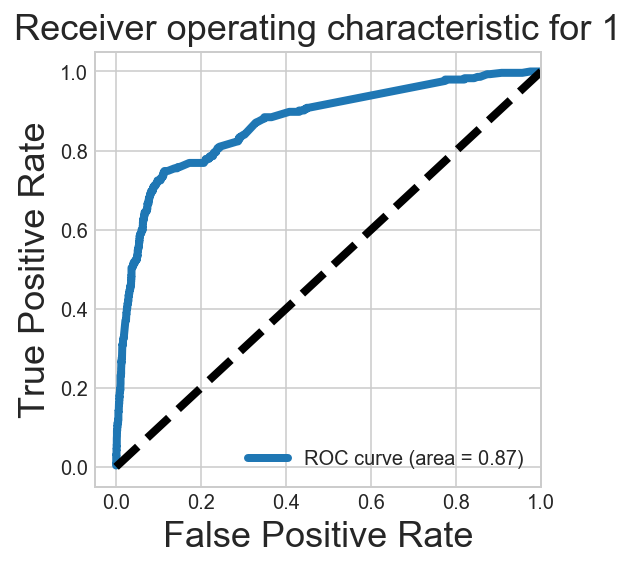

auc: 0.8686481033091203

Confusion Table:
         predicted_0  predicted_1
class_0         2913           37
class_1          216           78

Classification Report:
             precision    recall  f1-score   support

          0       0.93      0.99      0.96      2950
          1       0.68      0.27      0.38       294

avg / total       0.91      0.92      0.91      3244

f1: 0.9060917977272902
precision: 0.9080657703831476


C:\Users\Samson\AppData\Local\Continuum\anaconda2\envs\py36\lib\site-packages\sklearn\preprocessing\label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


toxic  severe_toxic   obscene    threat    insult  identity_hate
auc    0.700399      0.853411  0.876861  0.922894  0.769399       0.868648
f1     0.913935      0.880935  0.805968  0.974446  0.702328       0.906092
presc  0.887452      0.878453  0.817165  0.973402  0.711940       0.908066

In [65]:
from xgboost import XGBClassifier
xgb = XGBClassifier()

auc_ls = []
f1_ls = []
precision_ls = []
for label in labels:
    print (label)
    roc_auc, f1_score, precision_score = model_performance(xgb, X_train2_csr, y_train2_csr[label], X_test2_csr, y_test2_csr[label])
    auc_ls.append(roc_auc)
    f1_ls.append(f1_score)
    precision_ls.append(precision_score)
scores = [auc_ls, f1_ls, precision_ls]
metrics = pd.DataFrame(scores, columns=labels, index=(['auc','f1','presc']))
metrics

<b>For both step 1 & 2, lasso model works the best in terms of overall auc, f1 and recall scores.

### Top Features

In [60]:
#step 1 models
model_negative = LogisticRegression(penalty='l1', solver='liblinear', C=4.2813324).fit(X_train1_csr, y_train1_csr)

coefs = list(zip(np.asarray(pipe_text1.named_steps['vect'].get_feature_names()), model_negative.coef_[0]))
coefs = pd.DataFrame.from_records(coefs)
coefs['abs'] = abs(coefs[1])
print ('Top 10 features')
print (coefs[coefs[1] > 0].sort_values('abs', ascending=False).head(10))
#top 10 features to identify negative comments

Top 10 features
             0           1         abs
49270     fuck  101.819367  101.819367
105432    shit   45.169468   45.169468
16768    bitch   43.590203   43.590203
53149    idiot   39.405220   39.405220
48016   faggot   38.362035   38.362035
14911   asshol   37.574087   37.574087
14766      ass   33.962761   33.962761
116839  stupid   33.783717   33.783717
117792    suck   33.069933   33.069933
49821   fucker   31.744040   31.744040


In [61]:
#step 2 models
from sklearn.linear_model import LogisticRegression

model_toxic = LogisticRegression(C=10).fit(X_train2_csr, y_train2_csr['toxic'])
model_severe_toxic = LogisticRegression(C=10).fit(X_train2_csr, y_train2_csr['severe_toxic'])
model_obscene = LogisticRegression(C=10).fit(X_train2_csr, y_train2_csr['obscene'])
model_threat = LogisticRegression(C=10).fit(X_train2_csr, y_train2_csr['threat'])
model_insult = LogisticRegression(C=10).fit(X_train2_csr, y_train2_csr['insult'])
model_identity_hate = LogisticRegression(C=10).fit(X_train2_csr, y_train2_csr['identity_hate'])

In [62]:
models = [model_toxic, model_severe_toxic, model_obscene, model_threat, model_insult, model_identity_hate]

In [63]:
for i, model in enumerate(models):
    coefs = list(zip(np.asarray(pipe_text2.named_steps['vect'].get_feature_names()), model.coef_[0]))
    coefs = pd.DataFrame.from_records(coefs)
    coefs['abs'] = abs(coefs[1])
    print ('Top 10 features', labels[i])
    print (coefs[coefs[1] > 0].sort_values('abs', ascending=False).head(10))
#looks like non of the transformed non-text features made it to the top 10 predictors

Top 10 features toxic
             0          1        abs
49270     fuck  11.537883  11.537883
116839  stupid   4.949595   4.949595
106738    shut   4.001206   4.001206
55713     kill   3.323456   3.323456
26937     cock   3.115303   3.115303
48016   faggot   3.063364   3.063364
50187      gay   2.669823   2.669823
80501     piec   2.618929   2.618929
105432    shit   2.611165   2.611165
51377       ha   2.559812   2.559812
Top 10 features severe_toxic
                 0         1       abs
64404   motherfuck  6.315902  6.315902
49860       fuckin  5.778444  5.778444
14978      asshole  5.232011  5.232011
49270         fuck  5.187784  5.187784
25604           ck  4.994347  4.994347
14938  asshol fuck  4.859976  4.859976
50212     gay fuck  4.303222  4.303222
52687         hope  4.244722  4.244722
49733    fuck stop  4.201662  4.201662
46241    dumb fuck  4.162713  4.162713
Top 10 features obscene
               0          1        abs
49270       fuck  38.538551  38.538551
14911     a

## Productionising

In [72]:
input1 = input()
input_df = pd.DataFrame([input1], columns=['comment_text'])
text_clean(input_df, 'comment_text')
text_attr(input_df, 'comment_text')
input_senti = sentiment(input_df, 'comment_text')
input_senti['comment_text'] = input_senti['comment_text'].apply(snowball_stem)
input_senti['comment_text'] = input_senti['comment_text'].apply(lambda x: " ".join(x))
input_cvect = pipe_text.transform(input_senti['comment_text'])
input_nontext_ss = StandardScaler().fit(train_senti[['text_len','unique_text','spam_inv_ratio','compound']]).transform(input_senti[['text_len','unique_text','spam_inv_ratio','compound']])
input_csr = sp.sparse.hstack((input_cvect,input_nontext_ss),format='csr')
print ('negative', model_negative.predict_proba(input_csr)[0][1])
if model_negative.predict_proba(input_csr)[0][1] > 0.5:
    for i, model in enumerate(models):
        print (labels[i], model.predict_proba(input_csr)[0][1])

# for i, model in enumerate(models):
#     print (labels[i], model.predict_proba(input_csr)[0][1])

i am going to fcuking kill you!
negative 0.9012953604433962
toxic 0.996321727728922
severe_toxic 0.051106462829543946
obscene 0.44651569401672814
threat 0.8051544543365405
insult 0.3098875600187218
identity_hate 0.01865003452521315


## Final 2 step combination score for comparison

In [64]:
#get the predicted first step of negative comments
y_pred_neg = model_negative.predict(X_test1_csr)
combine_test = pd.concat([test.reset_index(drop=True),pd.DataFrame(y_pred_neg)], axis=1)
neg_test = combine_test[combine_test[0]==1]

In [65]:
#for those predicted negative, continue to predict the types of negativity
import warnings
warnings.filterwarnings('ignore')

text_clean(neg_test, 'comment_text')
text_attr(neg_test, 'comment_text')
neg_test_senti = sentiment(neg_test, 'comment_text')
neg_test_cvect = pipe_text.transform(neg_test['comment_text'])
neg_test_nontext_ss = StandardScaler().fit(train_senti[['text_len','unique_text','spam_inv_ratio','compound']]).transform(neg_test_senti[['text_len','unique_text','spam_inv_ratio','compound']])
neg_test_csr = sp.sparse.hstack((neg_test_cvect,neg_test_nontext_ss),format='csr')

labels_pred = []
for label in labels:
    labels_pred.append(label+'_pred')
predictions = {}
for i, model in enumerate(models):
    predictions[labels_pred[i]] = model.predict(neg_test_csr)
neg_test_w_pred = pd.concat([neg_test.reset_index(), pd.DataFrame(predictions)], axis=1)
neg_test_w_pred = neg_test_w_pred.set_index('index')

In [66]:
#concat final predictions with test dataset
final_pred = pd.concat([combine_test, neg_test_w_pred[labels_pred]], axis=1)
final_pred.drop(['text_len','unique_text','spam_inv_ratio'], axis=1, inplace=True)
final_pred = final_pred.fillna(0)

In [67]:
#get confusion table and scores
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn import metrics

f1_ls = []
precision_ls = []

for i, label in enumerate(labels):
    print (label)
    conmat = np.array(confusion_matrix(final_pred[label], final_pred[labels_pred[i]]))
    confusion = pd.DataFrame(conmat, index=["class_0", "class_1"], 
                             columns=["predicted_0","predicted_1"])    

    f1_score = metrics.f1_score(final_pred[label], final_pred[labels_pred[i]], average='weighted')
    precision_score = metrics.precision_score(final_pred[label], final_pred[labels_pred[i]], average='weighted')
    f1_ls.append(f1_score)
    precision_ls.append(precision_score)
    print ('')
    print ('Confusion Table:')
    print (confusion)
    print ('')
    print ('Classification Report:')
    print (classification_report(final_pred[label], final_pred[labels_pred[i]]))
    print ('f1:',f1_score)
    print ('precision:',precision_score)
scores = [f1_ls, precision_ls]
metrics = pd.DataFrame(scores, columns=labels, index=(['f1','presc']))
metrics

toxic

Confusion Table:
         predicted_0  predicted_1
class_0        28410          449
class_1          880         2176

Classification Report:
             precision    recall  f1-score   support

          0       0.97      0.98      0.98     28859
          1       0.83      0.71      0.77      3056

avg / total       0.96      0.96      0.96     31915

f1: 0.9569328434282253
precision: 0.9564539434618886
severe_toxic

Confusion Table:
         predicted_0  predicted_1
class_0        31471          123
class_1          209          112

Classification Report:
             precision    recall  f1-score   support

          0       0.99      1.00      0.99     31594
          1       0.48      0.35      0.40       321

avg / total       0.99      0.99      0.99     31915

f1: 0.9887999173713177
precision: 0.9882047499656482
obscene

Confusion Table:
         predicted_0  predicted_1
class_0        29897          303
class_1          486         1229

Classification Report:
     

toxic  severe_toxic   obscene    threat    insult  identity_hate
f1     0.956933      0.988800  0.974619  0.997264  0.968194       0.990465
presc  0.956454      0.988205  0.974236  0.997061  0.967734       0.990172

<b> Though 2 step model performs slightly worse off than single step model in terms of precision of toxic types, <br>
f1 scores are higher and recall rates for the different toxicity are all significantly higher.